In [4]:
# Install a pip package in the current Jupyter kernel
import sys
import os
sys.path.append('../')
sys.path.append('../corv/src')


### General
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import astropy
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join

from tqdm import tqdm
import pandas as pd
from scipy.optimize import curve_fit
import scipy.stats as stats

### Tools
import WD_models
from bisect import bisect_left
import lmfit
import glob

from astroquery.sdss import SDSS
from astroquery.gaia import Gaia

#corv.sdss.make_catalogs()

In [5]:
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16

In [6]:
from __future__ import print_function
from astropy.coordinates import SkyCoord
import astropy.units as u
from dustmaps.bayestar import BayestarQuery

coords = SkyCoord('12h30m25.3s', '15d15m58.1s', distance = 200 * u.kpc, frame='icrs')
bsq = BayestarQuery()
ebv = bsq.query(coords)

coords = SkyCoord('12h30m25.3s', '15d15m58.1s', distance = 200 * u.kpc, frame='icrs')
print('E(B-V) = {:.3f} mag'.format(ebv))
#print(ebv)

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 44.696 s
  pix_info:   0.911 s
   samples:  24.375 s
      best:  12.704 s
       nan:   1.517 s
      sort:   5.063 s
       idx:   0.126 s
E(B-V) = 0.060 mag


In [7]:
ls

01_select_data.ipynb  03_wd_spectra.ipynb  data/   spectra/
02_photometry.ipynb   04_relation.ipynb    sdss5/  stefan.mplstyle


In [88]:
from astropy.table import Table, vstack

ms_sdss4_wd_sdss4 = Table.read('data/ms_sdss4_wd_sdss4.fits')
ms_gaia_wd_sdss4 = Table.read('data/ms_gaia_wd_sdss4.fits')
#ms_sdss5_wd_sdss4 = Table.read('sdss5/ms_sdss5_wd_sdss4.fits')

#ms_gaia_wd_sdss5 = Table.read('sdss5/ms_gaia_wd_sdss5.fits')
#ms_sdss5_wd_sdss5 = Table.read('sdss5/ms_sdss5_wd_sdss5.fits')

def strip(catalog):  
    drop_cols = []
    keep_cols = ['wd_source_id', 'wd_l', 'wd_b', 'ms_parallax', 'ms_parallax_over_error', 'wd_ra', 'wd_dec', 
                 'wd_bp_rp', 'wd_phot_g_mean_mag', 'wd_phot_bp_mean_mag', 'wd_phot_rp_mean_mag', 'wd_phot_g_mean_flux', 'wd_phot_bp_mean_flux', 'wd_phot_rp_mean_flux',
                 'wd_phot_g_mean_flux_error', 'wd_phot_bp_mean_flux_error', 'wd_phot_rp_mean_flux_error', 'uses_sdss5']
        
    for key in catalog.keys():
        if key not in keep_cols:
            drop_cols.append(key)
            
    catalog.remove_columns(drop_cols)
    
    return catalog

ms_sdss4_wd_sdss4 = strip(ms_sdss4_wd_sdss4)
ms_gaia_wd_sdss4  = strip(ms_gaia_wd_sdss4 )
#ms_sdss5_wd_sdss4 = strip(ms_sdss5_wd_sdss4)
#ms_gaia_wd_sdss5  = strip(ms_gaia_wd_sdss5 )
#ms_sdss5_wd_sdss5 = strip(ms_sdss5_wd_sdss5)

catalog = vstack([ms_sdss4_wd_sdss4, ms_gaia_wd_sdss4])#, ms_sdss5_wd_sdss4, ms_gaia_wd_sdss5, ms_sdss5_wd_sdss5])

In [89]:
print(len(catalog))

182


In [90]:
coords = [SkyCoord(frame="galactic", l=catalog['wd_l'][i]*u.deg, b=catalog['wd_b'][i]*u.deg, distance = (1000/catalog['ms_parallax'][i]) * u.pc) for i in range(len(catalog))]
catalog['wd_coords'] = coords

In [91]:
catalog

<Table length=182>
    wd_source_id       ms_parallax     ... uses_sdss5                        wd_coords                        
                                       ...                                   deg,deg,pc                       
       int64             float64       ...  float64                           SkyCoord                        
------------------- ------------------ ... ---------- --------------------------------------------------------
 617887567299258752   4.37258500291746 ...        0.0  218.50057423906915,43.40779834003678,228.69766953250394
 676167215489980800 3.5833073189526377 ...        0.0   202.22994470577615,29.19811204065222,279.0717934548492
 743097619303531904  5.863700752526844 ...        0.0    202.03261288796904,51.30771679111123,170.540762942084
 921518807117547904  5.832015547589917 ...        0.0 179.07457241455214,30.472493801674776,171.46730694386616
1261421999231535616 11.875503890723863 ...        0.0    28.0236860016812,60.718317157600964,84.20695317030844
2509935938109492736  3.860940809884901 ...        0.0 144.30405368806024,-61.47624364047808,259.00422960118135
2534148150521389440    8.6674052024515 ...        0.0 139.32086971972922,-62.083704178135584,115.3747836454166
2534260777448123392 3.4372302444102716 ...        0.0  140.53143957254466,-61.6705586190252,290.93192160351504
2688215048406240640    3.3433464152313 ...        0.0  54.95428273204752,-34.59183898849673,299.10152159055224
                ...                ... ...        ...                                                      ...
 582006173558312704  5.584047944960324 ...        1.0  222.9097719919775,29.962107139816876,179.08155693801177
3079481999225480448  8.795208706942383 ...        1.0 223.52417856878355,23.691025761782956,113.69826837772061
3843636017819635968  2.974714739367859 ...        1.0   228.6488658357819,30.304868297464044,336.1666874358866
3847295570474498688  12.93745681250264 ...        1.0     232.94592477053754,37.1812105440492,77.2949440135413
 582006173558312704  5.584047944960324 ...        1.0  222.9097719919775,29.962107139816876,179.08155693801177
3075883228950785408 1.9301766749872706 ...        1.0  225.66460168310803,27.199151641118206,518.0872885672991
3843361002474467328 2.7077851315039174 ...        1.0 229.61655679932943,30.666802721317328,369.30552146306934
3847515301001790208 3.6232986322024816 ...        1.0    232.3727489850514,37.26948794415443,275.9916036487817
3852170667594666496 2.3945808060946048 ...        1.0  228.11775698747846,37.47293860852421,417.60962814653584

In [92]:
ebv = []
flag1 = []
flag2 = []

for i in tqdm(range(len(catalog))):
    bsq_res = bsq.query(catalog['wd_coords'][i], return_flags = True)
        
    ebv.append(bsq_res[0])
    flag1.append(bsq_res[1][0])
    flag2.append(bsq_res[1][1])
    
catalog['E(B-V)'] = ebv
catalog['converged'] = flag1
catalog['reliable_dist'] = flag2

100%|█████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 86.29it/s]


In [93]:
#catalog['A_g'] = np.repeat(np.nan, len(catalog))
#catalog['A_bp'] = np.repeat(np.nan, len(catalog))
#catalog['A_rp'] = np.repeat(np.nan, len(catalog))
#
#for obj in tqdm(catalog):
#    obj['A_g'] = obj['E(B-V)'] * 3.518
#    obj['A_bp'] = obj['E(B-V)'] * 2.617
#    obj['A_rp'] = obj['E(B-V)'] * 1.971
#    
#catalog['dered_g'] = catalog['u'] - catalog['A_u']
#catalog['dered_bp'] = catalog['g'] - catalog['A_g']
#catalog['dered_rp'] = catalog['r'] - catalog['A_r']
#
catalog['r_est'] = 1000 / catalog['ms_parallax']

In [94]:
font_model = WD_models.load_model('f', 'f', 'f', 'H', HR_bands = ['Su-Sg', 'Su'])

g_acc = (10**font_model['logg'])/100
rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
logg_teff_to_rsun = WD_models.interp_xy_z_func(x = font_model['logg'], y = 10**font_model['logteff'],
                                            z = rsun, interp_type = 'linear')

fitsed_sdss = WD_models.FitSED(to_flux = False, atm_type = 'H', bands = ['Su', 'Sg', 'Sr'])#, 'Si', 'Sz'])
fitsed_gaia = WD_models.FitSED(to_flux = False, atm_type = 'H', bands = ['G', 'bp', 'rp'])#, 'Si', 'Sz'])

initialized with atm_type = H and bands = ['Su', 'Sg', 'Sr']
initialized with atm_type = H and bands = ['G', 'bp', 'rp']


In [95]:
def mag_to_flux(mag):
    return 10 ** ((mag + 48.6)/ -2.5) 

def flux_to_mag(flux):
    return -2.5 * np.log10(flux) - 48.60
    
def get_model_flux_gaia(params):
    
    teff, logg, radius, distance = params['teff'], params['logg'], params['radius'], params['distance']
    
    model_mag = fitsed_gaia.model_sed(teff, logg, plx = 100)
    model_flux = mag_to_flux(model_mag)
    
    rsun = logg_teff_to_rsun(logg, teff)
    corr_radius = rsun * radius_sun
    corr_distance = 10 * pc_to_m
    
    corr_model_flux = model_flux / (4 * np.pi * (corr_radius / corr_distance)**2)
    
    radius = radius * radius_sun # Rsun to meter
    distance = distance * pc_to_m # Parsec to meter
     
    flux = corr_model_flux * ( 4 * np.pi * (radius / distance)**2 )
    
    return flux_to_mag(flux)
    

def residual_gaia(params, obs_flux = None, e_obs_flux = None):
    model_flux = (get_model_flux_gaia(params))

    chisquare = ((model_flux - obs_flux) / e_obs_flux)**2
    
    #chisquare[np.isnan(chisquare)] = 1e8
    return chisquare

In [96]:
def get_parameters_gaia(obs_mag, e_obs_mag, id_ = None, floor_error = 0.02, make_plot = False, vary_logg = False, p0 = [10000, 8, 0.01, 100]):         
    e_obs_mag = np.sqrt(e_obs_mag**2 + floor_error**2)
    
    params = lmfit.Parameters()

    params.add('teff', value = p0[0], min = 3500, max = 55000, vary = True)
    params.add('logg', value = p0[1], min=7.5, max=9, vary=vary_logg)
    params.add('radius', value = p0[2], min = 0.0001, max = 0.05, vary = True)
    params.add('distance', value = p0[3], min = 1, max = 2000, vary = False)
        
    #result = lmfit.minimize(residual, params, kws = dict(obs_flux = obs_flux, e_obs_flux = e_obs_flux), method = 'emcee', steps = 5000, burn = 500, thin = 20, is_weighted = False, progress = False)
    result = lmfit.minimize(residual_gaia, params, kws = dict(obs_flux = obs_mag, e_obs_flux = e_obs_mag), method = 'leastsq')
    
    #result.params.pretty_print()
        
    return result

In [97]:
gaia_results = []
gaia_results7 = []
gaia_results9 = []

sigmaG_0 = 0.0027553202
sigmaGBP_0 = 0.0027901700
sigmaGRP_0 = 0.0037793818

e_results = []

logg_vary = []

id_ = []

for i in tqdm(range(len(catalog))):
    id_.append(i)
    obs_mag_gaia = np.array([catalog['wd_phot_g_mean_mag'][i], catalog['wd_phot_bp_mean_mag'][i], catalog['wd_phot_rp_mean_mag'][i]])
    e_obs_mag_gaia = np.array([np.sqrt((-2.5/np.log(10)*catalog['wd_phot_g_mean_flux_error'][i]/catalog['wd_phot_g_mean_flux'][i])**2 + sigmaG_0**2), 
                               np.sqrt((-2.5/np.log(10)*catalog['wd_phot_bp_mean_flux_error'][i]/catalog['wd_phot_bp_mean_flux'][i])**2 + sigmaGBP_0**2), 
                               np.sqrt((-2.5/np.log(10)*catalog['wd_phot_rp_mean_flux_error'][i]/catalog['wd_phot_rp_mean_flux'][i])**2 + sigmaGRP_0**2)])
    
    #obs_mag = np.array([catalog['u'][i] - 0.040, catalog['g'][i], catalog['r'][i]])
    #e_obs_mag = np.array([catalog['u_err'][i], catalog['g_err'][i], catalog['r_err'][i]])
    
    gaia_logg7 = get_parameters_gaia(obs_mag_gaia, e_obs_mag_gaia, vary_logg=False, p0 = [10000, 7, 0.003, catalog['r_est'][i]] )
    gaia_logg8 = get_parameters_gaia(obs_mag_gaia, e_obs_mag_gaia, vary_logg=False, p0 = [10000, 8, 0.003, catalog['r_est'][i]])
    gaia_logg9 = get_parameters_gaia(obs_mag_gaia, e_obs_mag_gaia, vary_logg=False, p0 = [10000, 9, 0.003, catalog['r_est'][i]] )
    
    #sdss_logg7 = get_parameters_sdss(obs_mag, e_obs_mag, vary_logg=False, p0 = [10000, 7, 0.003, catalog['r_est'][i]] )
    #sdss_logg8 = get_parameters_sdss(obs_mag, e_obs_mag, vary_logg=False, p0 = [10000, 8, 0.003, catalog['r_est'][i]])
    #sdss_logg9 = get_parameters_sdss(obs_mag, e_obs_mag, vary_logg=False, p0 = [10000, 9, 0.003, catalog['r_est'][i]] )
    
    #plots.append(plot)
    
    gaia_results.append(gaia_logg8)
    gaia_results7.append(gaia_logg7)
    gaia_results9.append(gaia_logg9)
    
    #sdss_results.append(sdss_logg8)
    #sdss_results7.append(sdss_logg7)
    #sdss_results9.append(sdss_logg9)
    
catalog['wd_catalog_id_phot'] = id_
results = gaia_results

100%|█████████████████████████████████████████████████████████████████████████████████| 182/182 [00:07<00:00, 25.86it/s]


In [98]:
for i in range(len(gaia_results)):
    if gaia_results[i].params['radius'].stderr is None:
        gaia_results[i].params['radius'].stderr = 0

In [99]:
#catalog['raw_radius_result'] = [result for result in sdss_results]
#catalog['radius'] = [result.params['radius'].value for result in sdss_results]
#catalog['phot_teff'] = [result.params['teff'].value for result in sdss_results]
#catalog['e_phot_teff'] = [result.params['teff'].stderr for result in sdss_results]
#catalog['redchi'] = [result.redchi for result in sdss_results]
#catalog['e_radius'] = [np.sqrt(sdss_results[i].params['radius'].stderr**2 + np.abs(sdss_results7[i].params['radius'].value - sdss_results9[i].params['radius'].value)**2 ) for i in range(len(sdss_results))]
#catalog['error_from_model'] = [np.abs(sdss_results7[i].params['radius'].value - sdss_results9[i].params['radius'].value) for i in range(len(sdss_results))]

catalog['raw_radius_result'] = [result for result in gaia_results]
catalog['radius'] = [result.params['radius'].value for result in gaia_results]
catalog['phot_teff'] = [result.params['teff'].value for result in gaia_results]
catalog['e_phot_teff'] = [result.params['teff'].stderr for result in gaia_results]
catalog['redchi'] = [result.redchi for result in gaia_results]
catalog['e_radius'] = [np.sqrt(gaia_results[i].params['radius'].stderr**2 + np.abs(gaia_results7[i].params['radius'].value - gaia_results9[i].params['radius'].value)**2 ) for i in range(len(gaia_results))]
catalog['error_from_model'] = [np.abs(gaia_results7[i].params['radius'].value - gaia_results9[i].params['radius'].value) for i in range(len(gaia_results))]

In [100]:
from astropy.table import Table, Column, MaskedColumn, join, unique


print(len(catalog))
print(len(unique(catalog)))

182
182


 11%|█████████                                                                         | 20/182 [00:03<00:21,  7.63it/s]/tmp/ipykernel_7937/1309212292.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = (8,7))
100%|█████████████████████████████████████████████████████████████████████████████████| 182/182 [00:26<00:00,  6.99it/s]


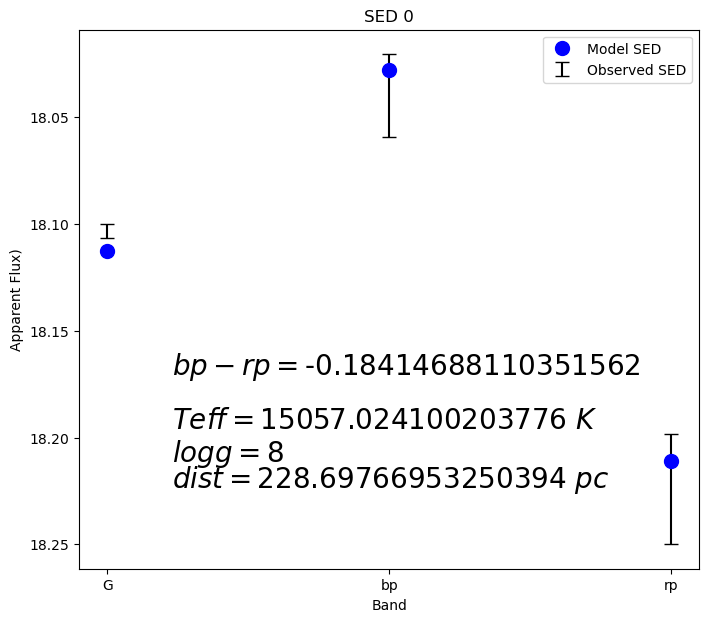

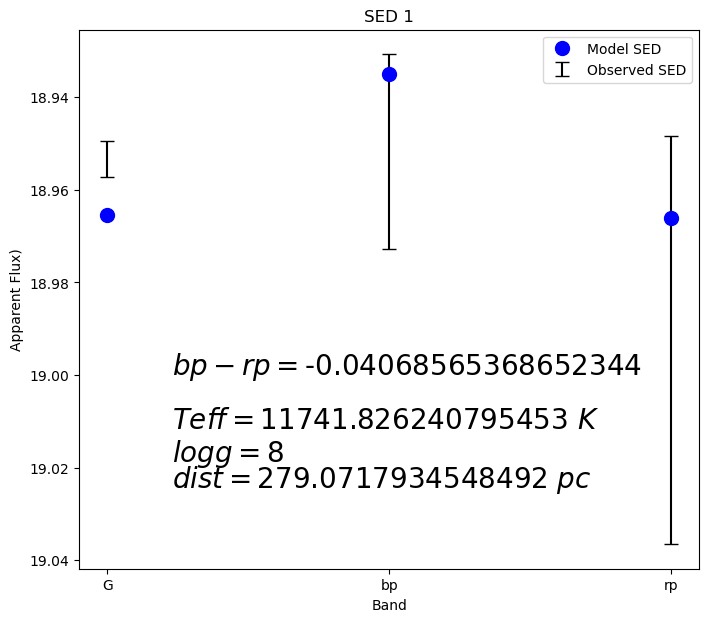

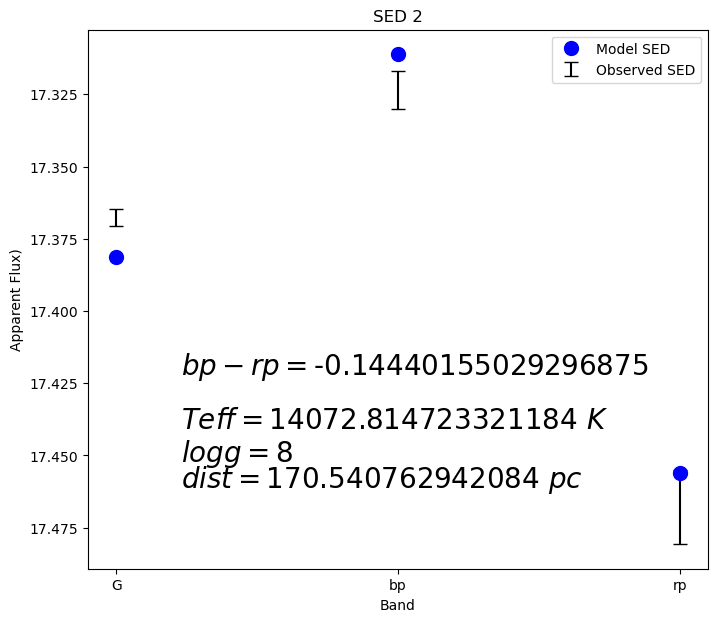

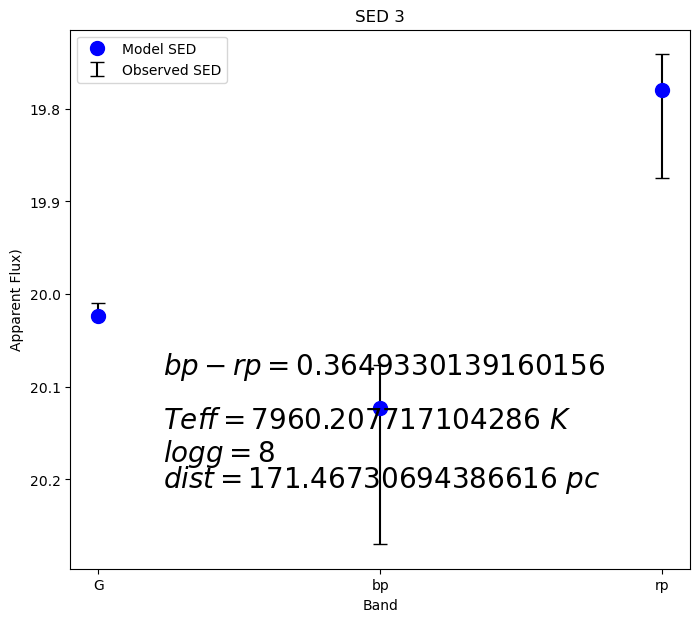

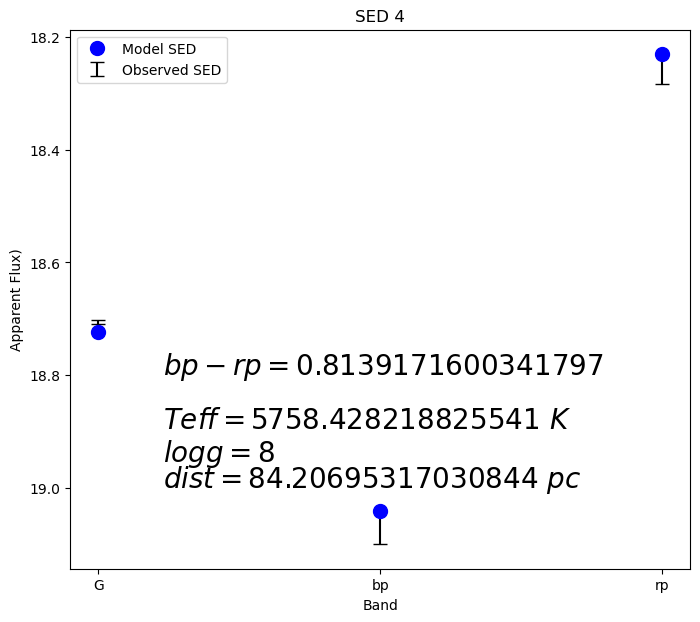

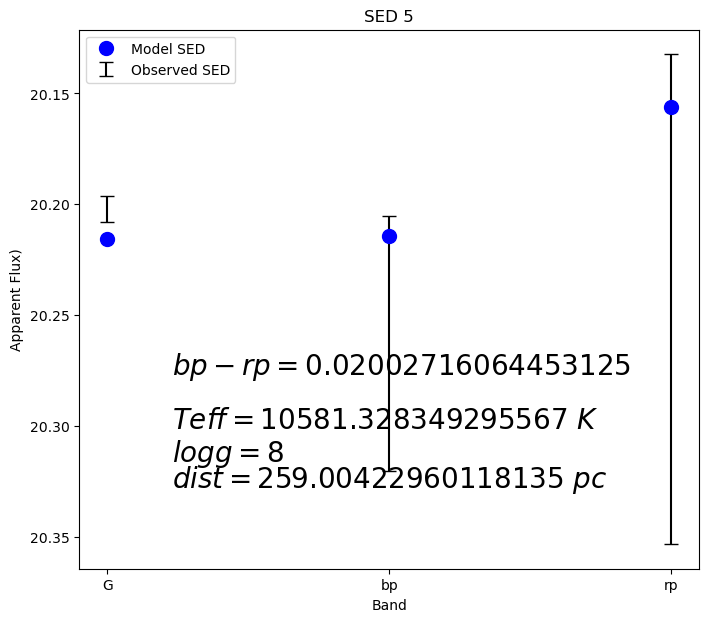

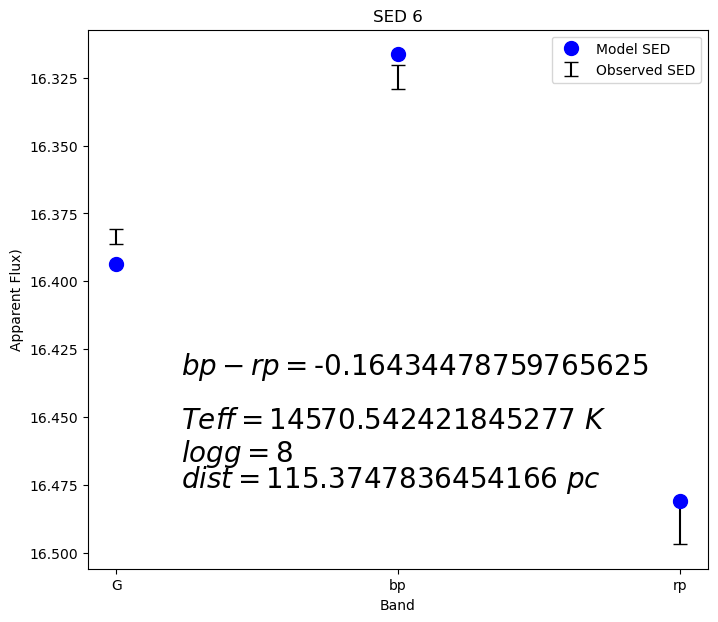

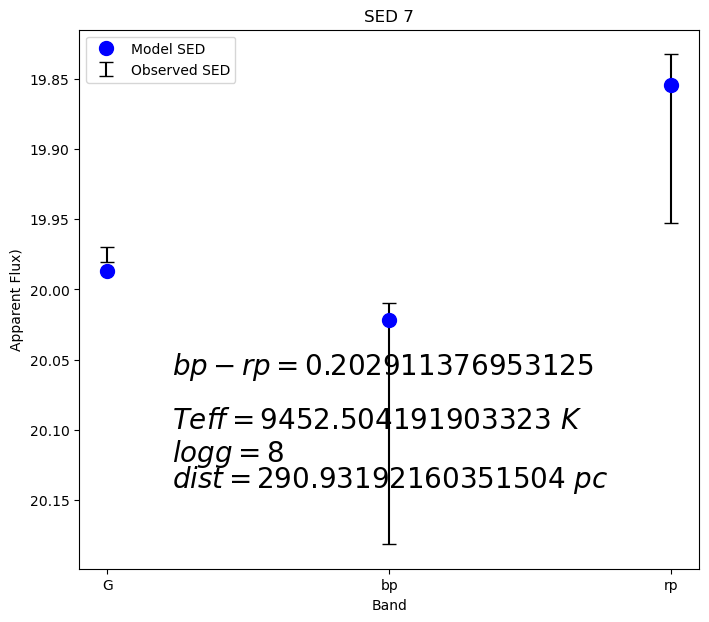

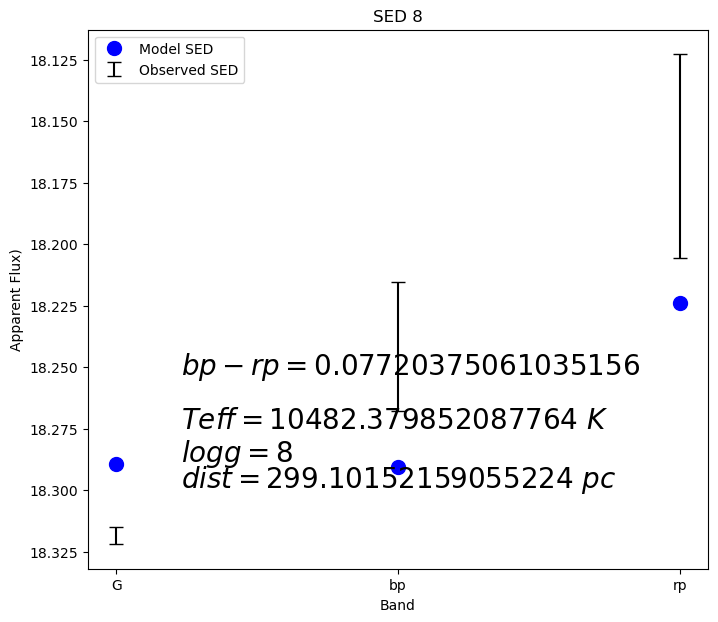

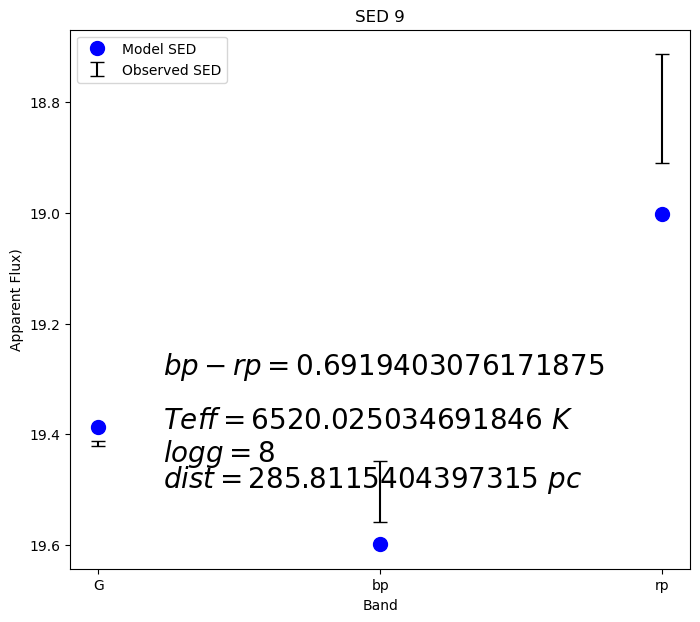

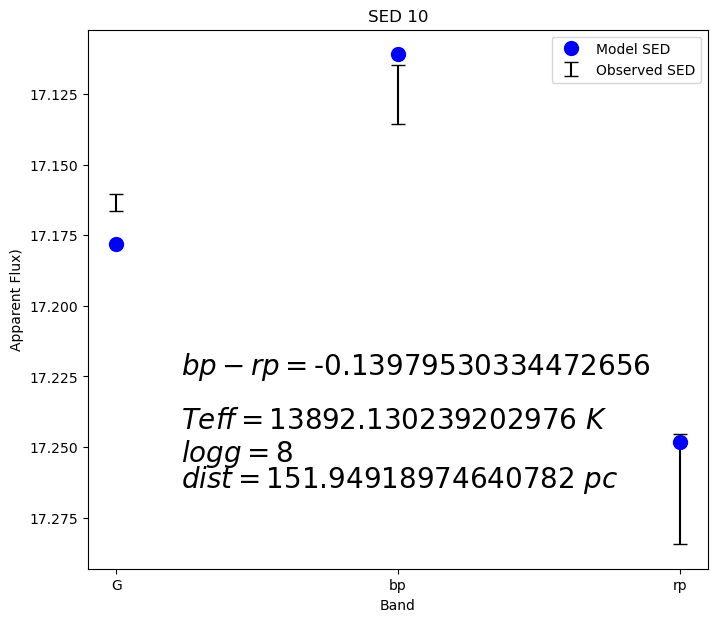

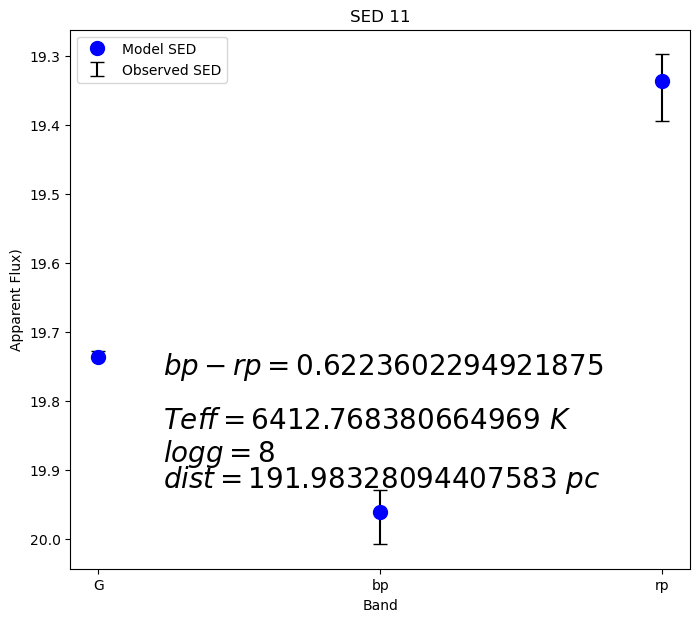

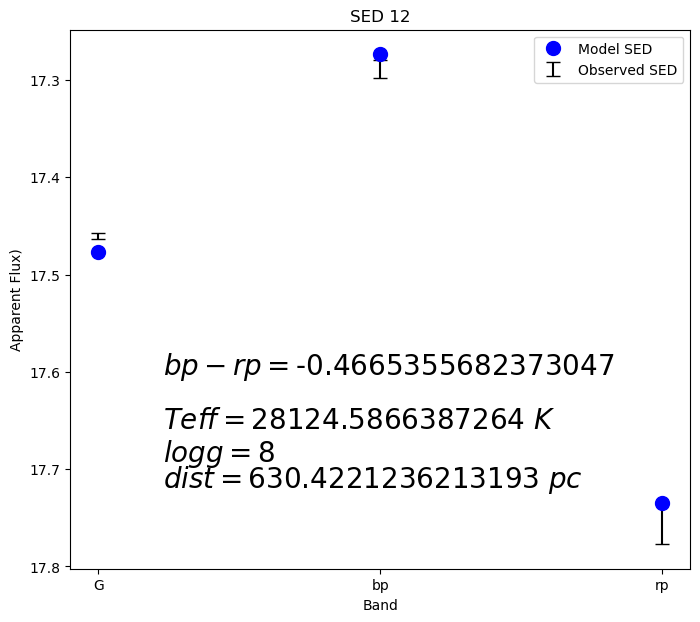

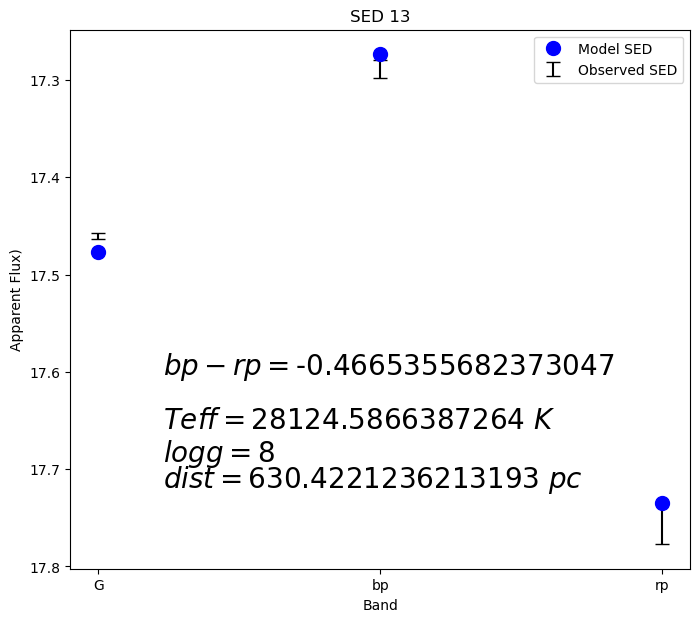

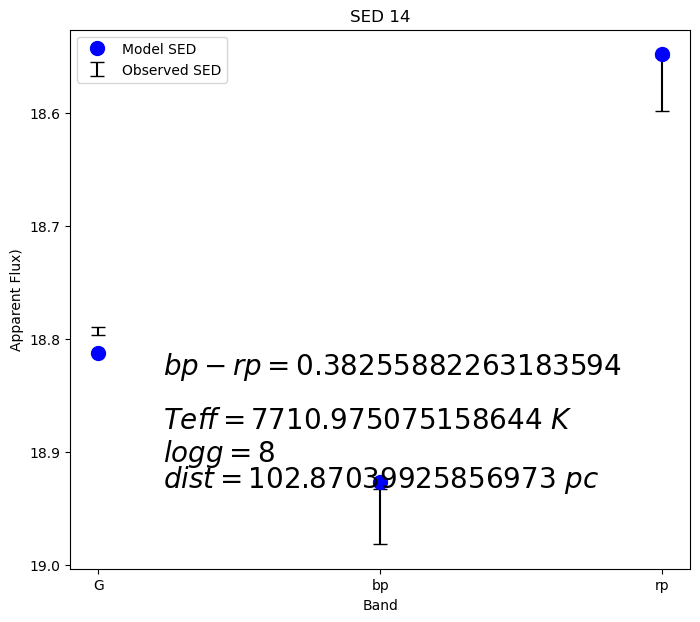

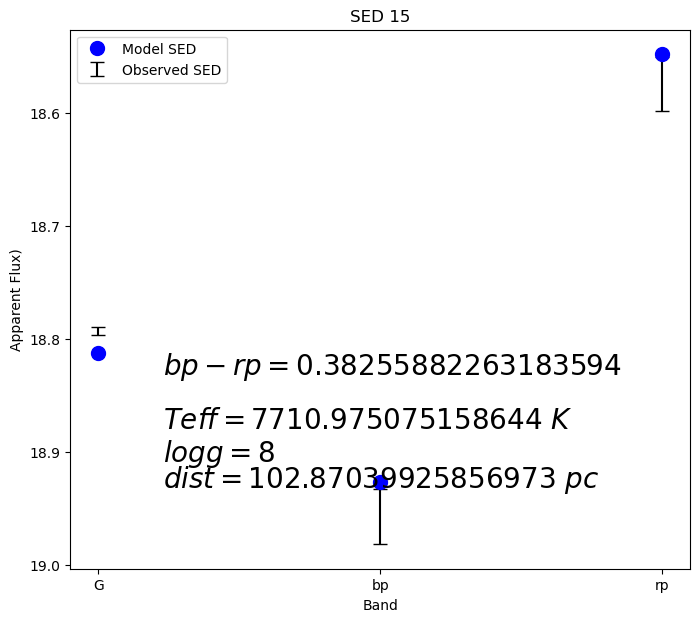

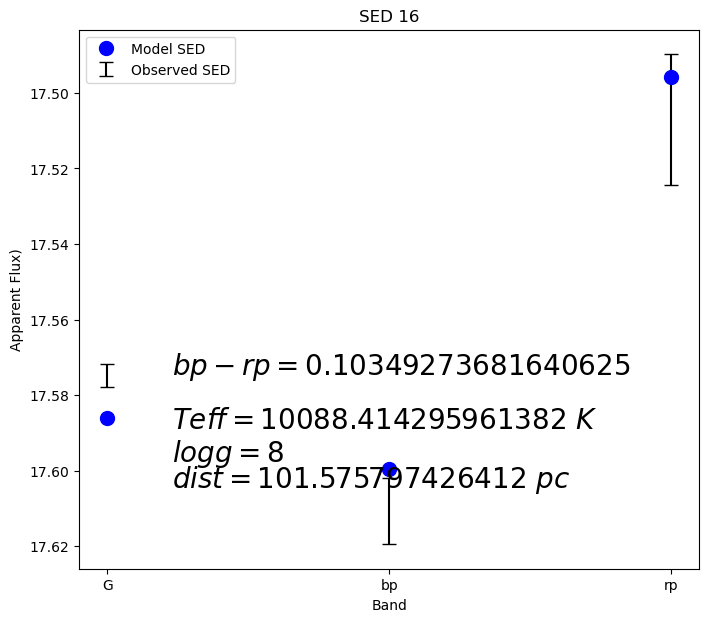

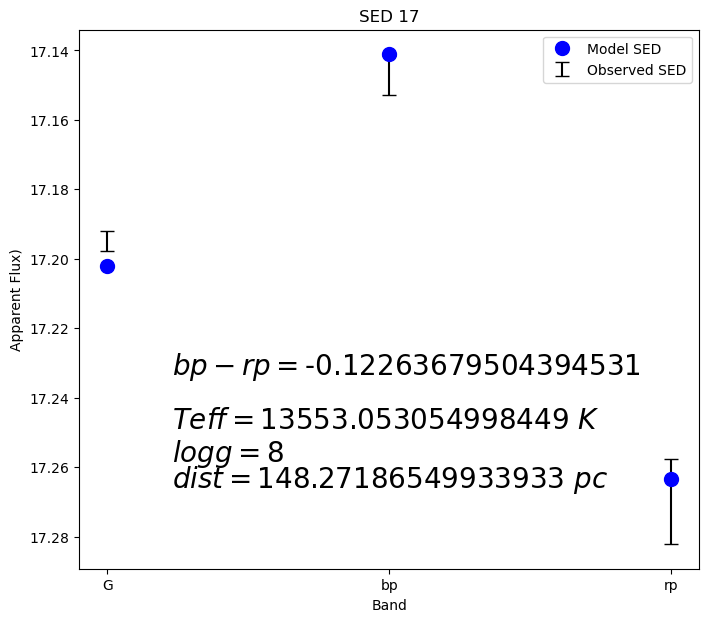

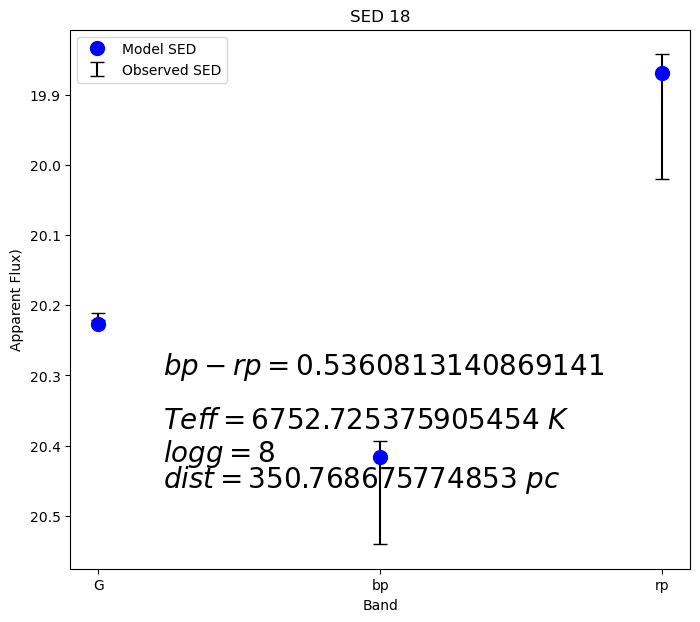

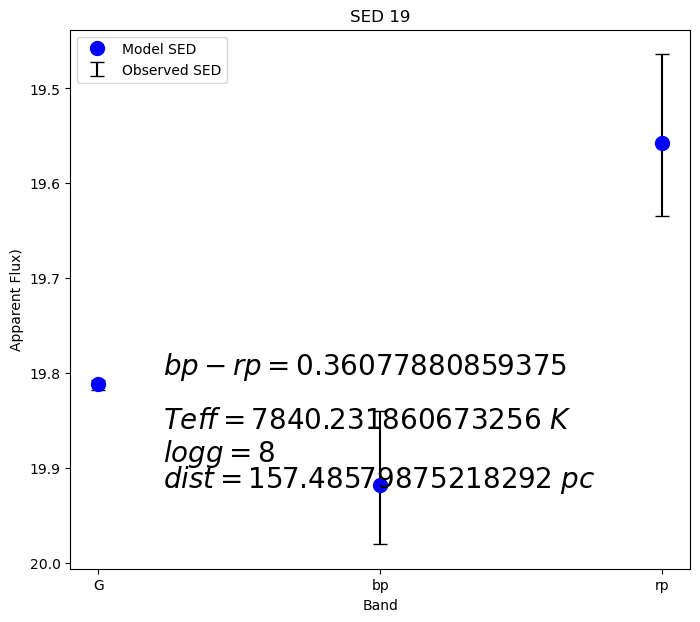

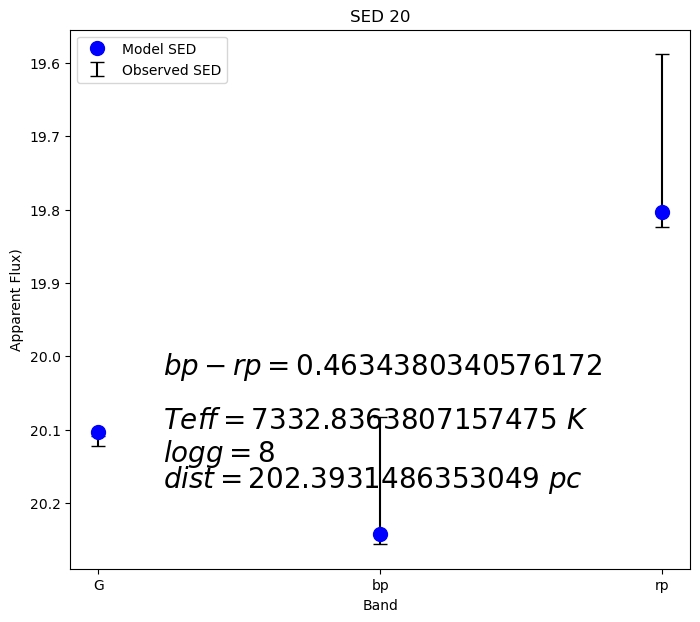

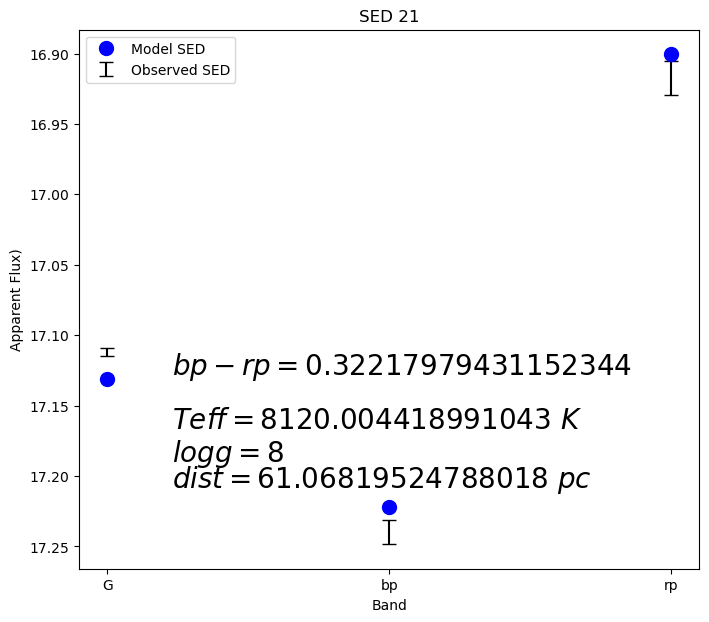

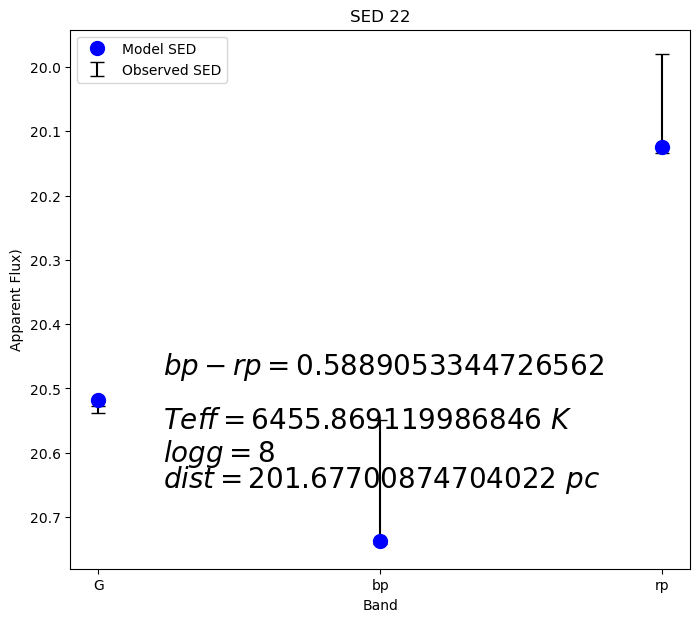

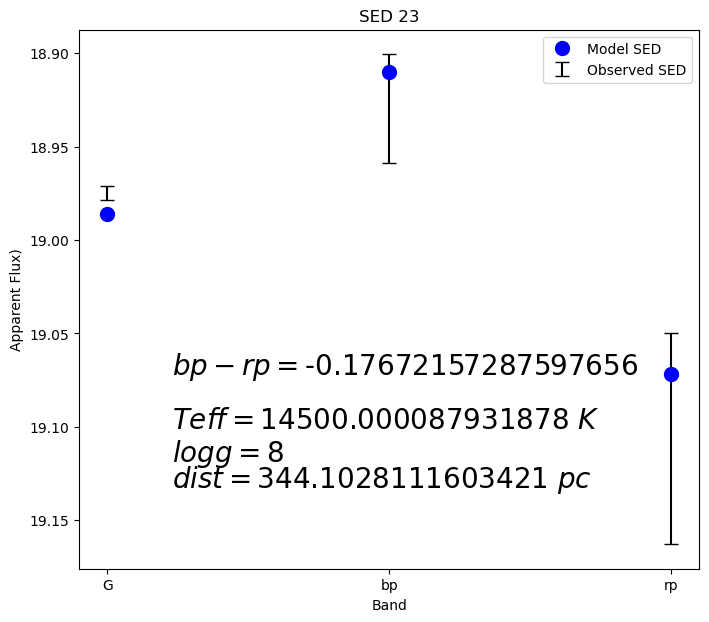

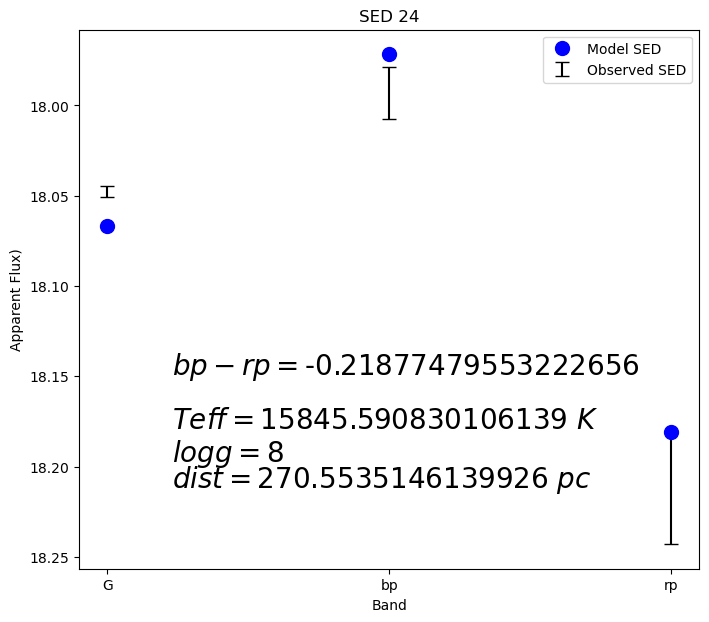

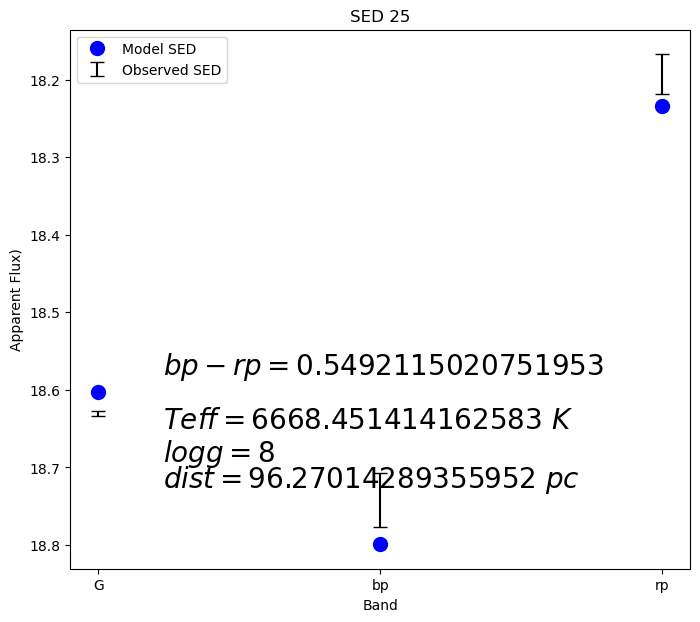

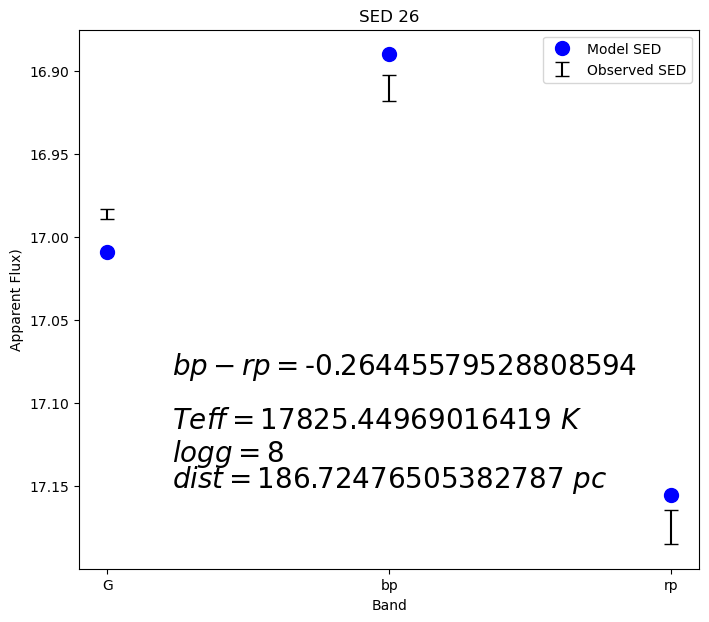

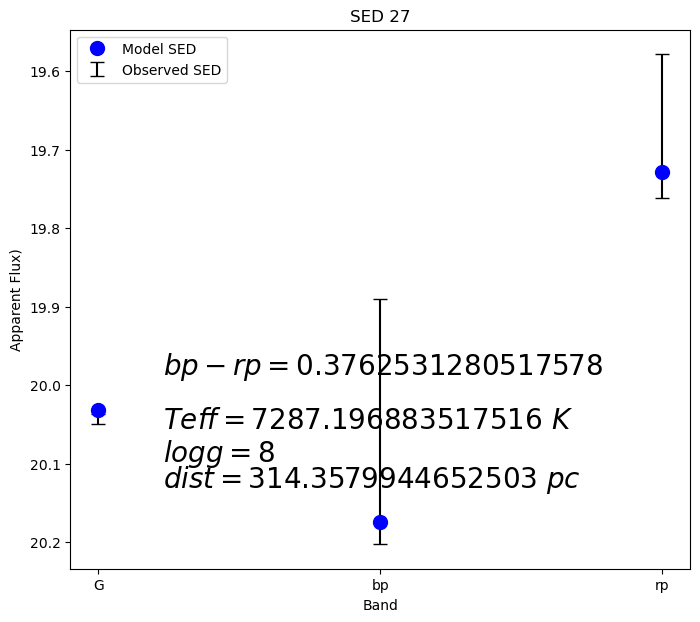

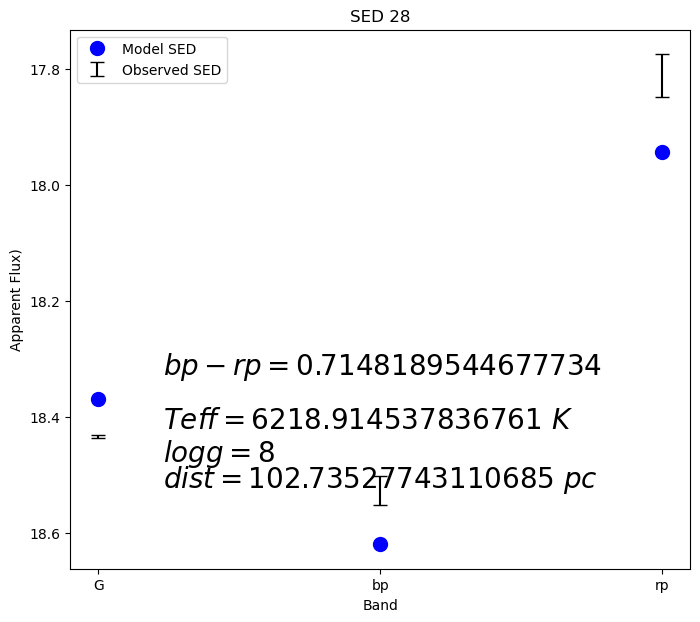

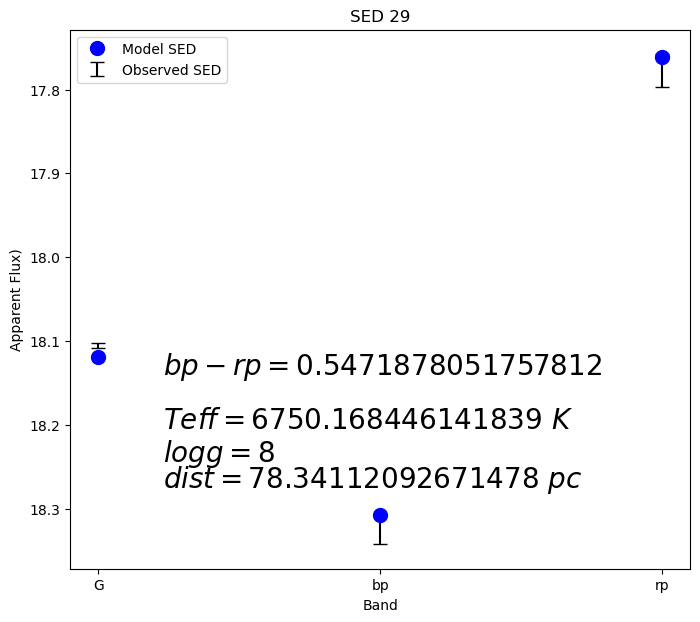

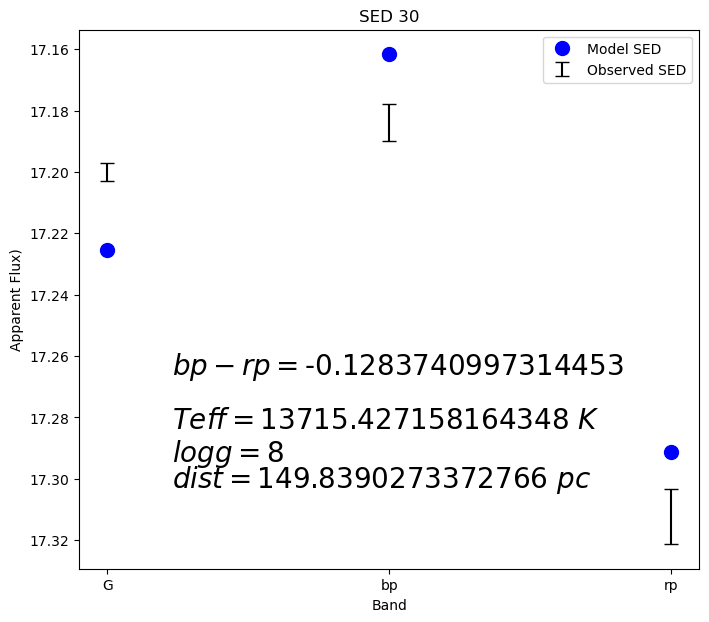

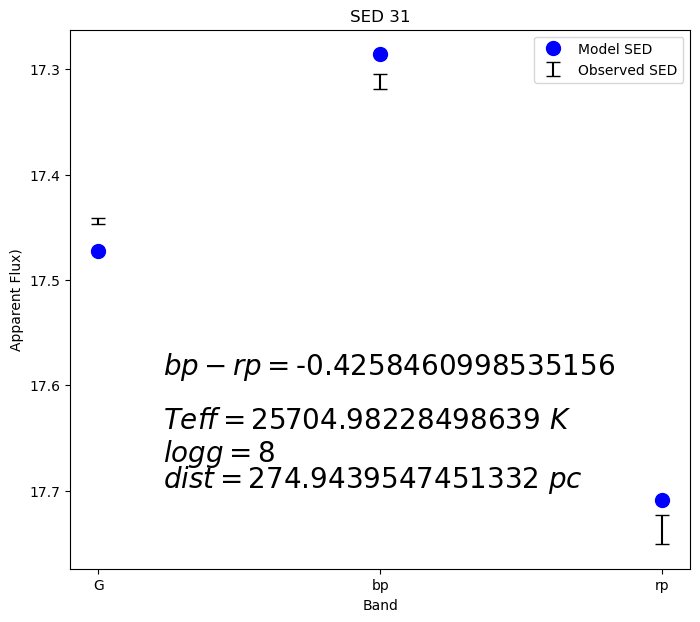

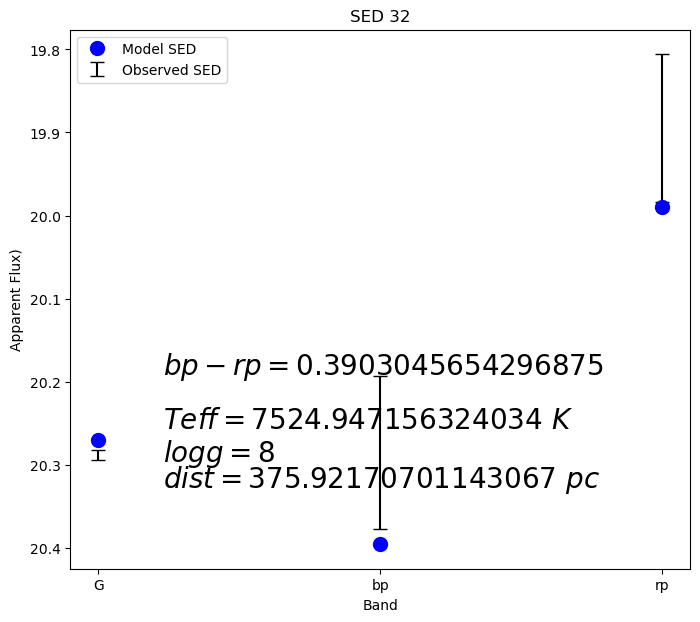

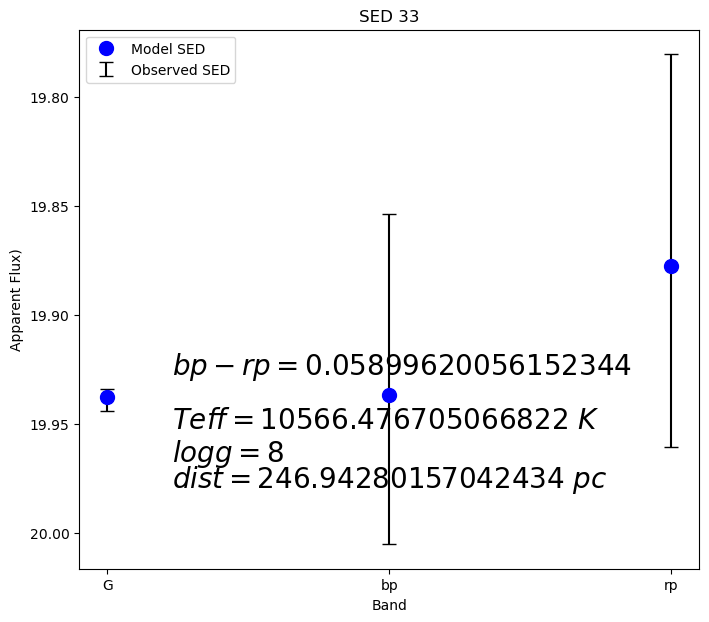

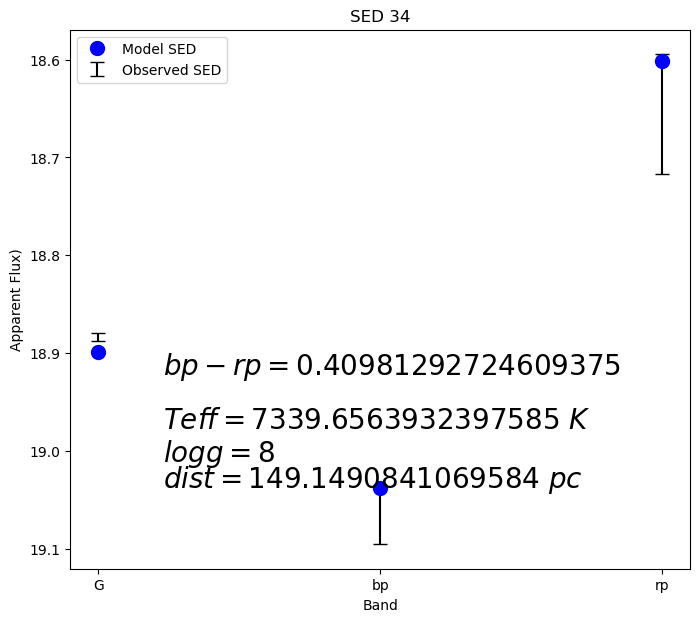

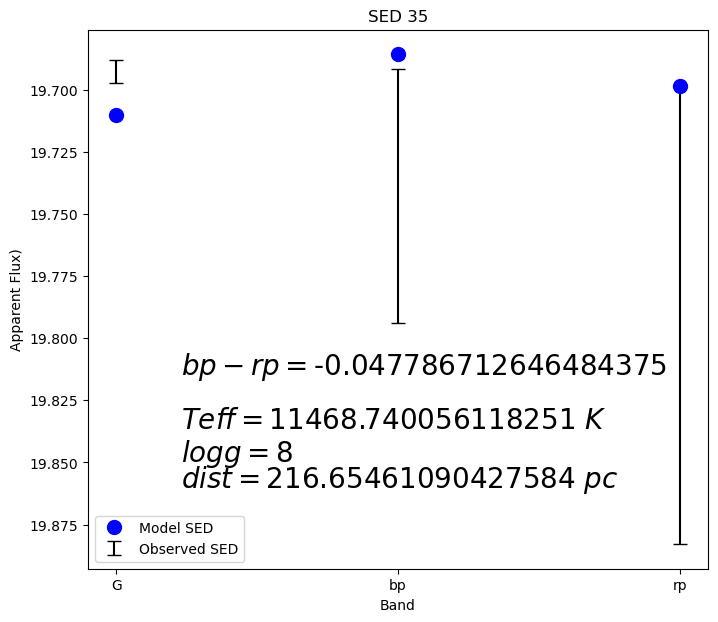

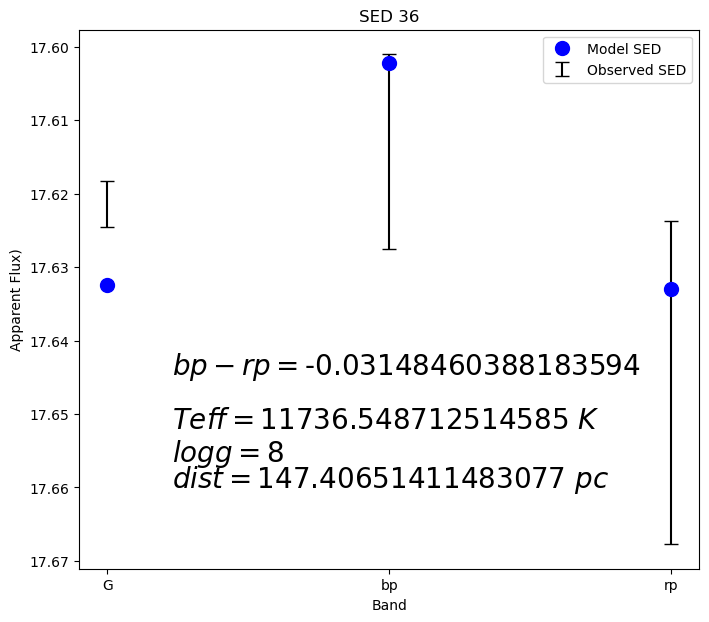

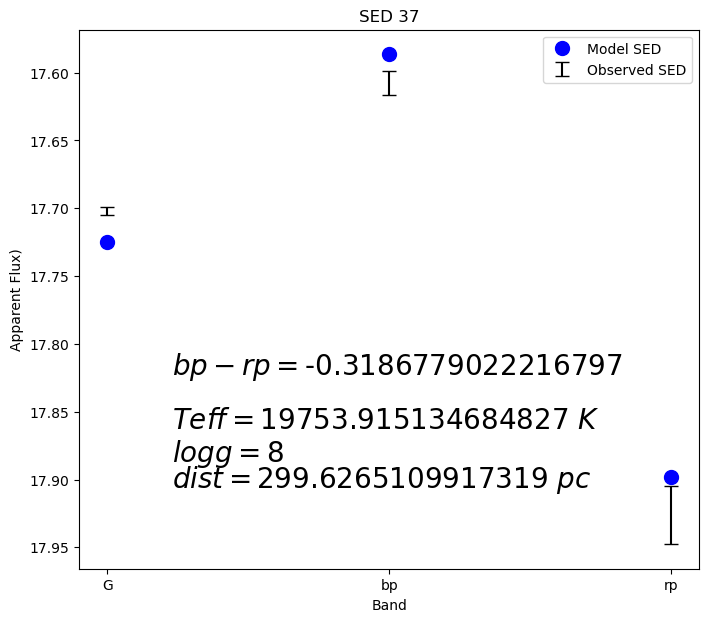

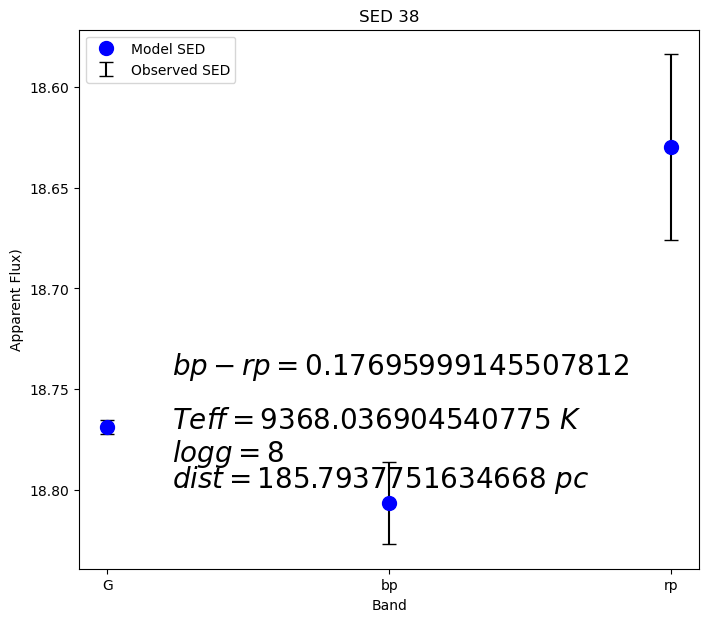

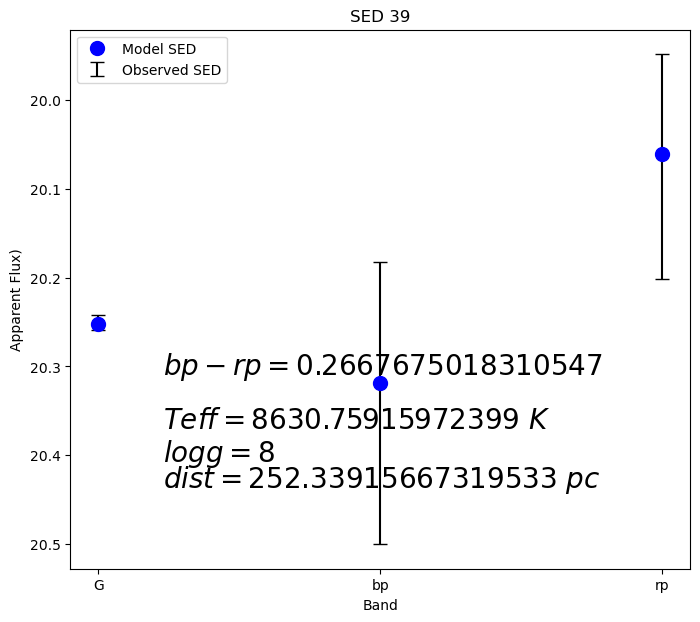

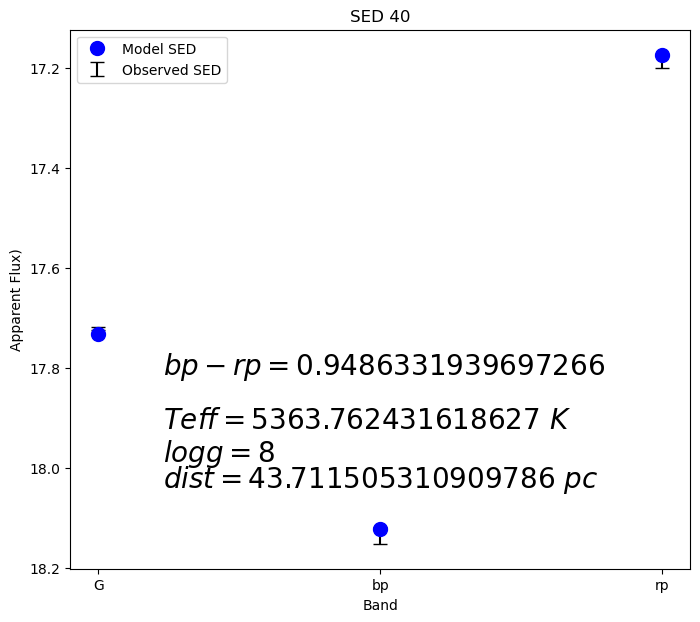

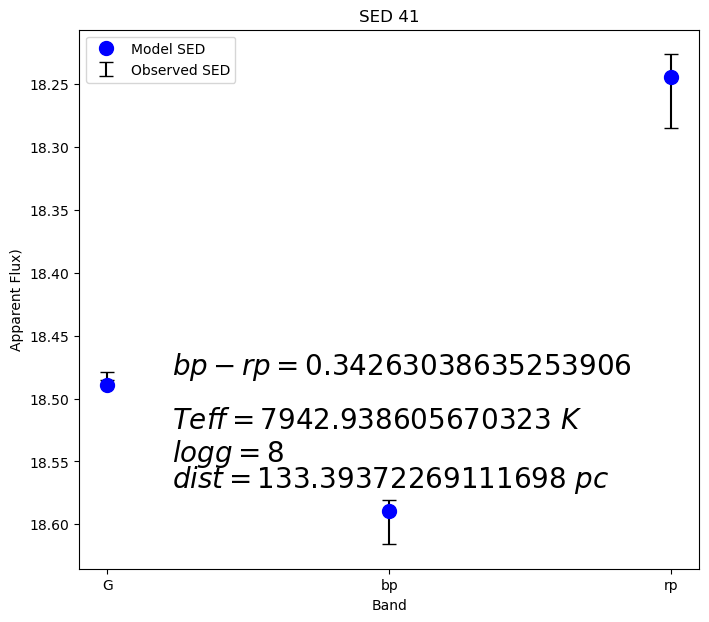

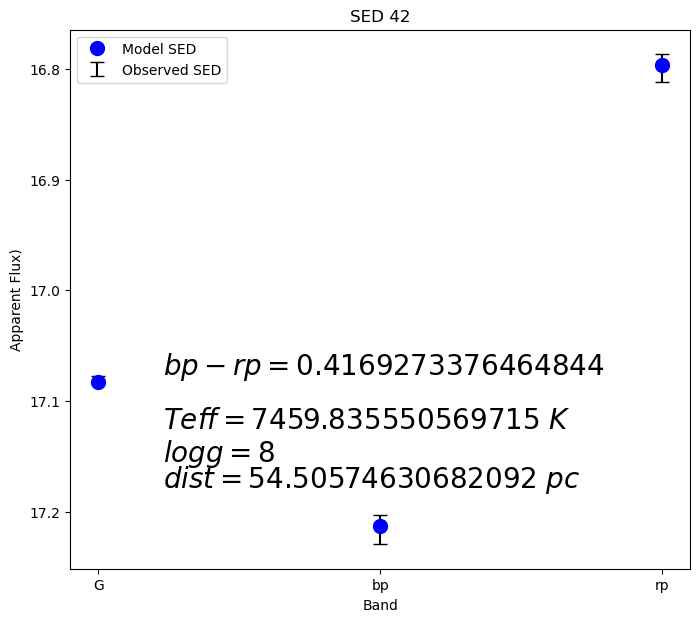

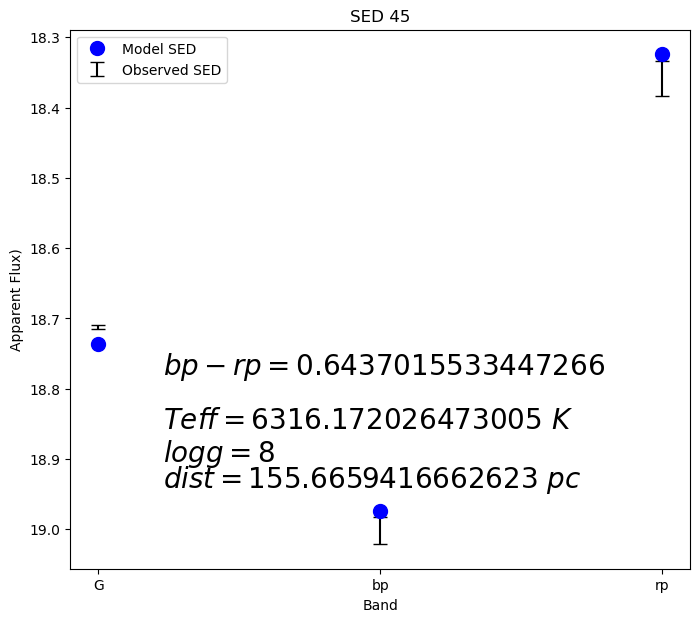

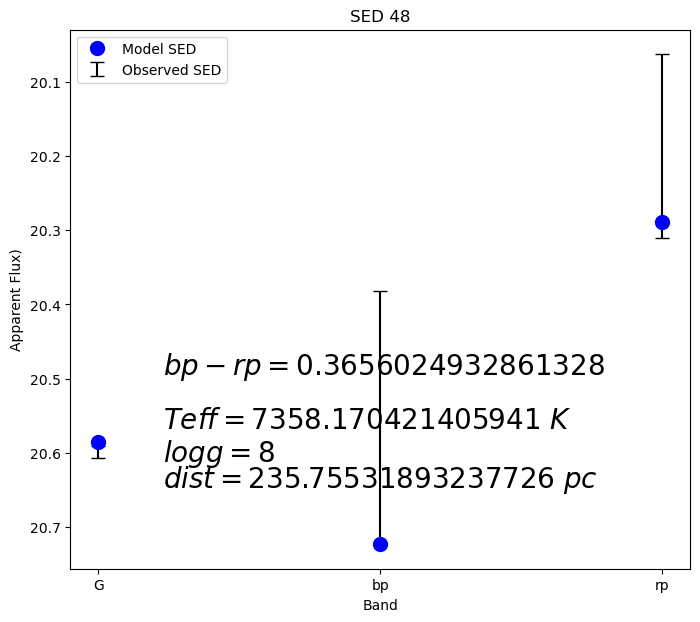

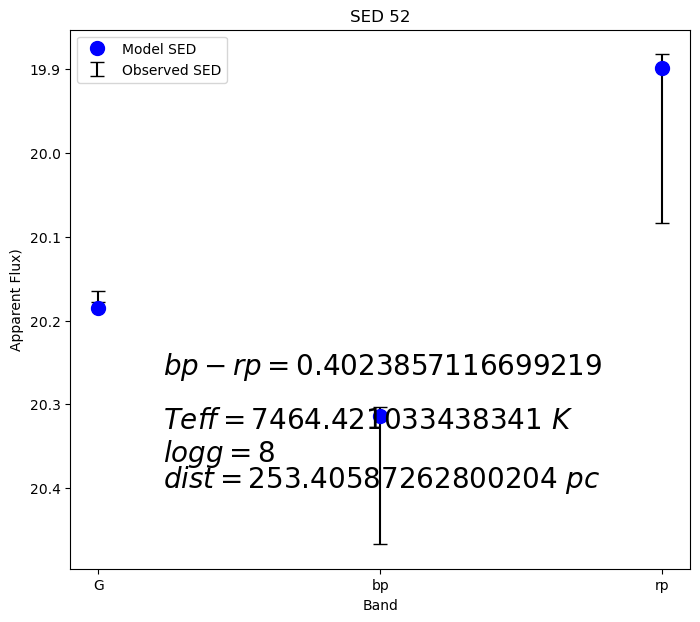

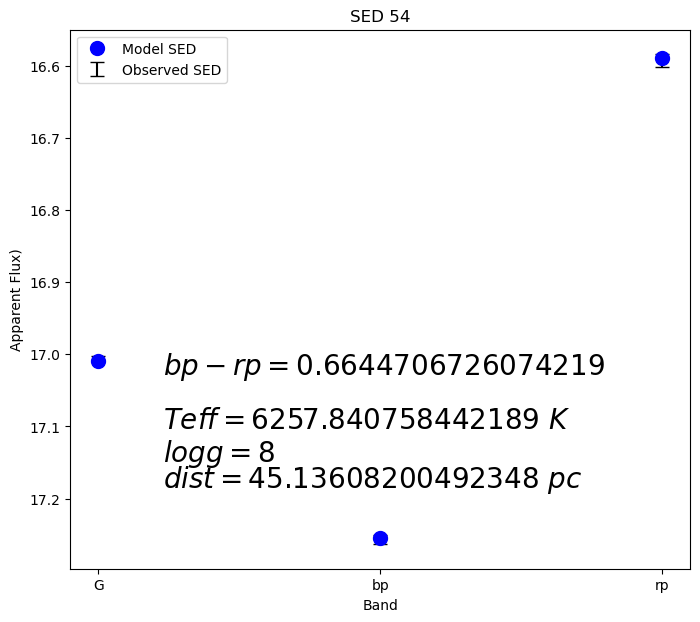

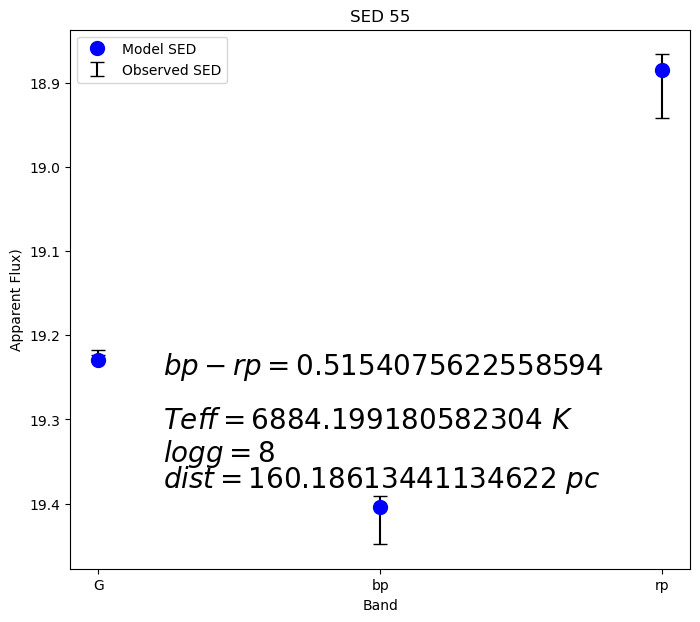

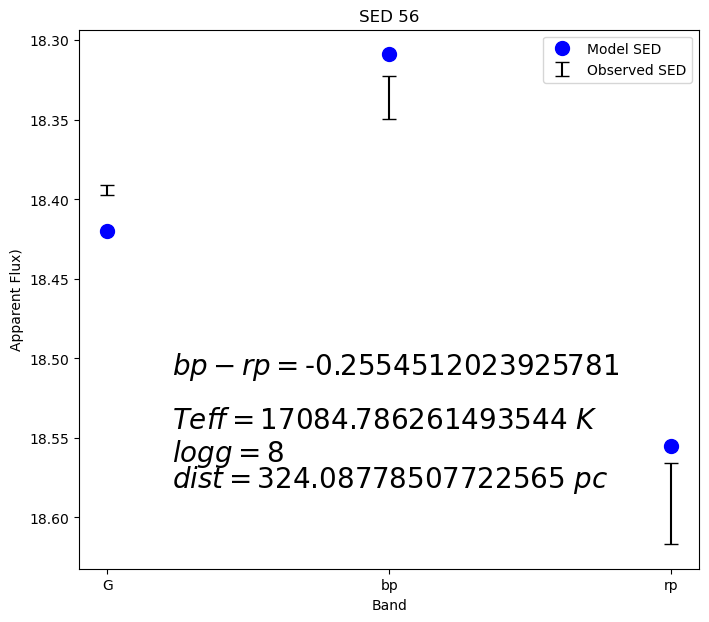

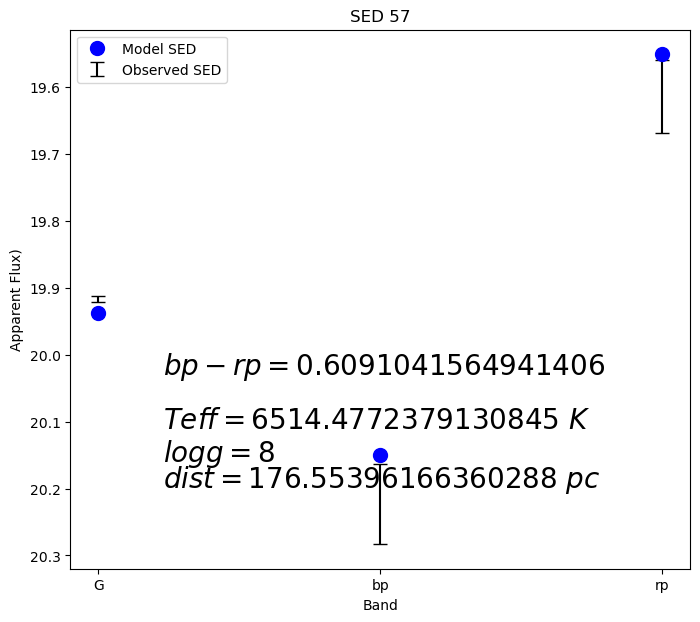

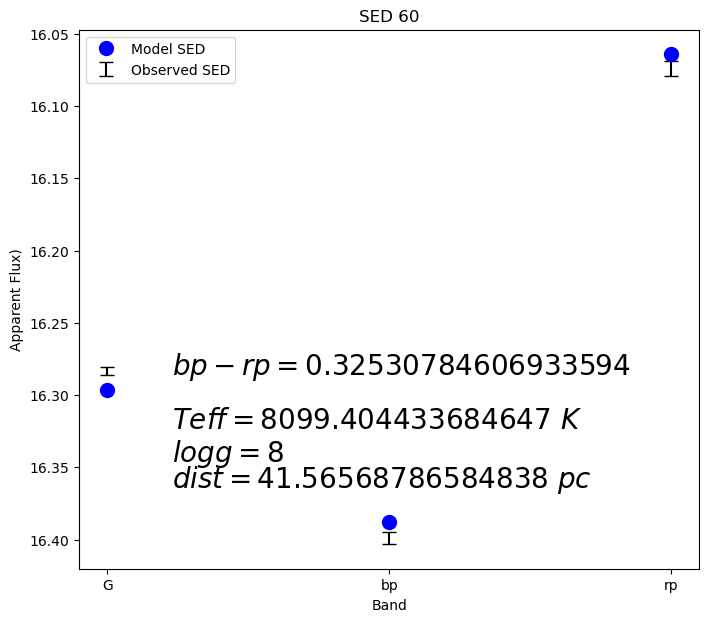

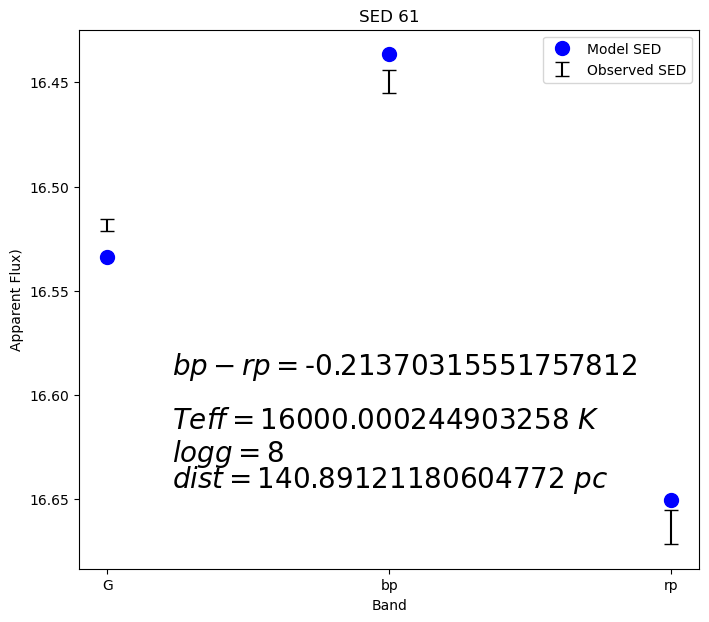

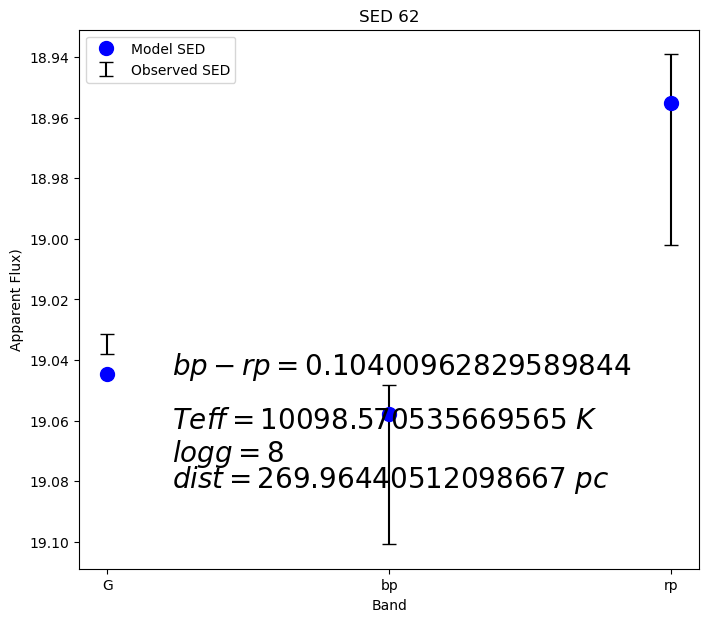

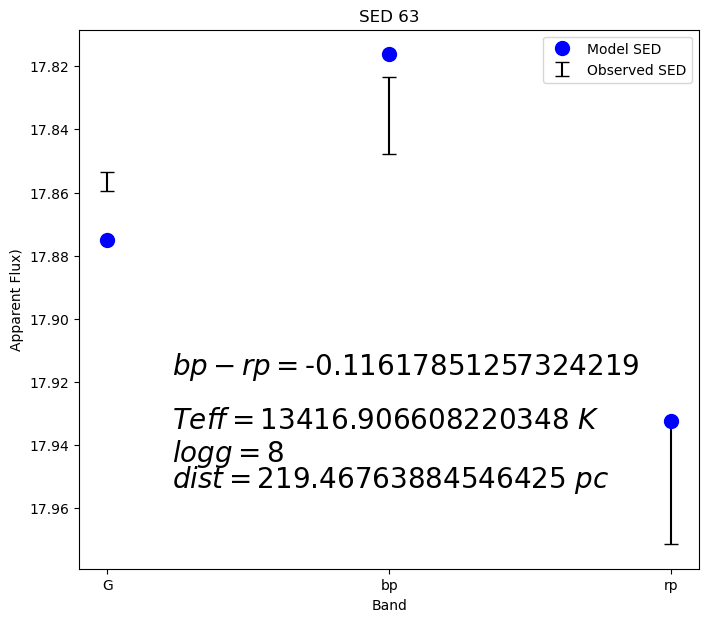

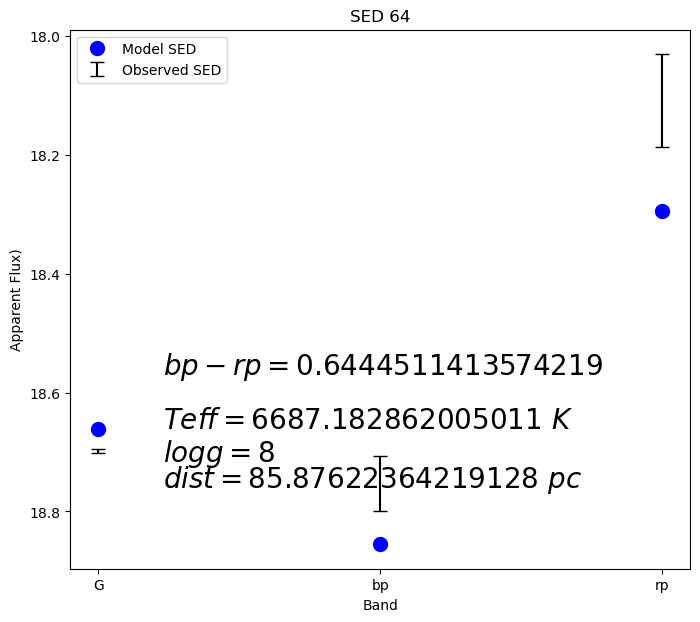

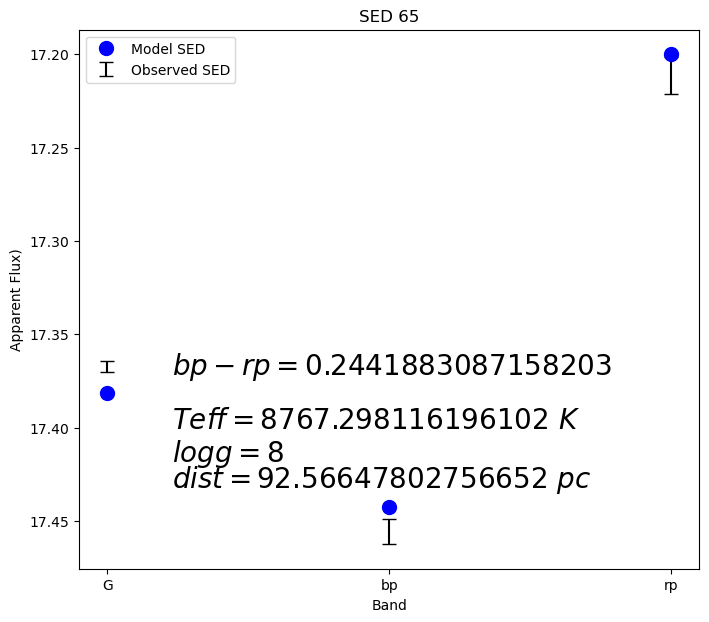

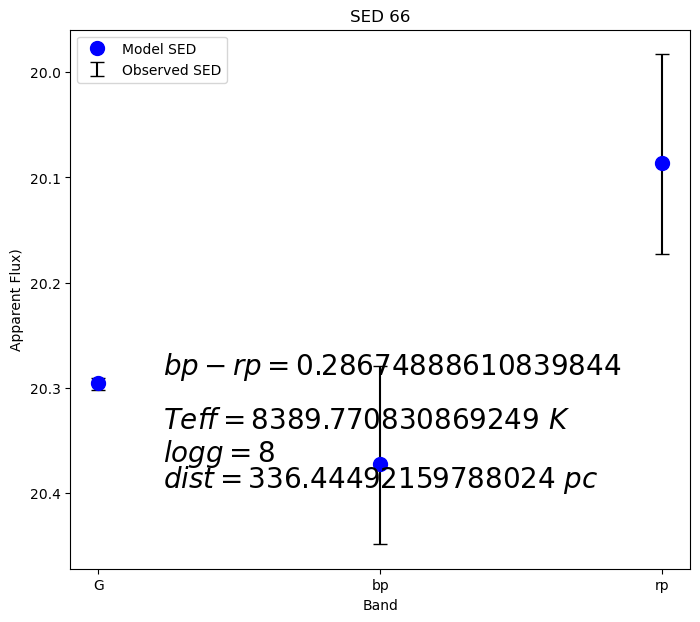

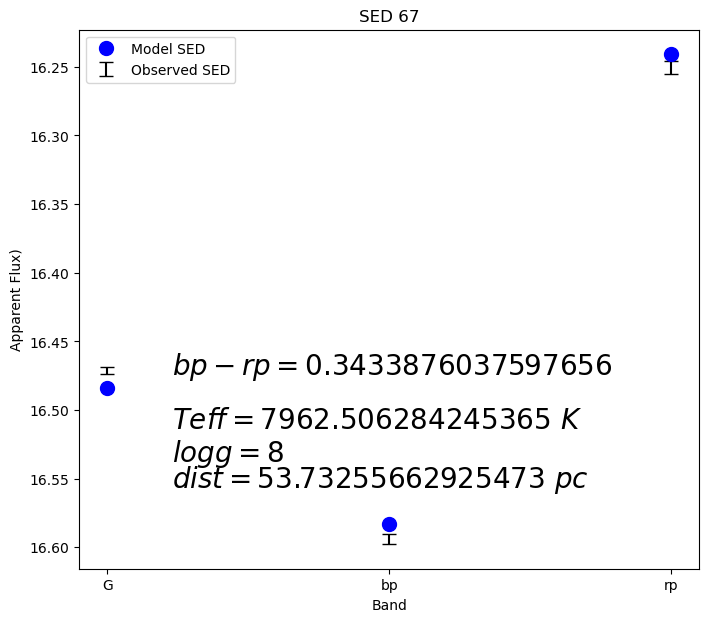

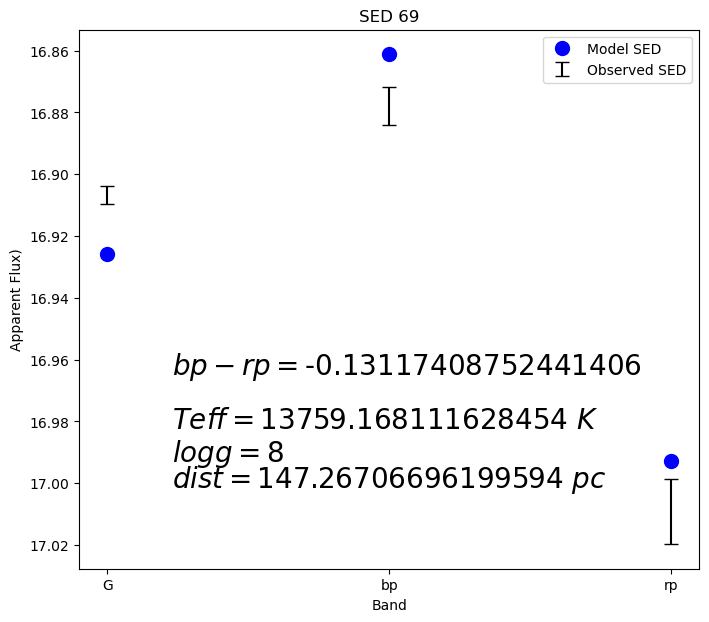

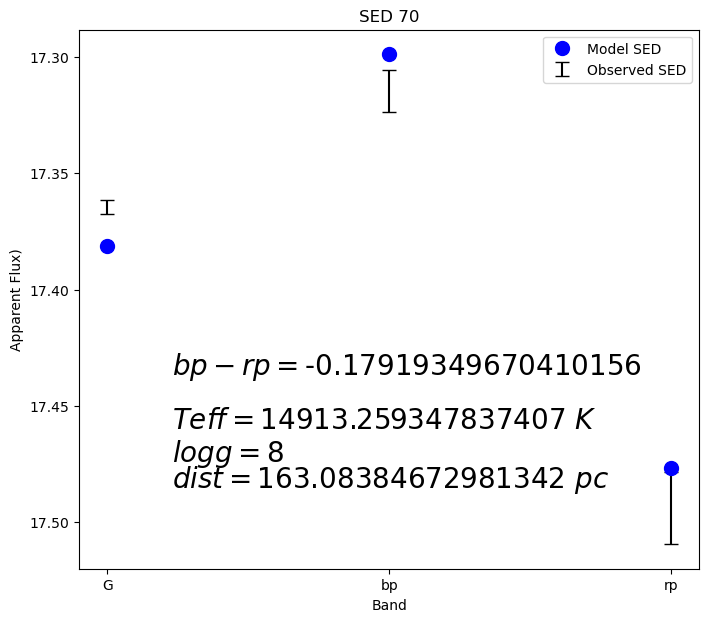

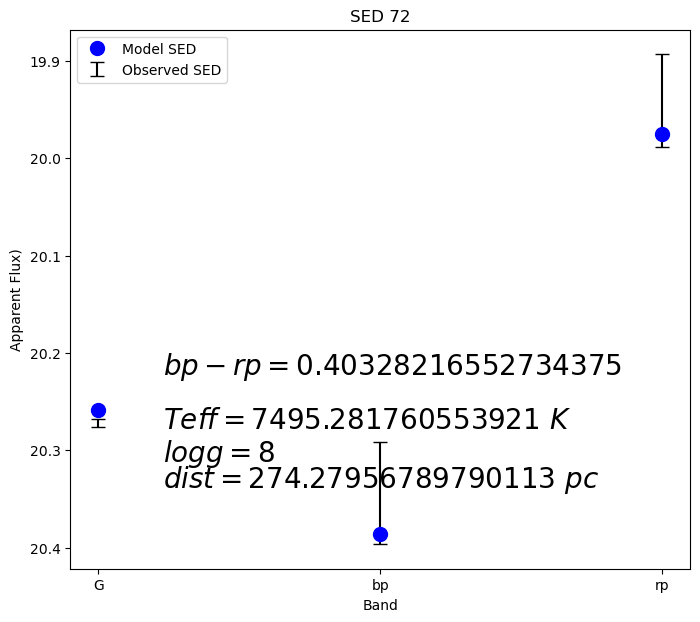

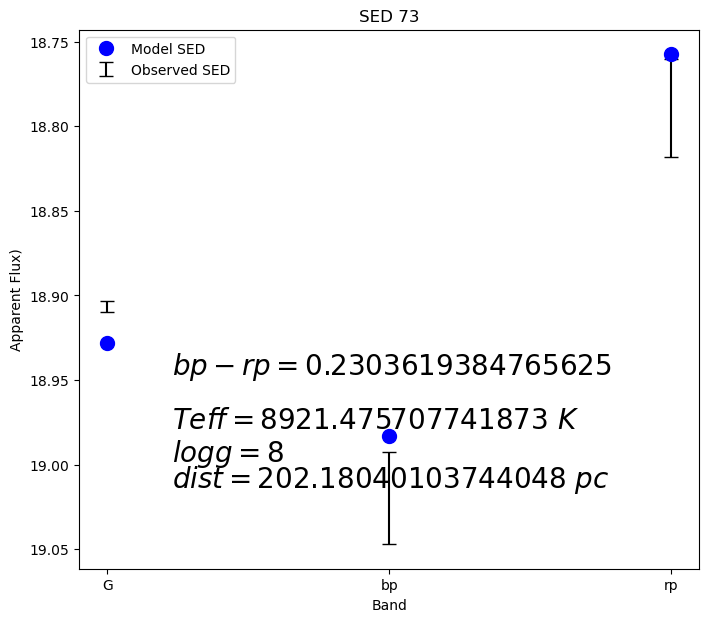

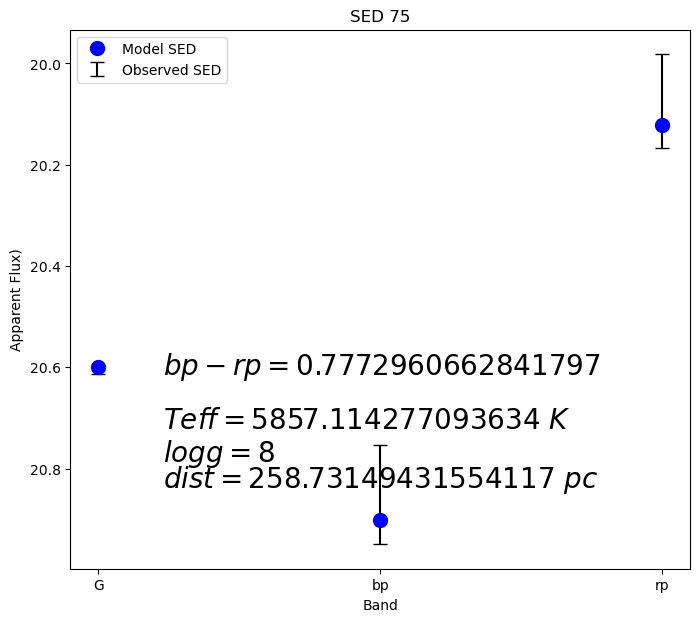

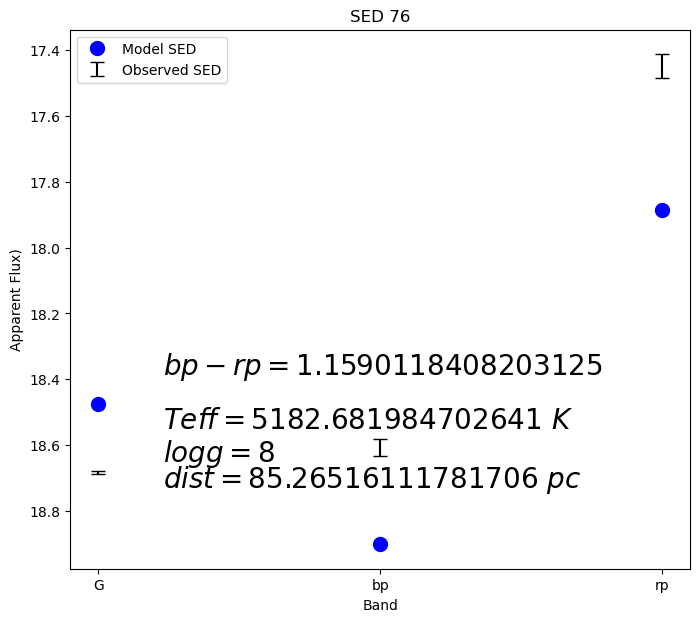

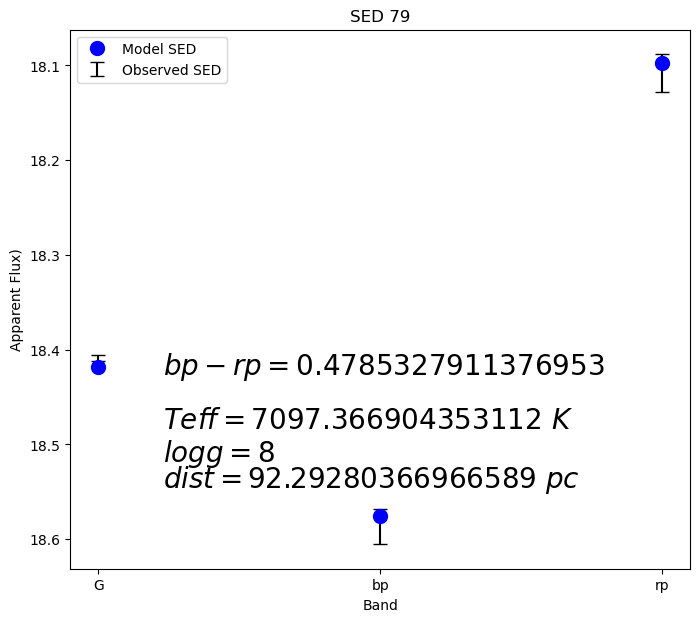

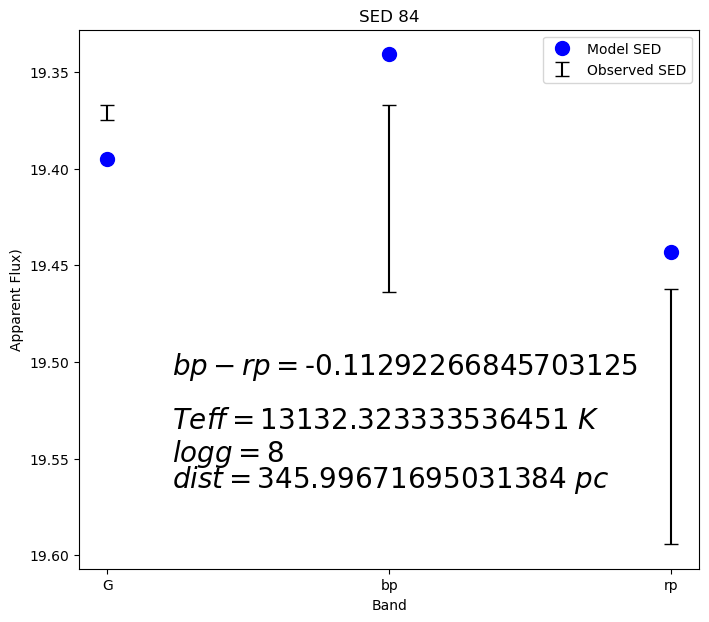

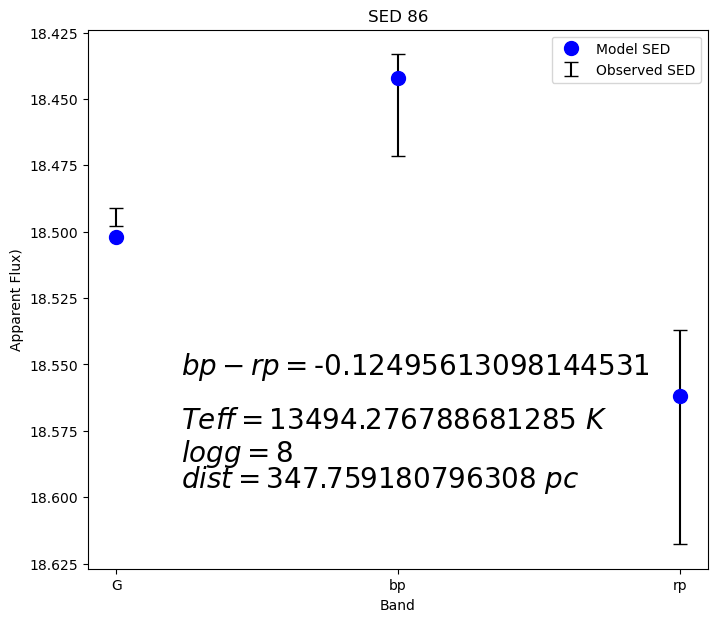

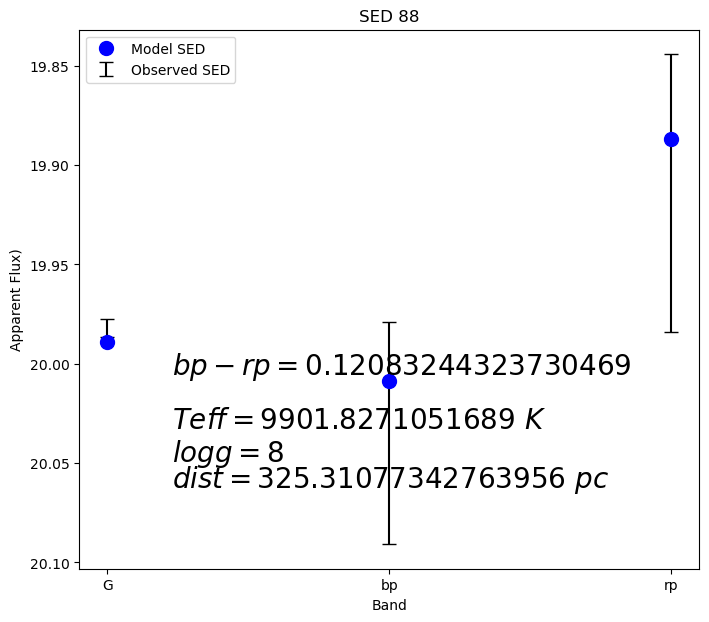

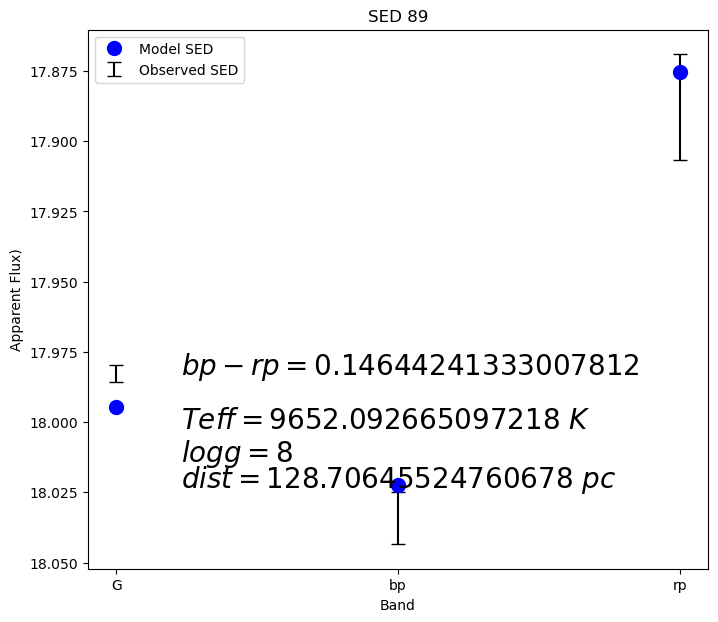

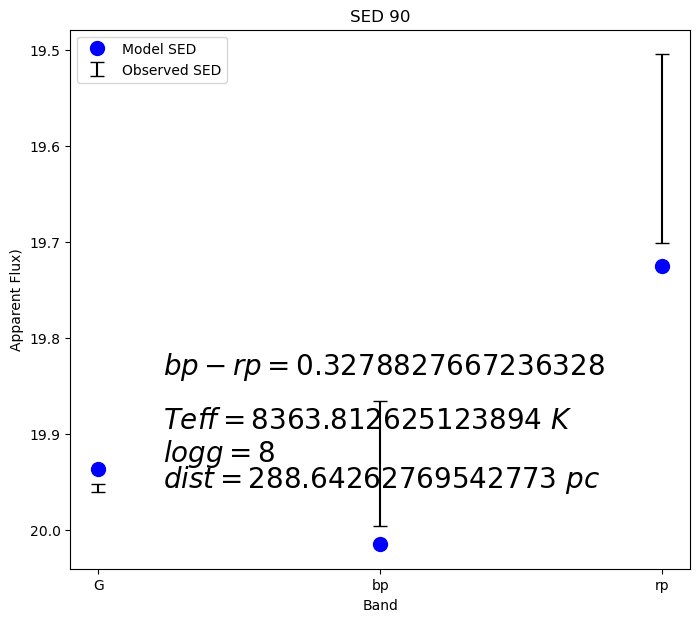

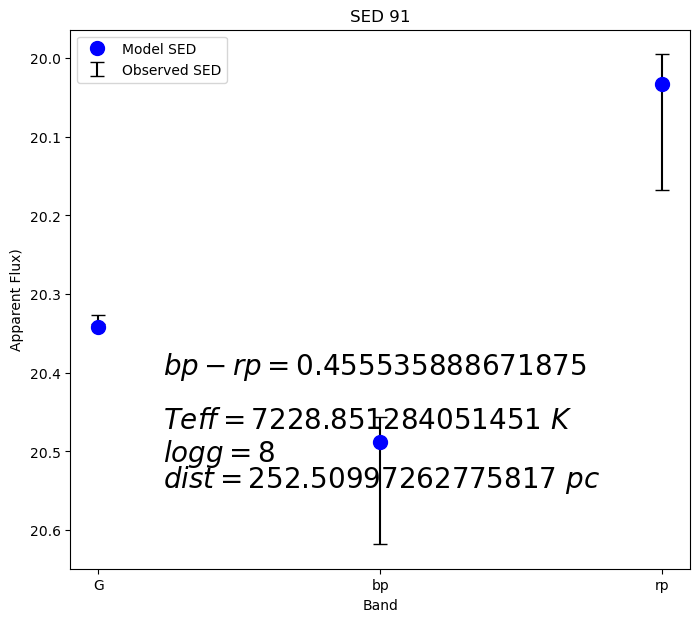

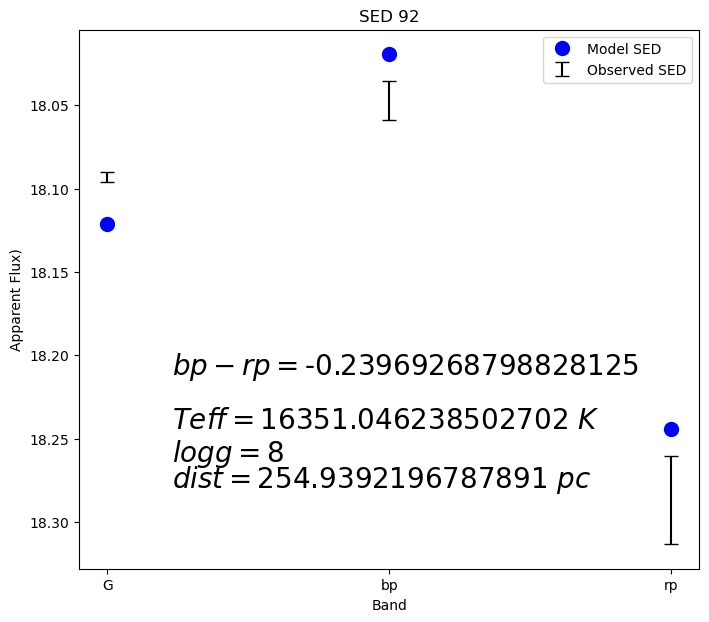

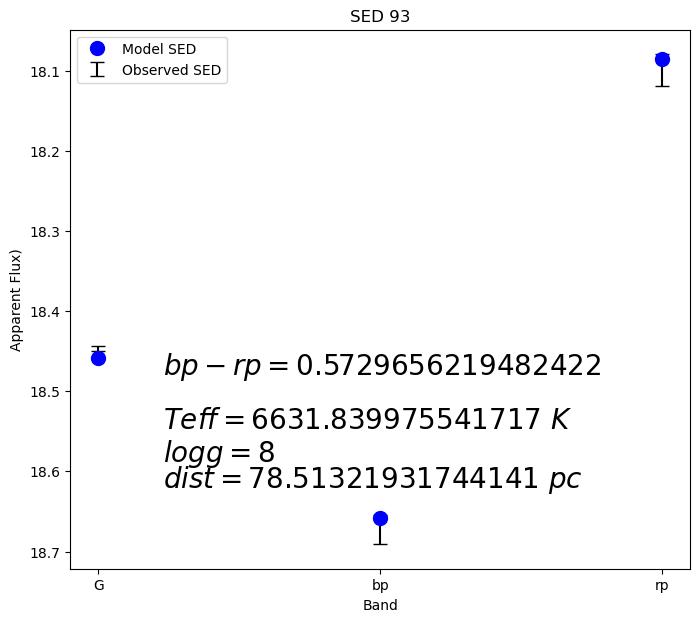

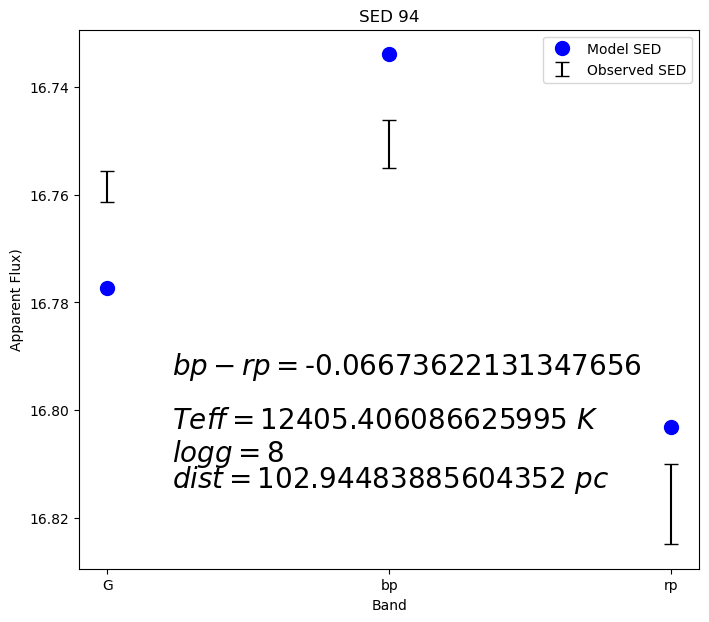

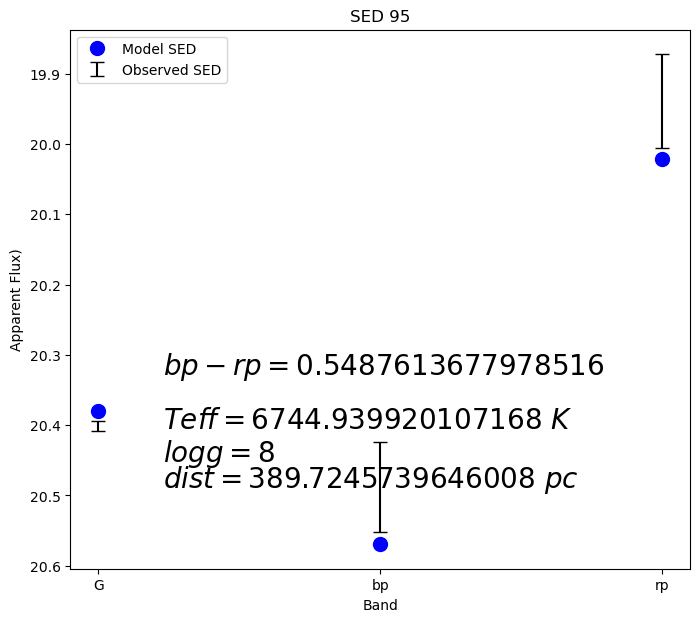

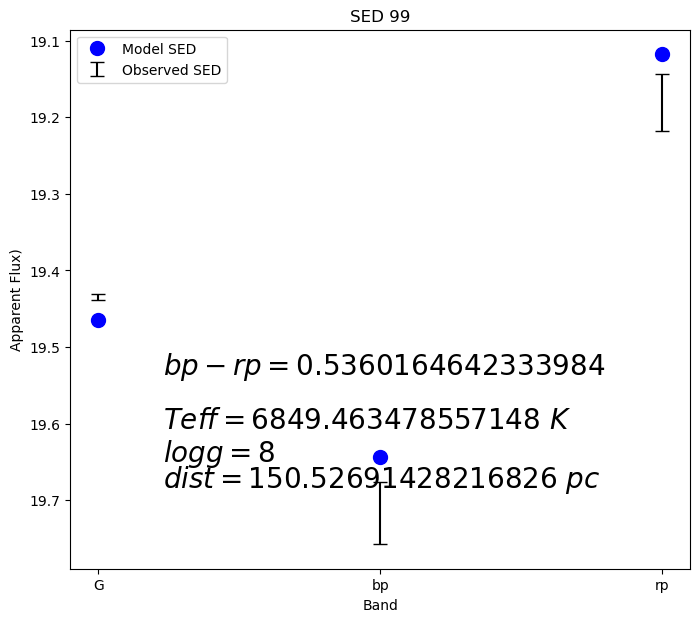

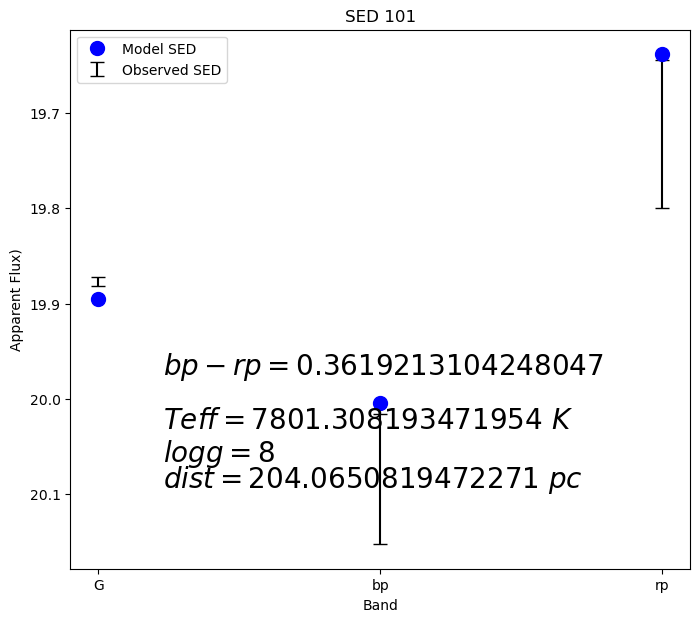

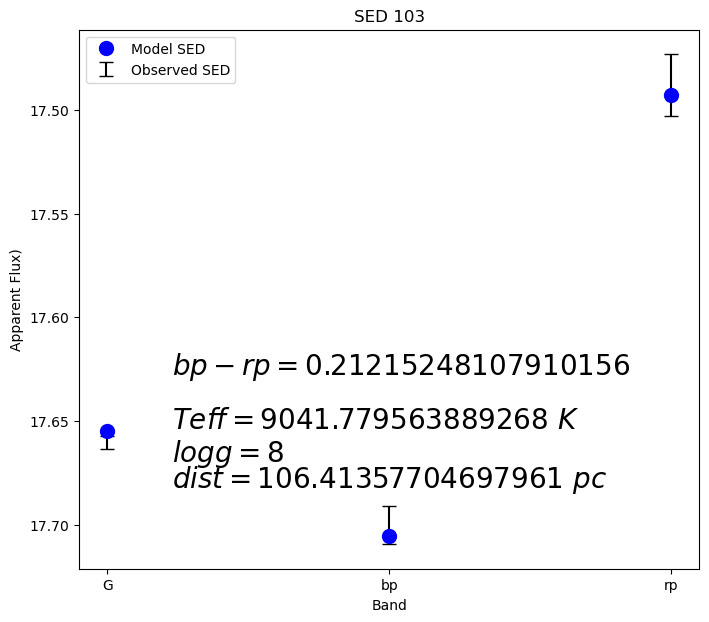

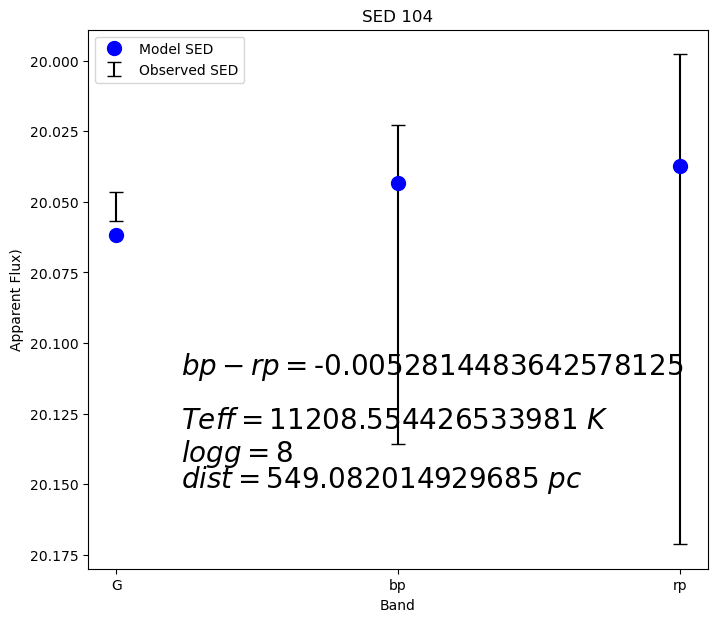

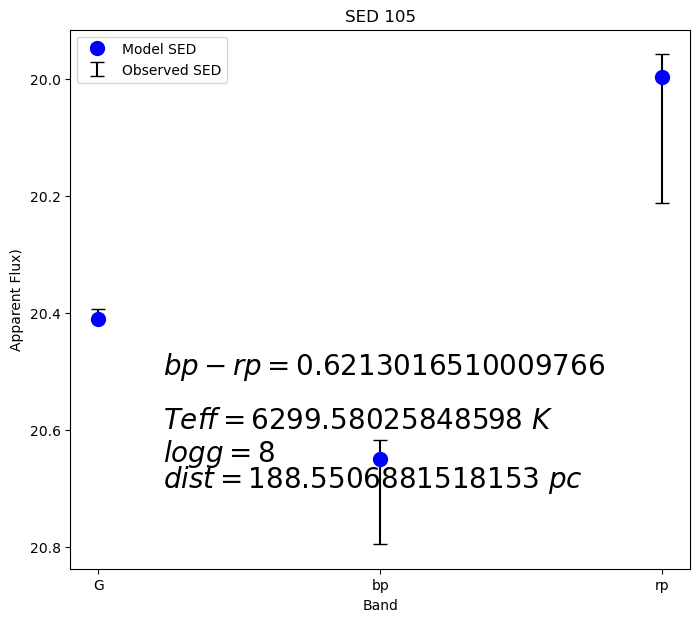

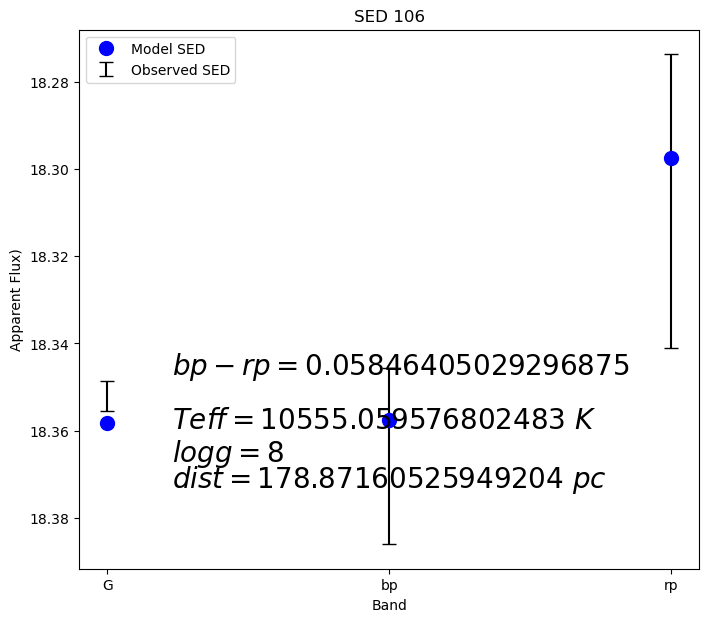

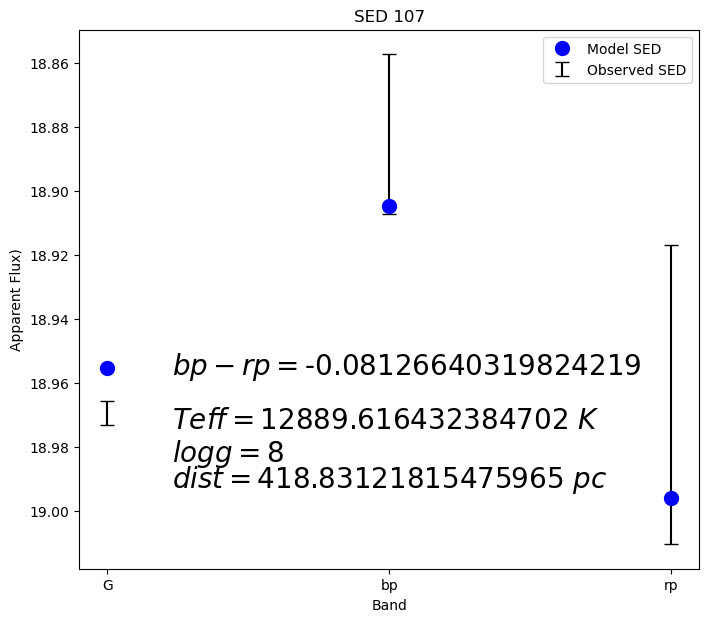

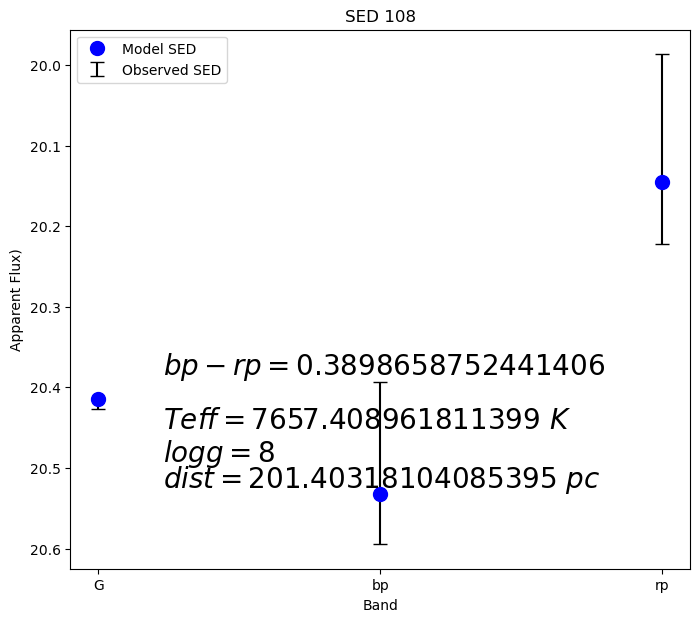

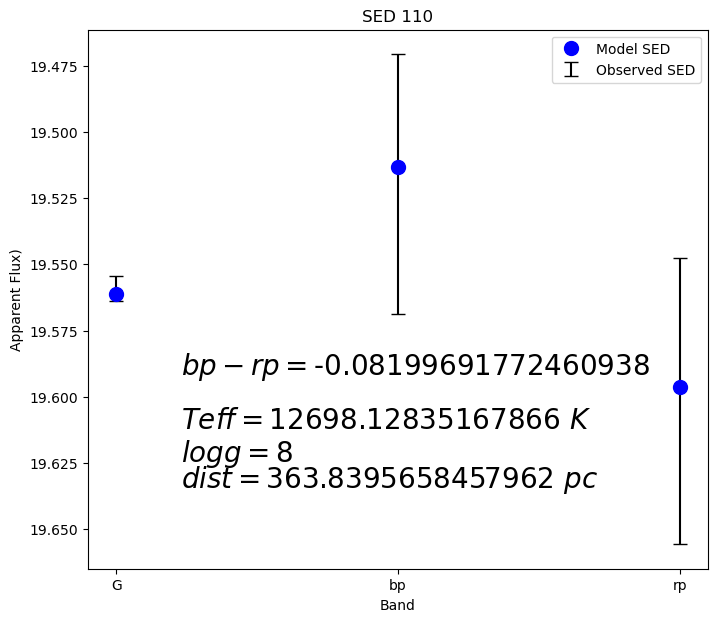

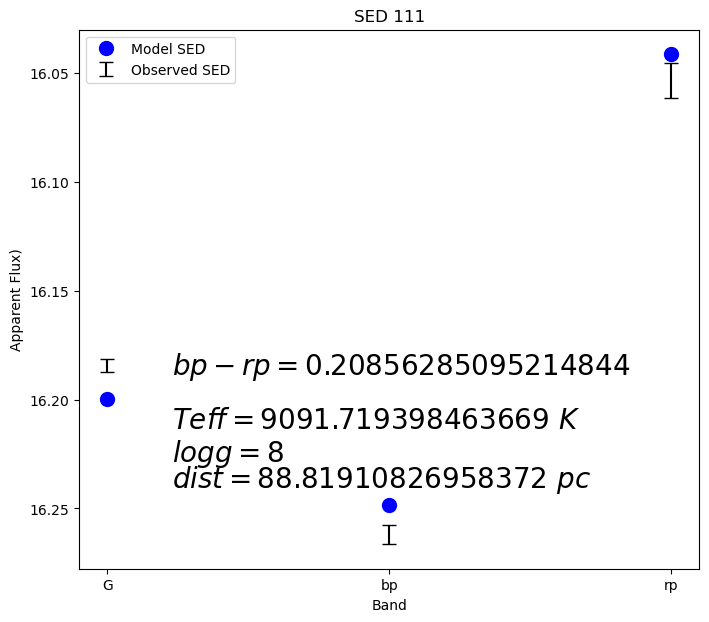

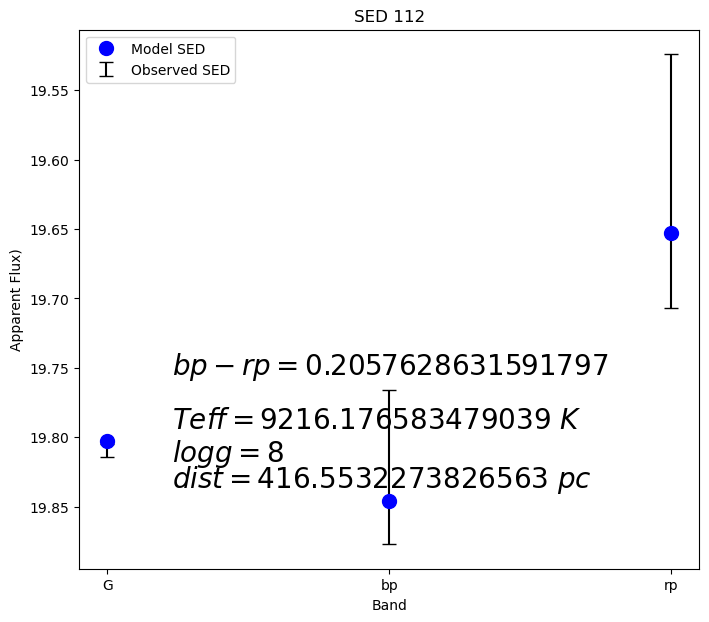

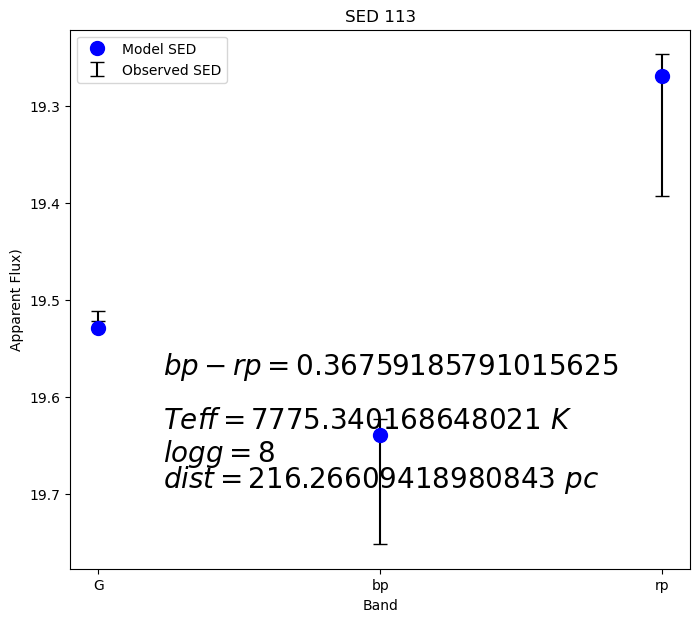

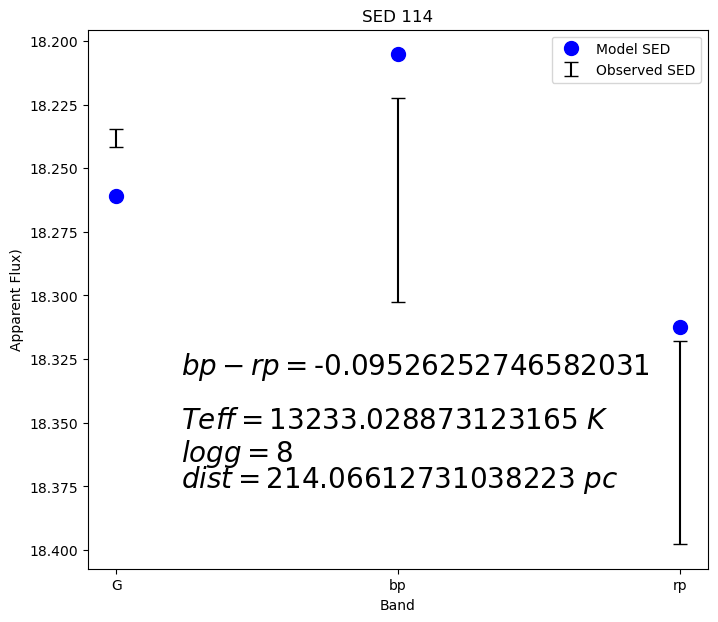

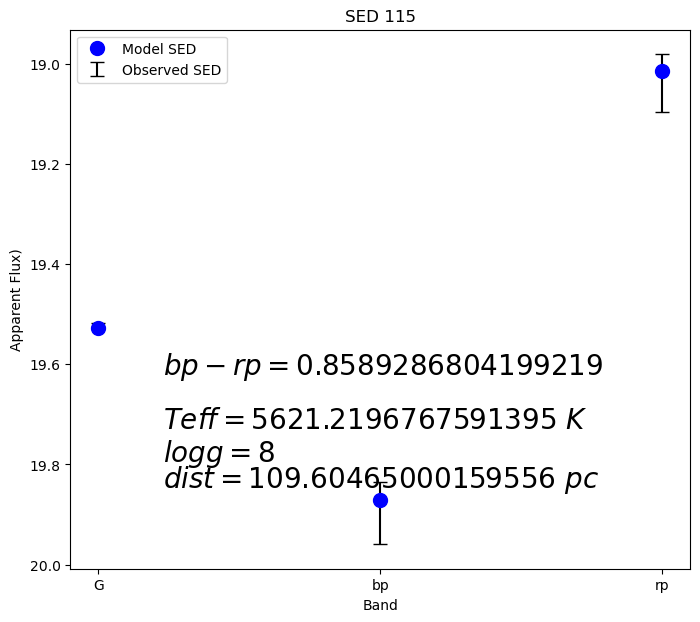

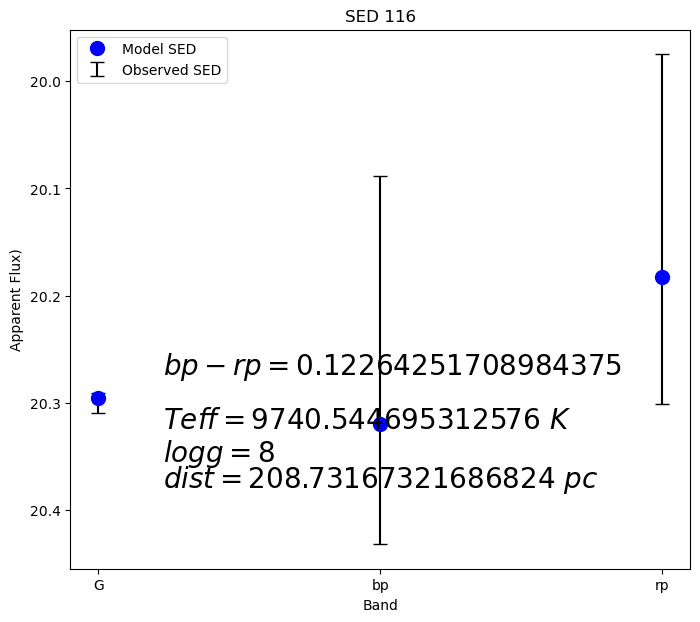

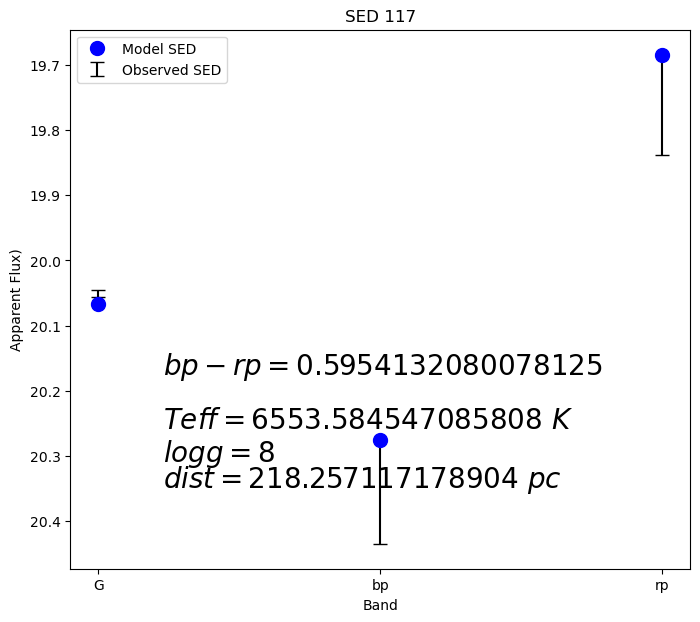

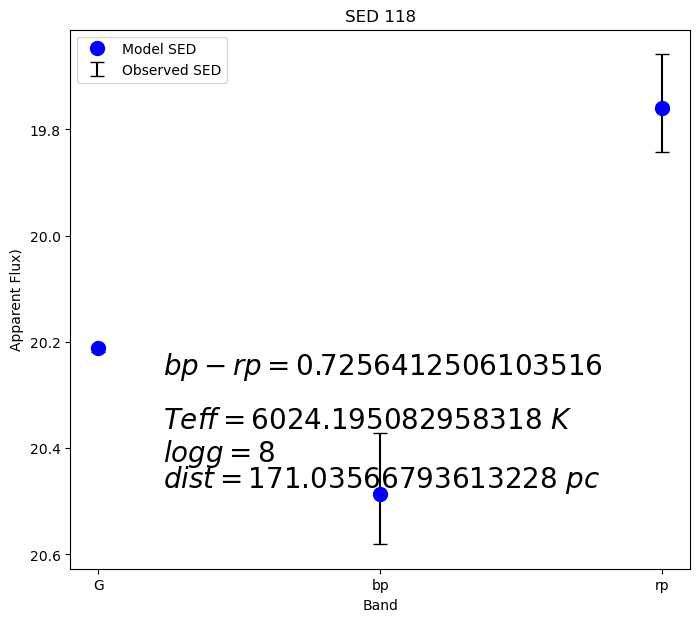

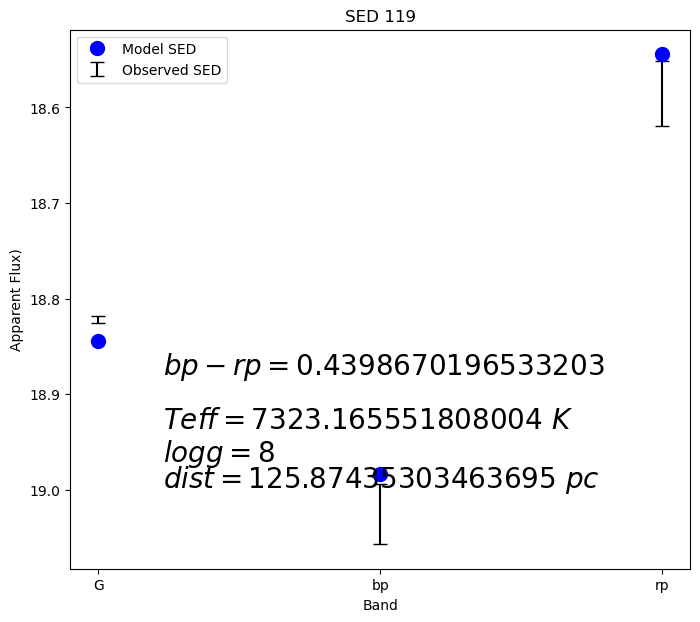

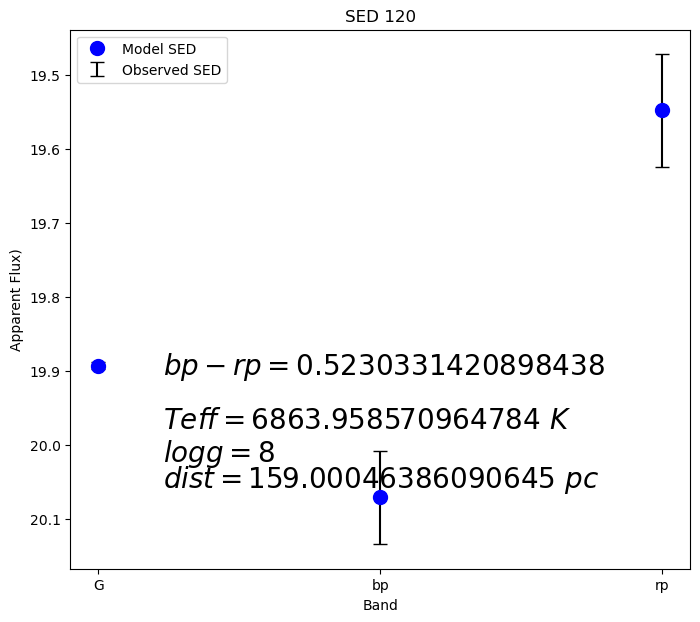

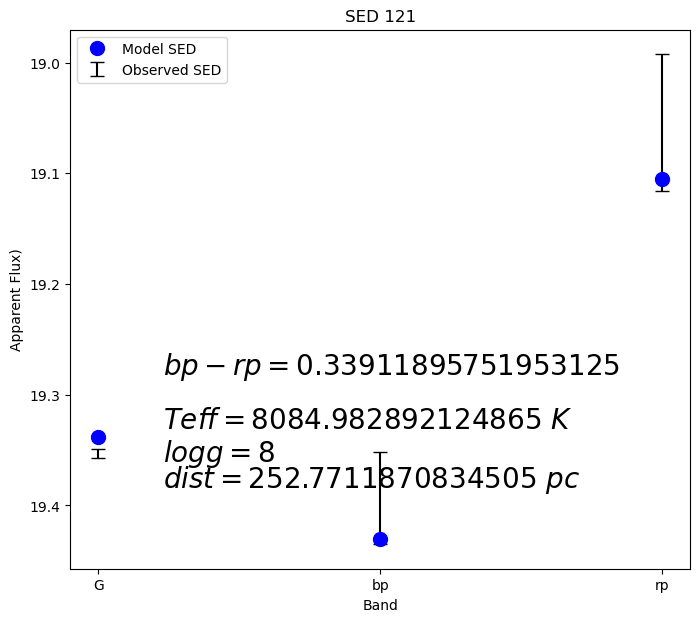

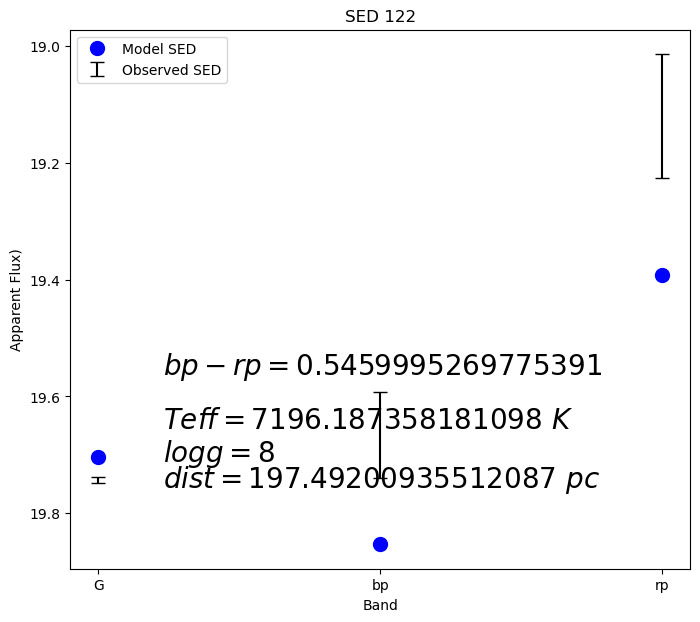

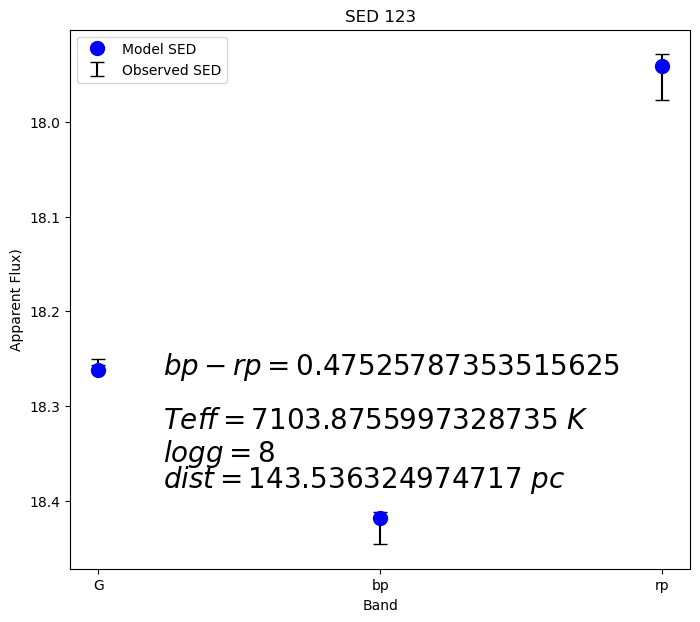

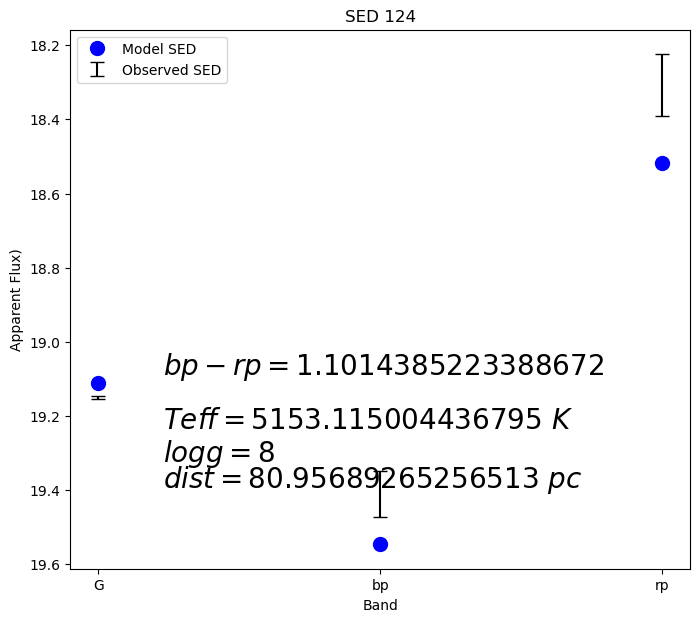

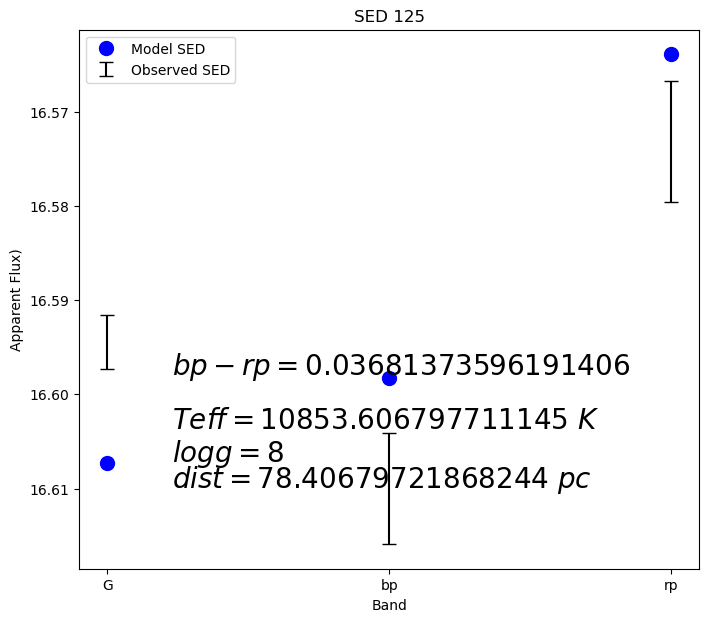

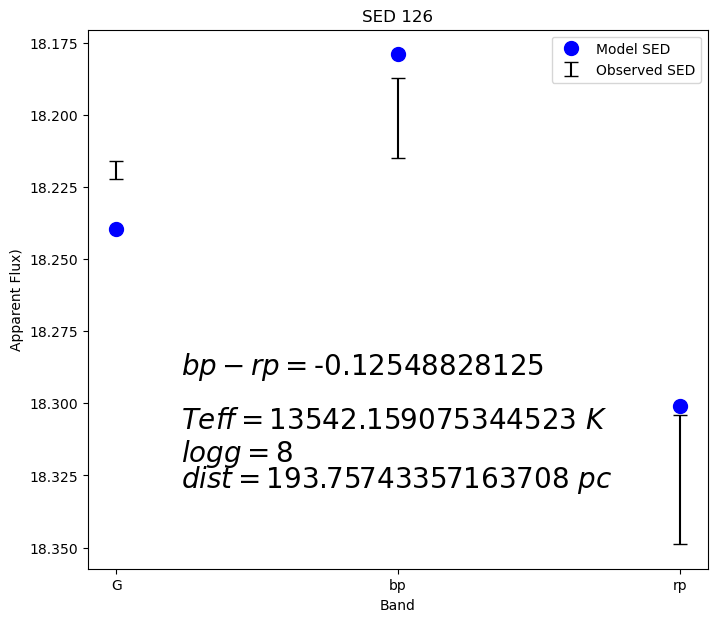

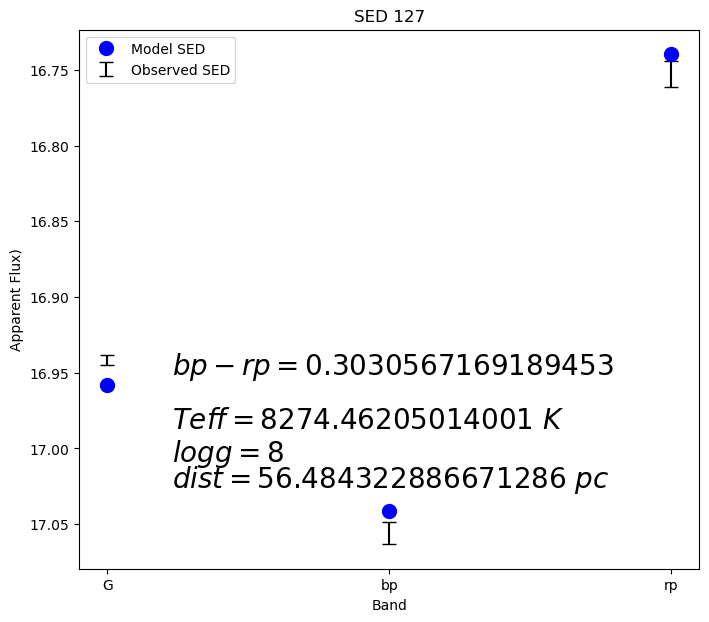

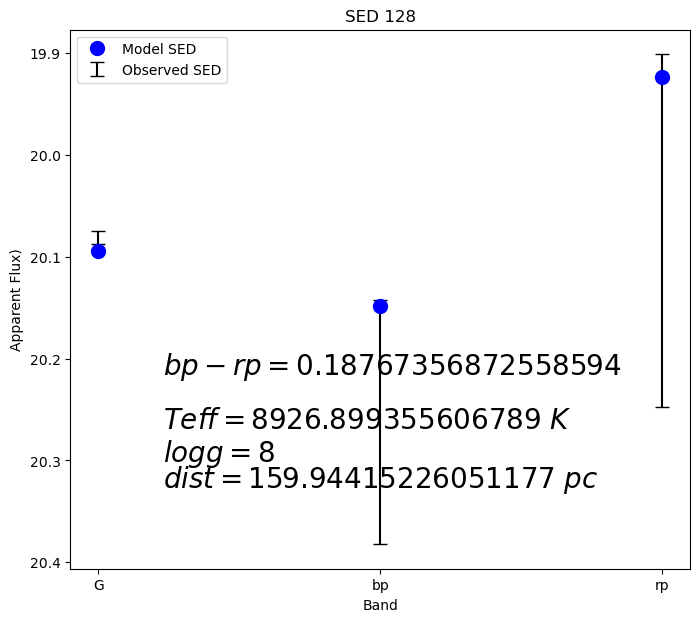

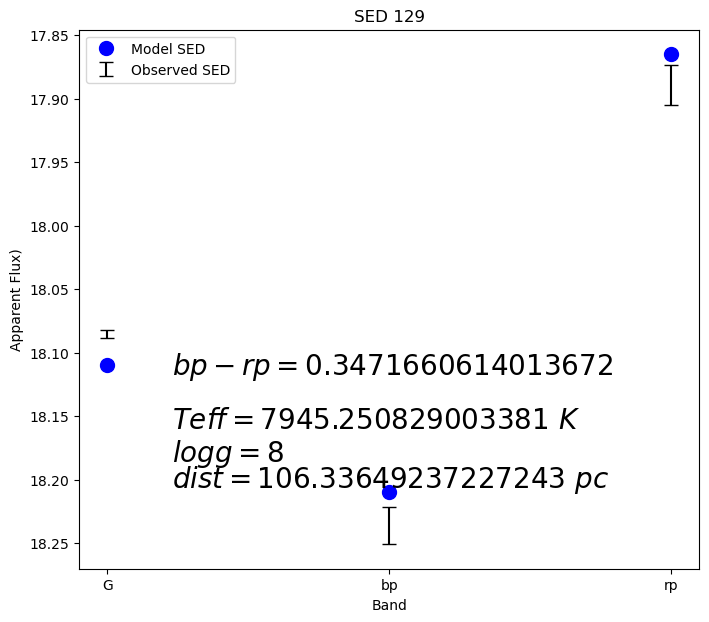

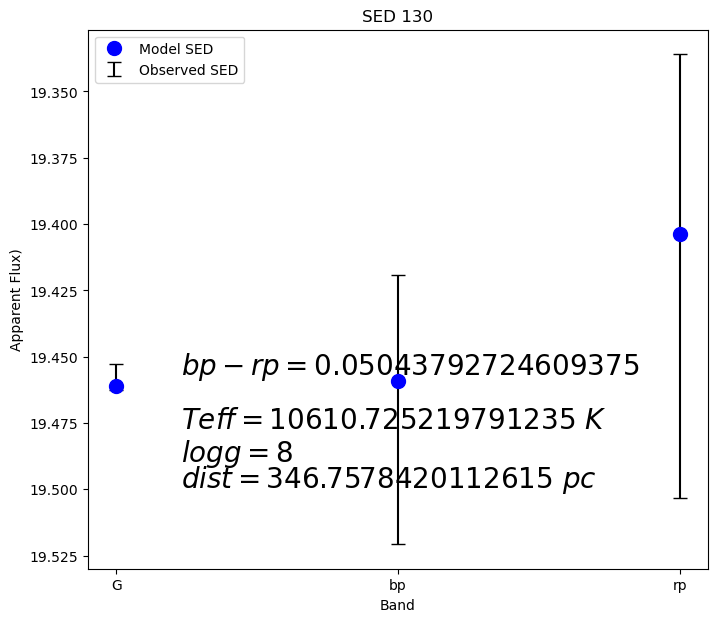

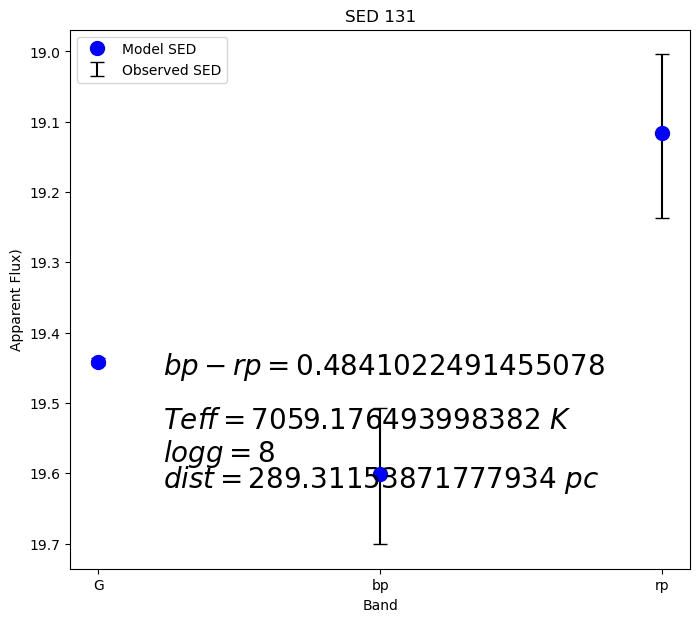

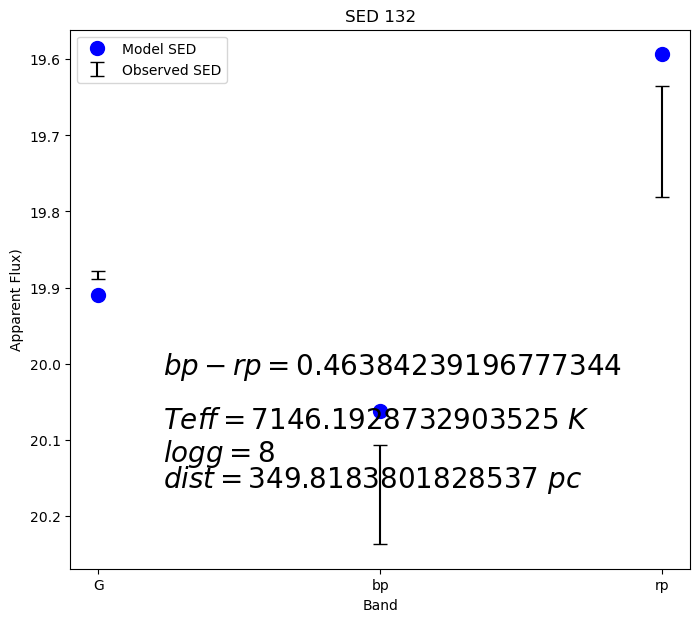

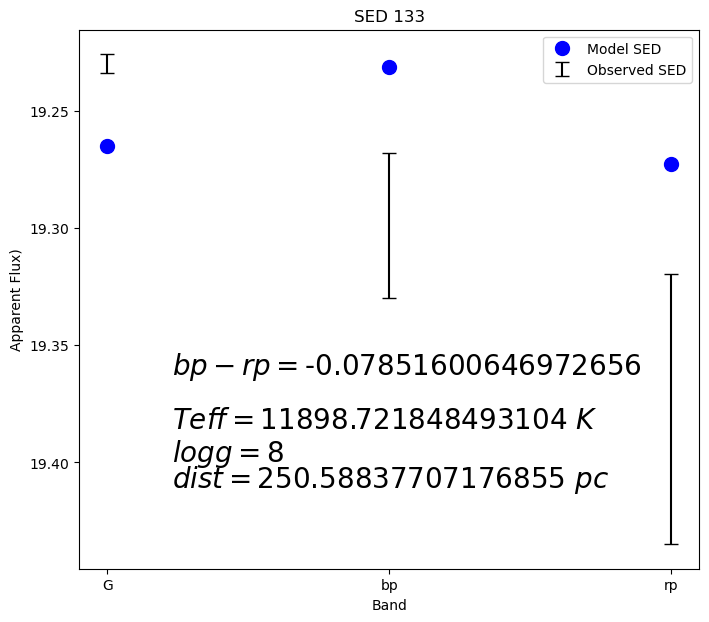

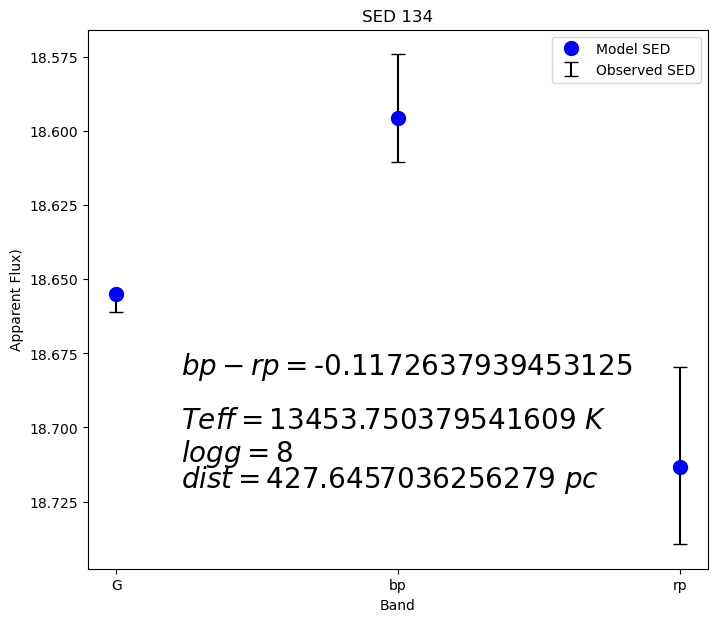

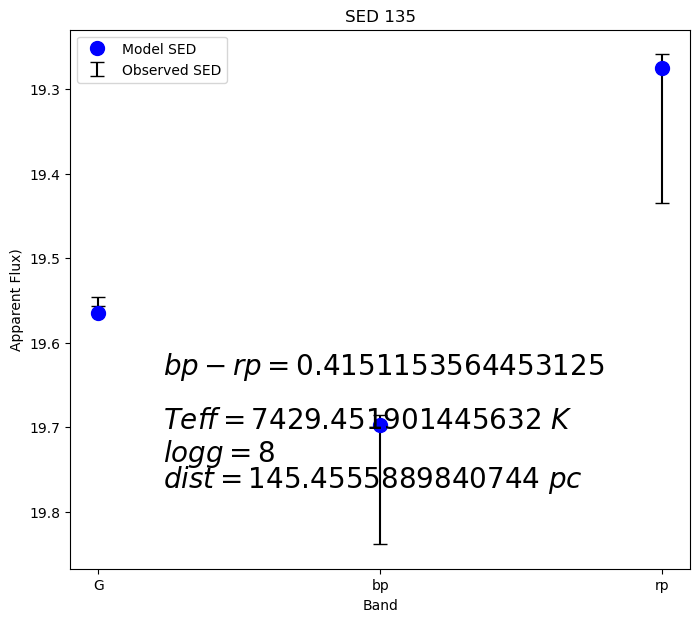

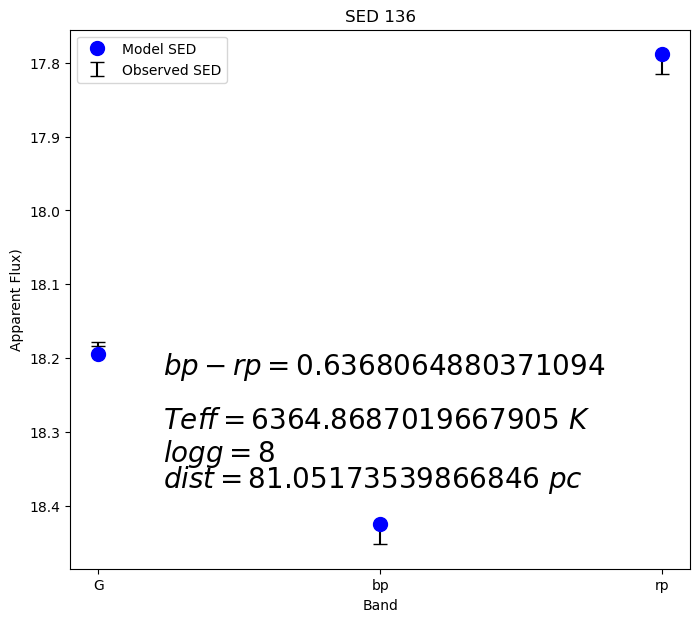

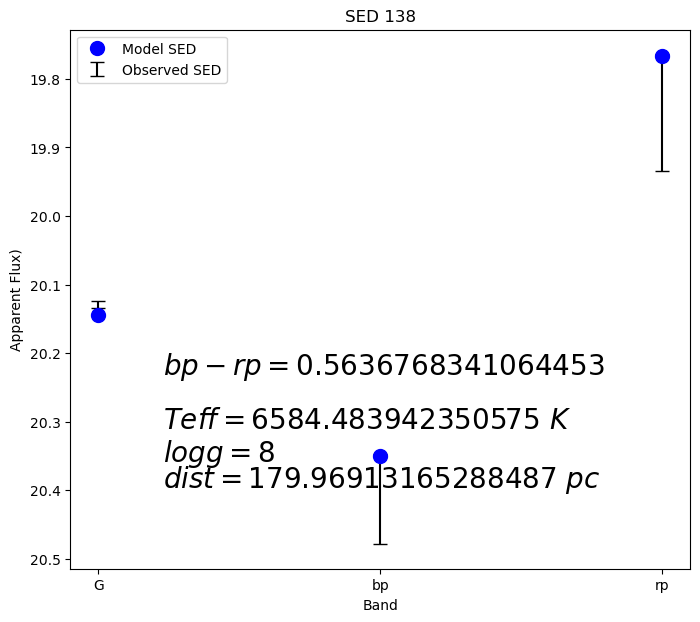

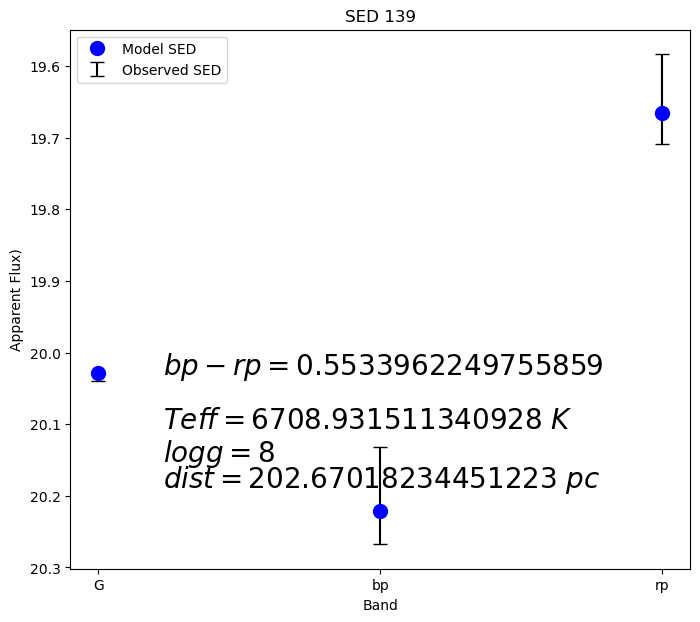

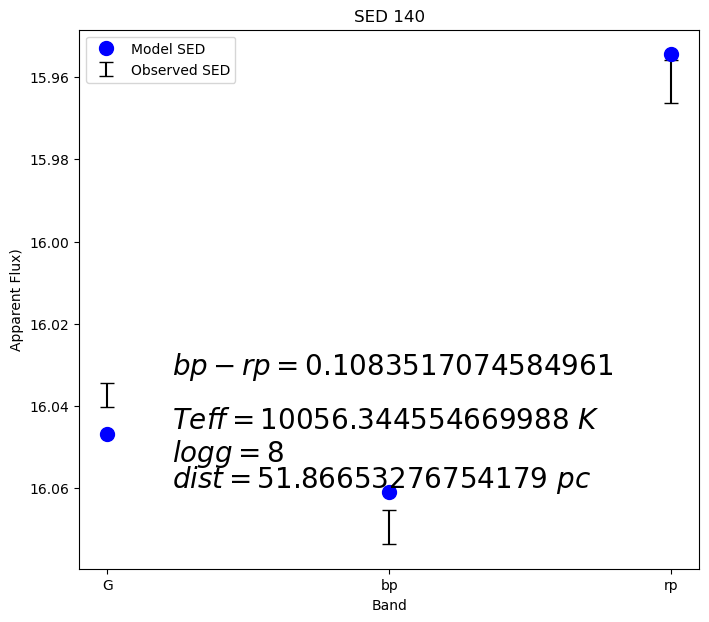

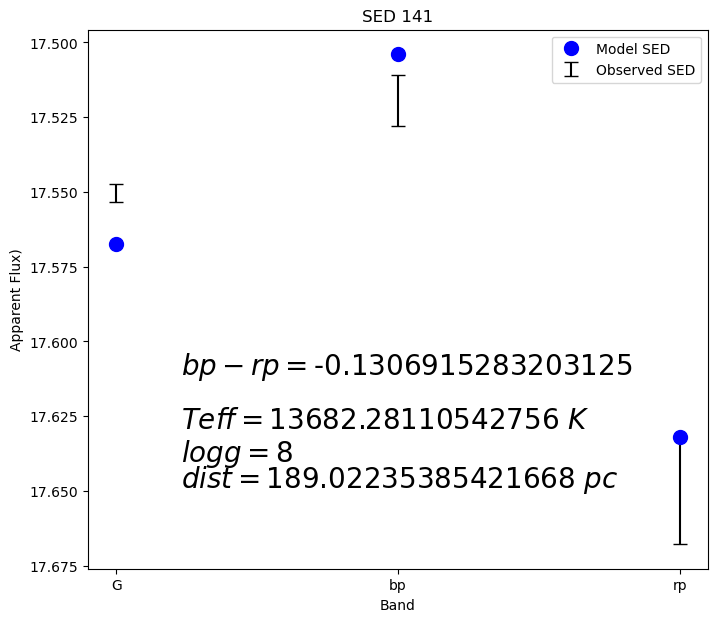

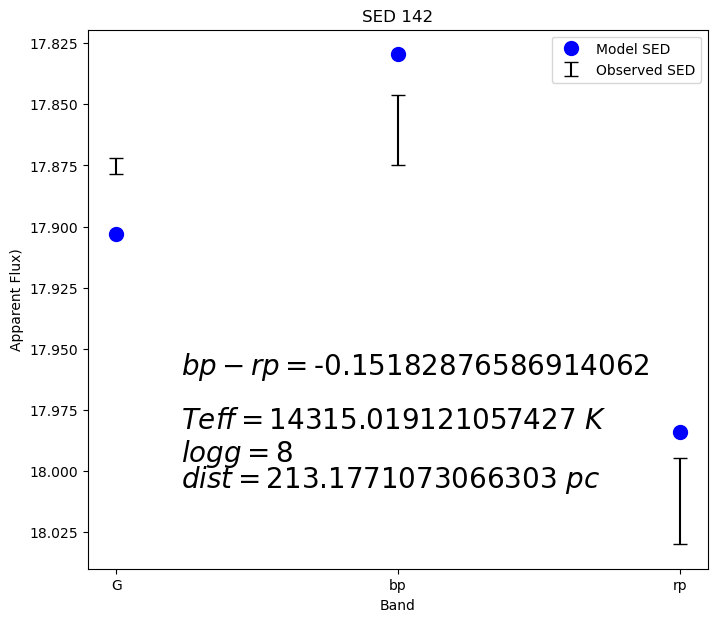

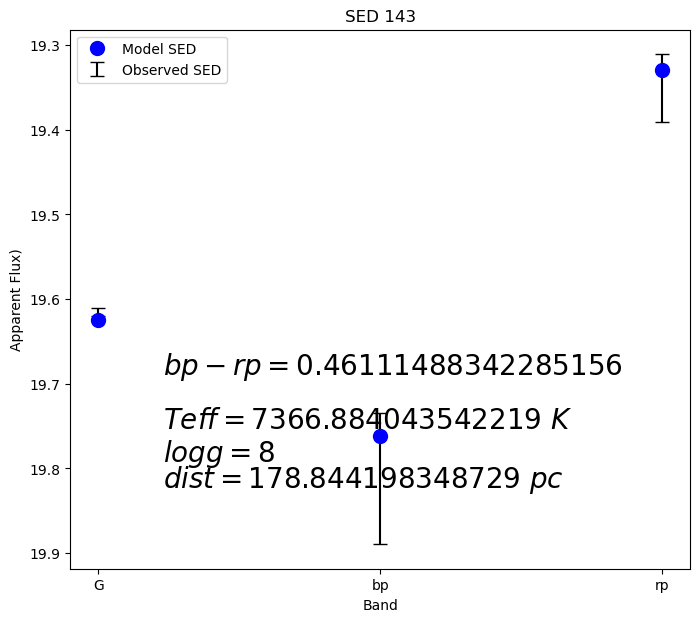

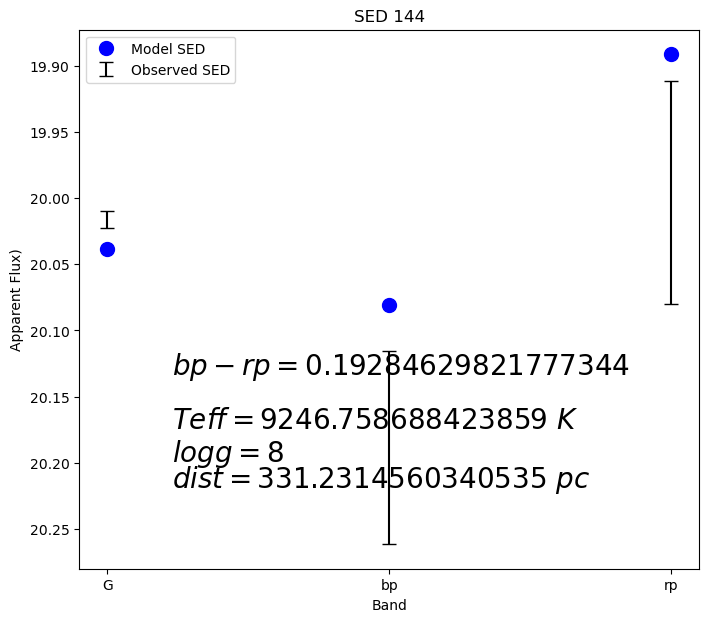

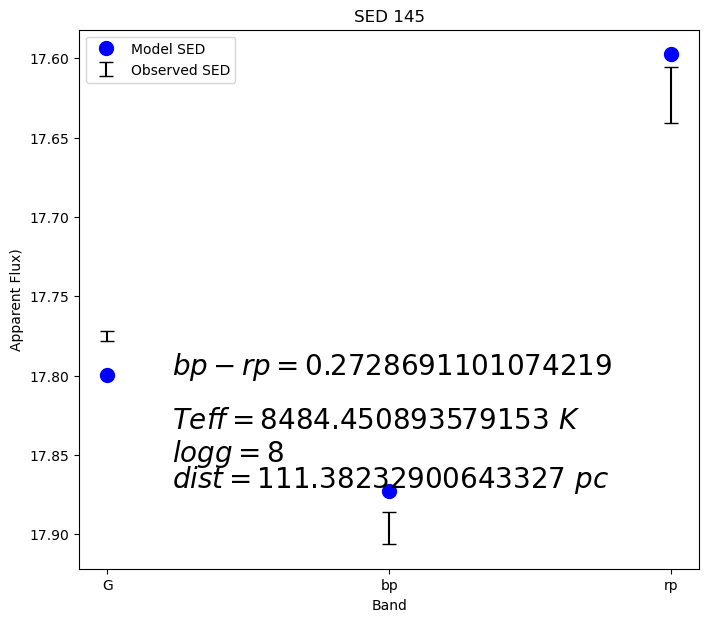

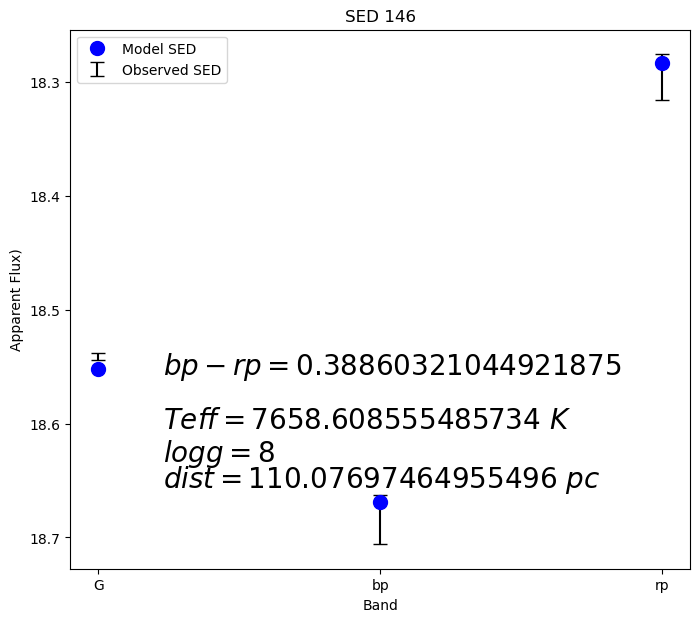

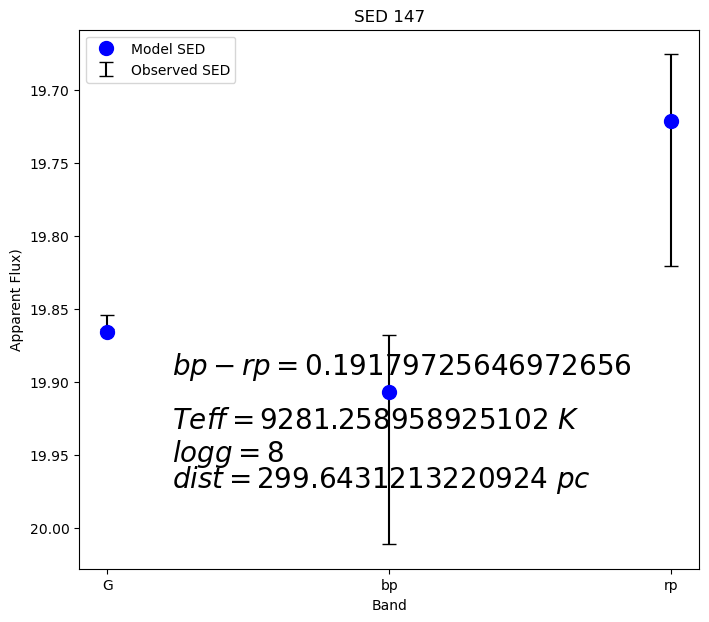

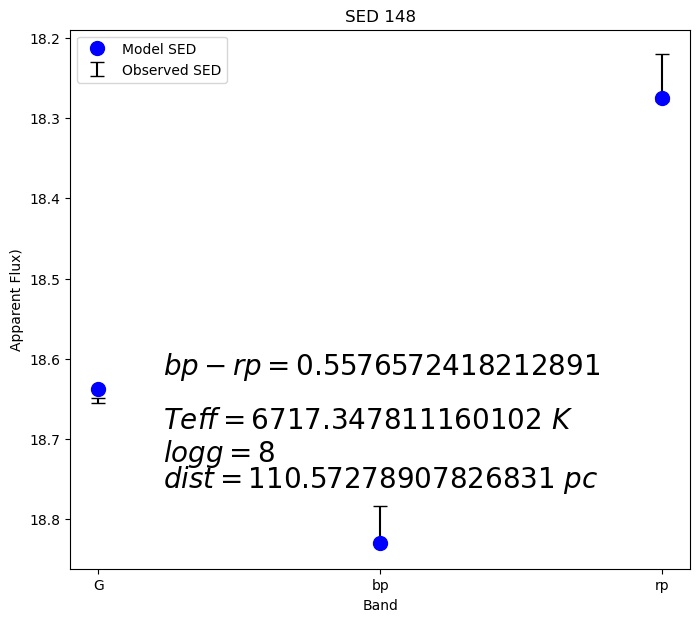

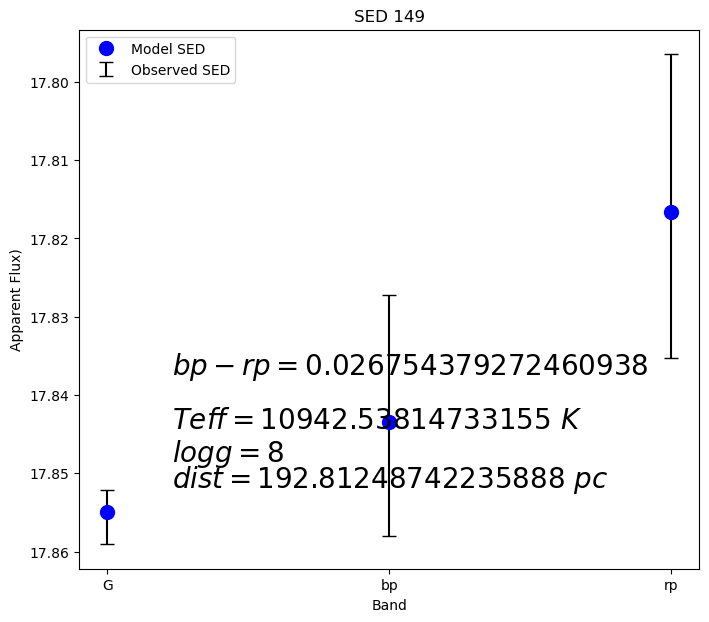

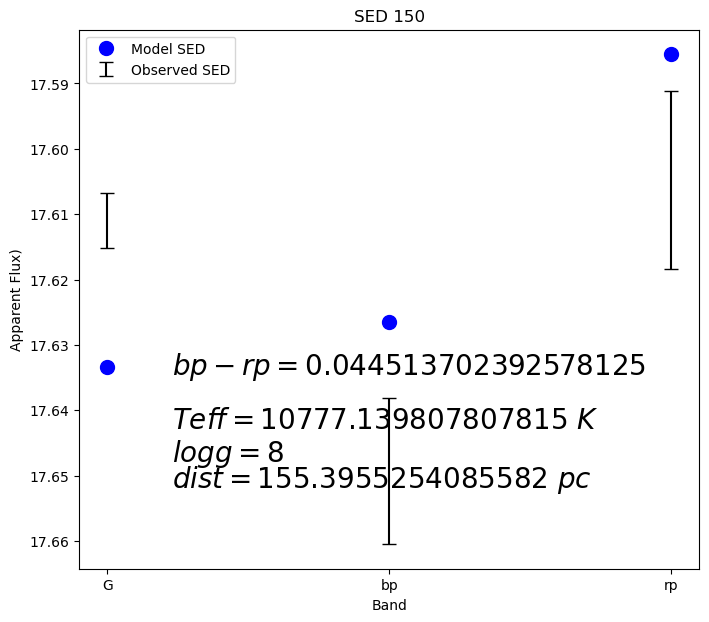

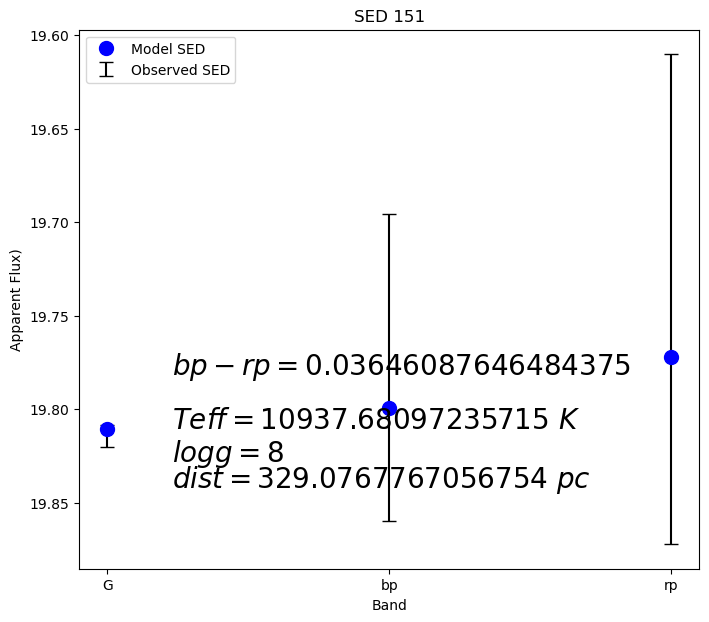

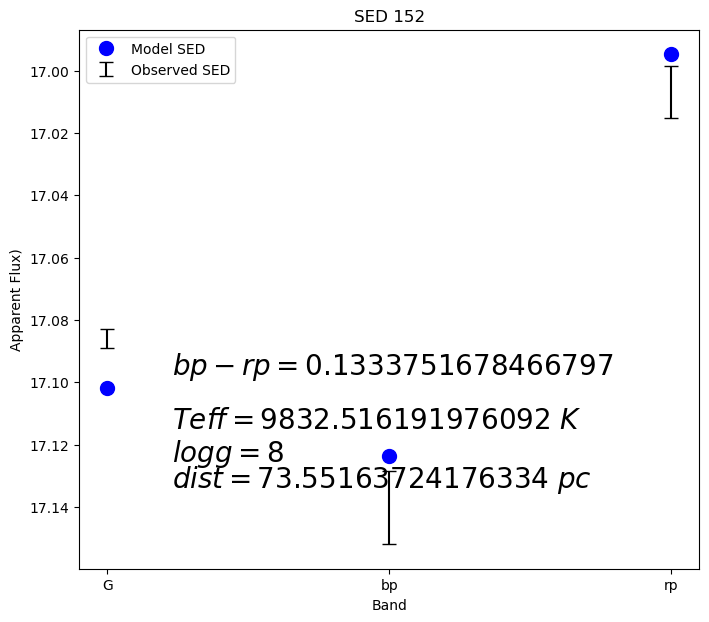

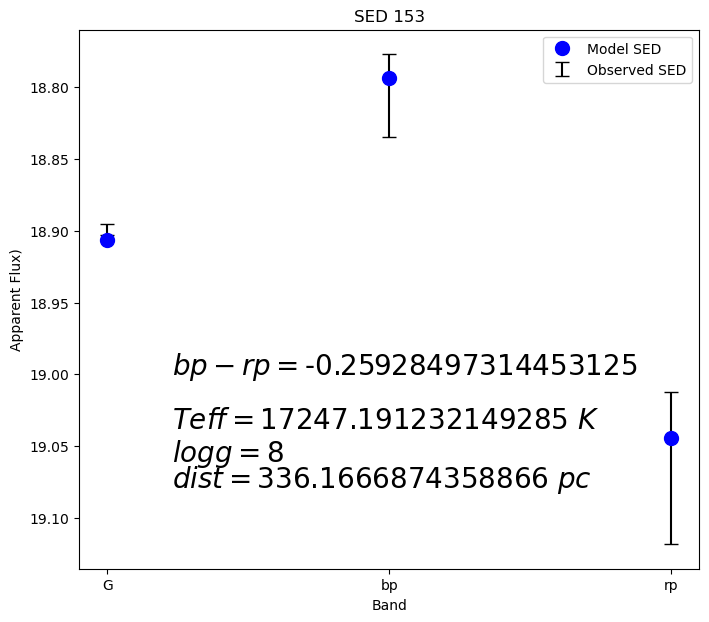

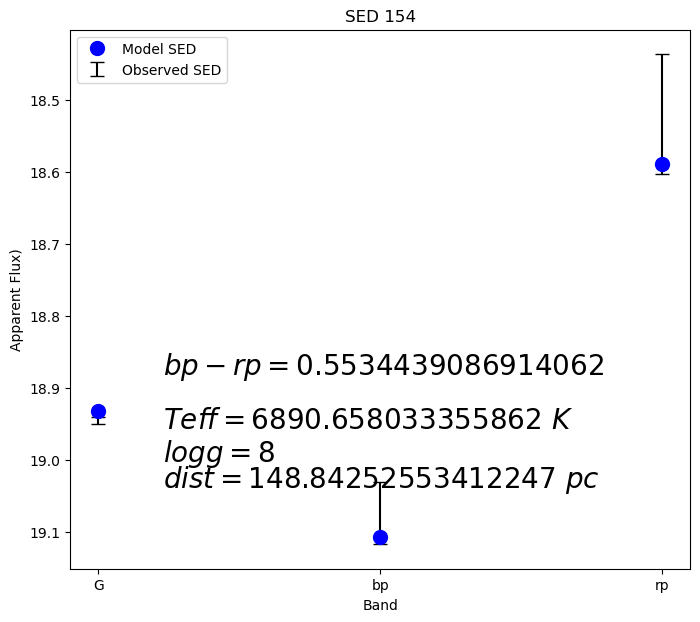

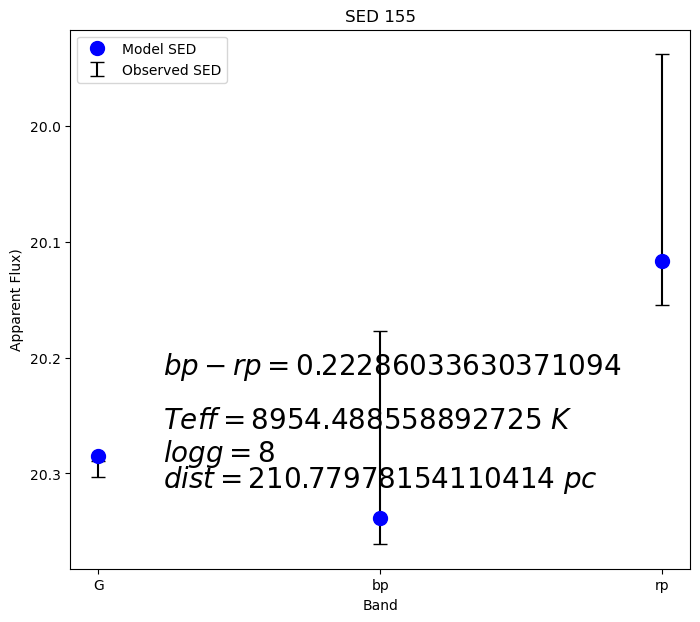

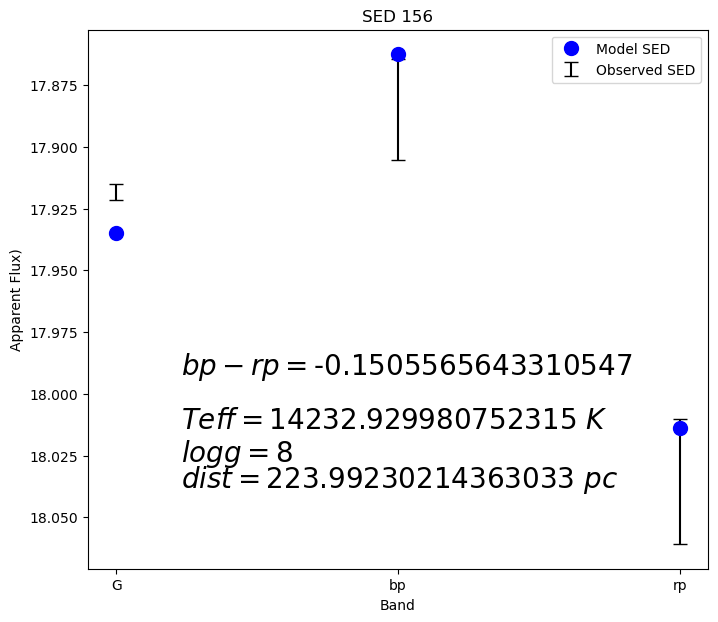

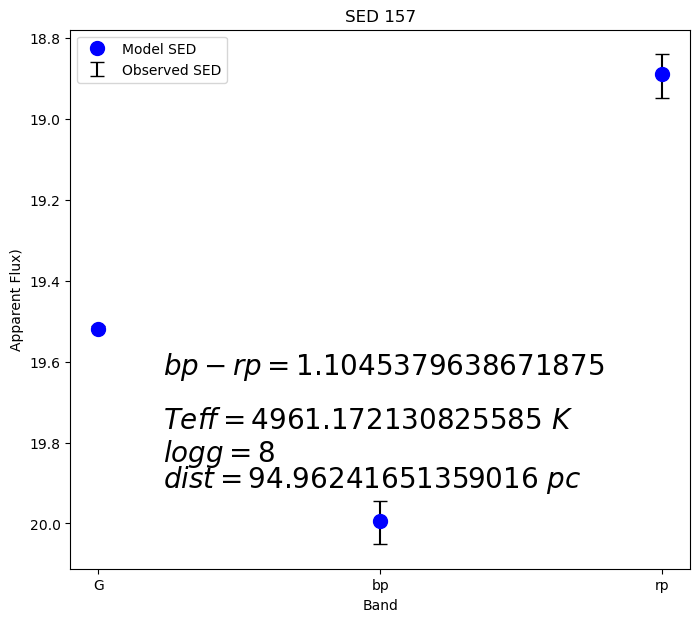

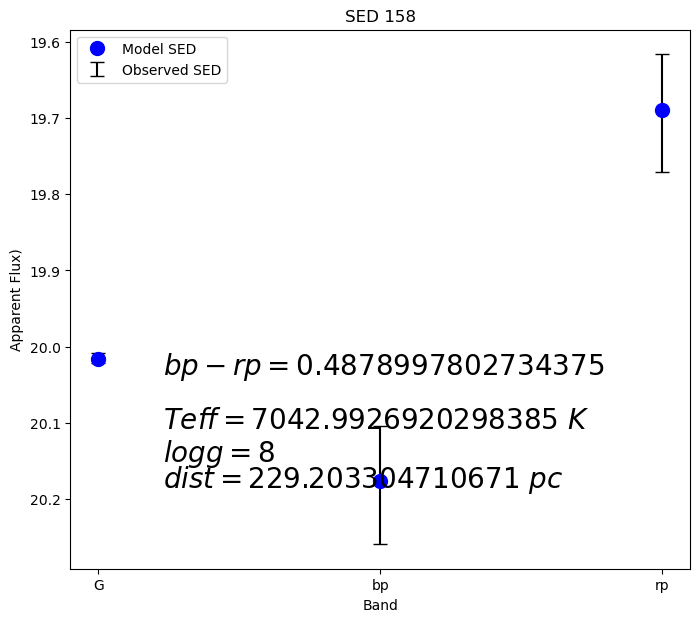

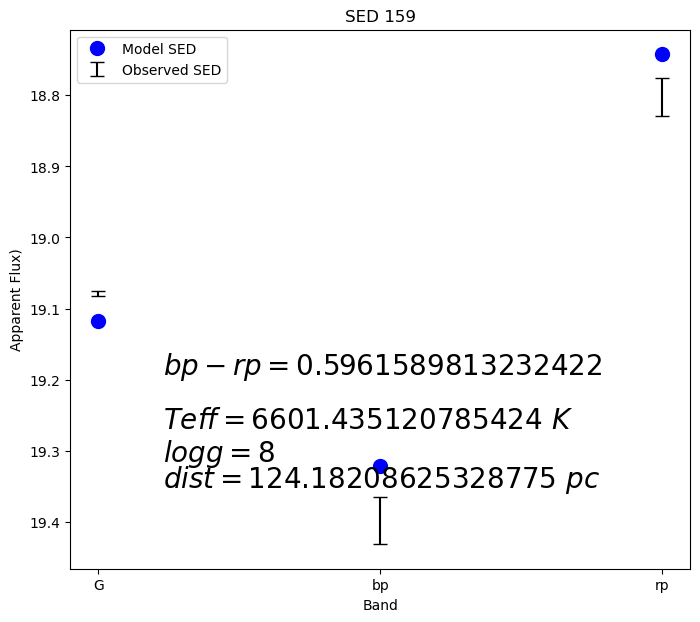

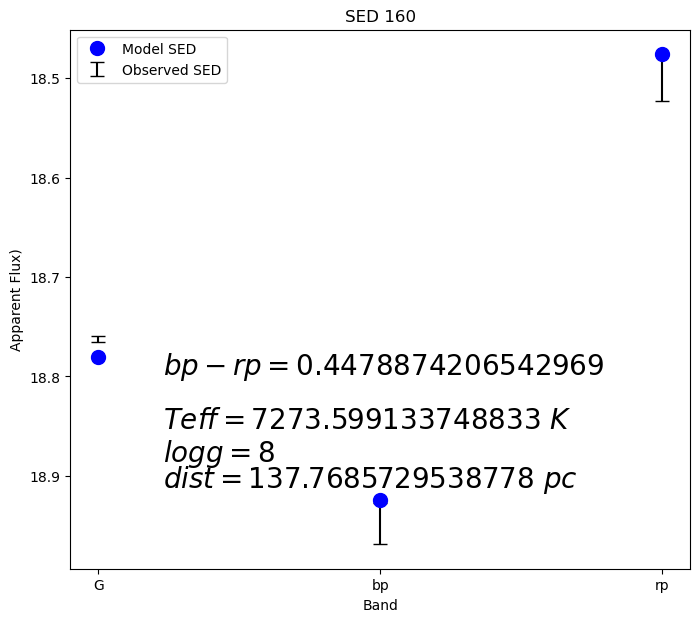

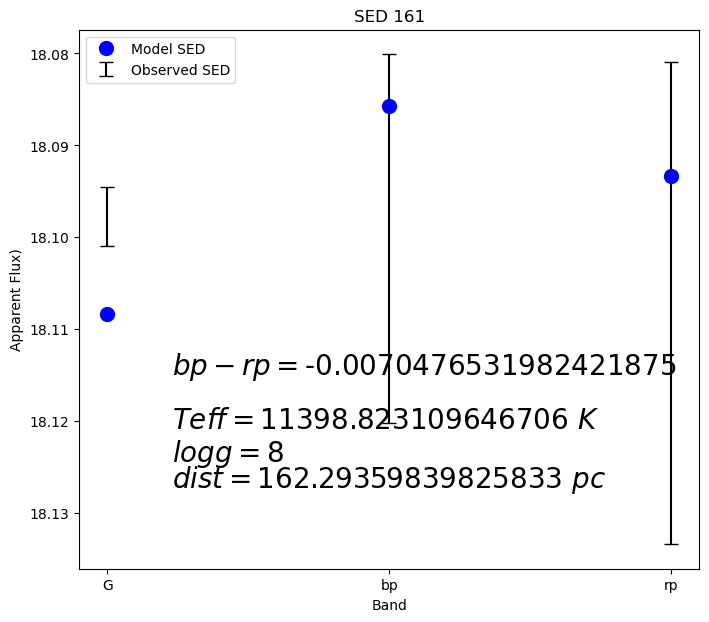

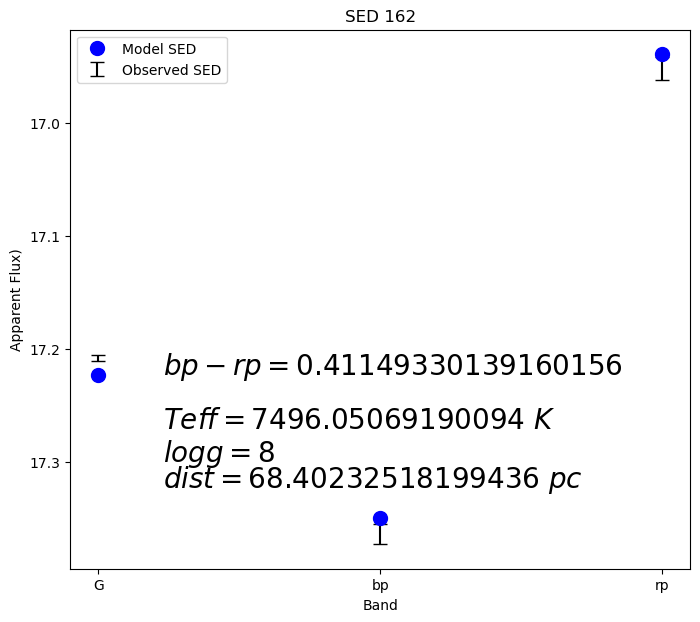

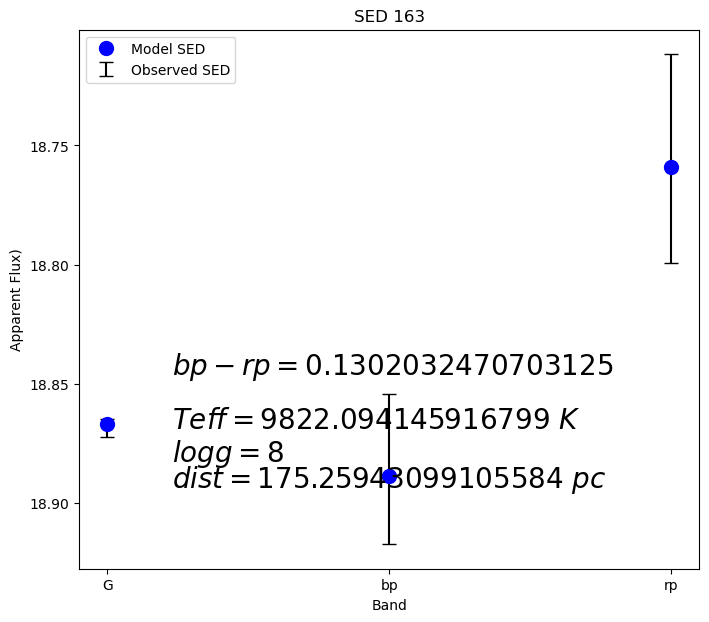

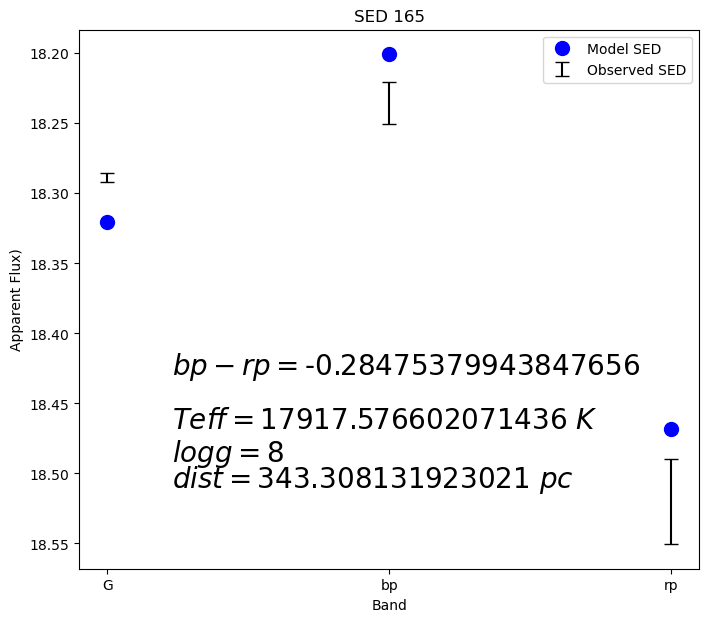

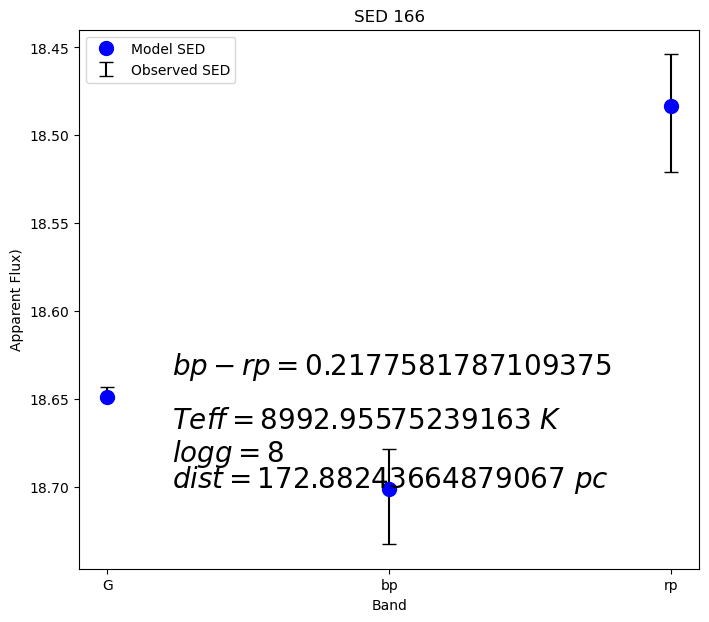

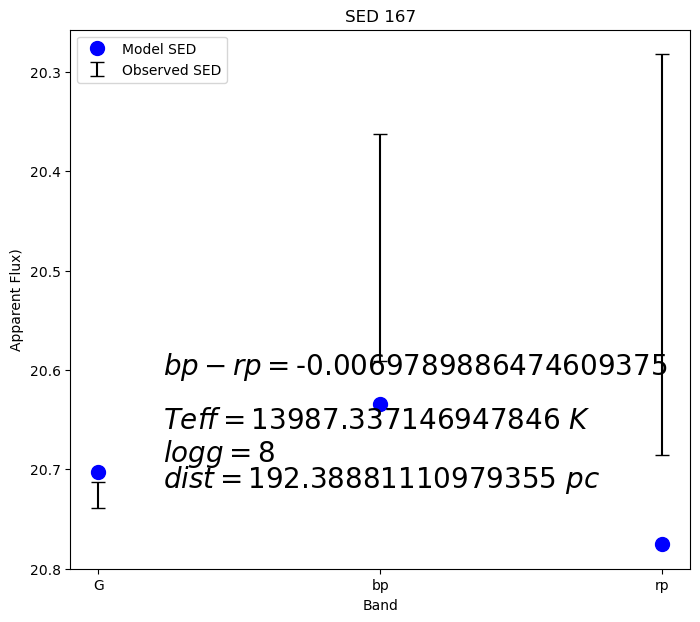

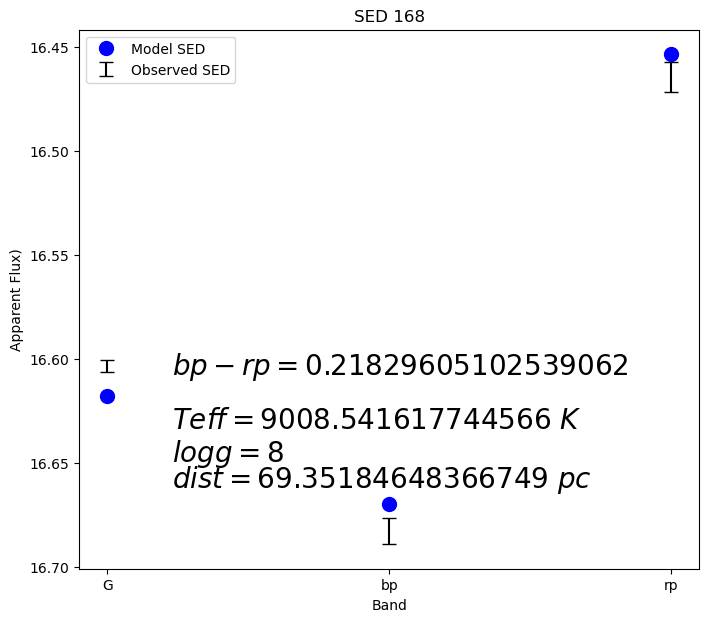

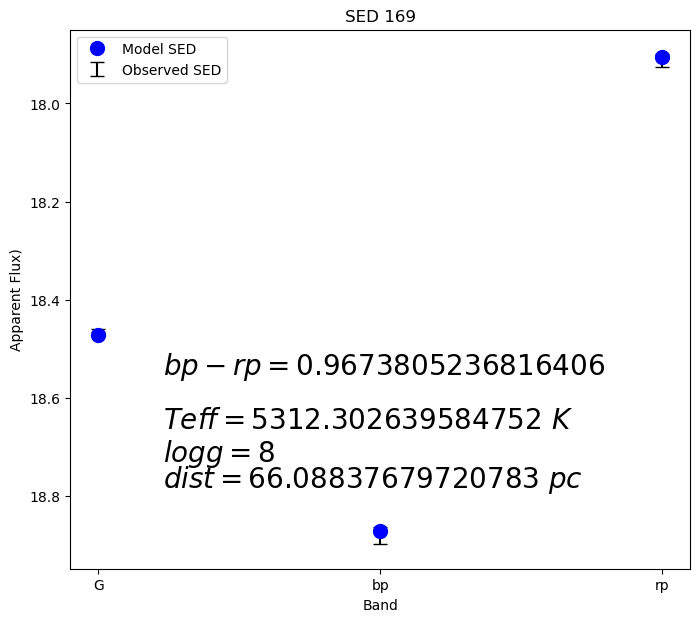

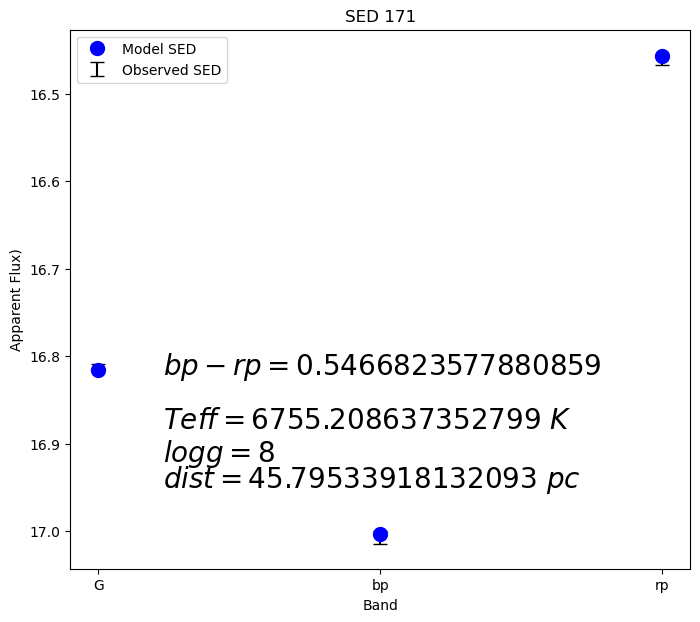

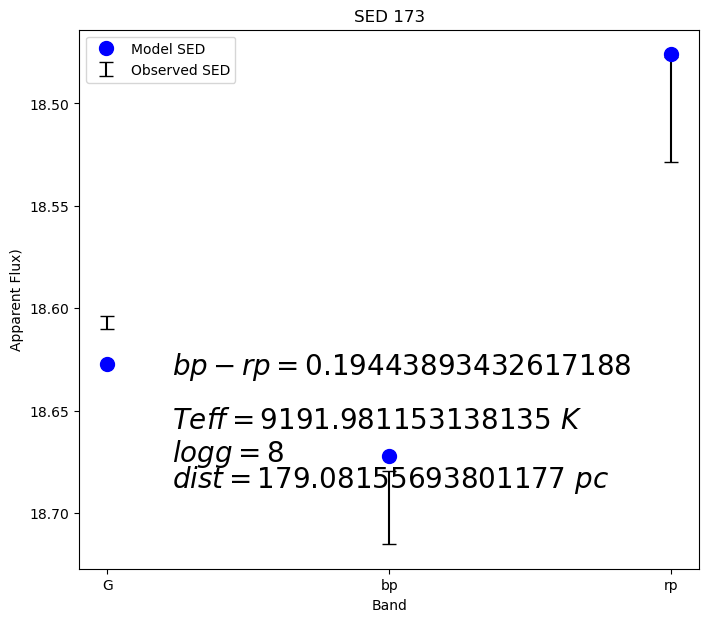

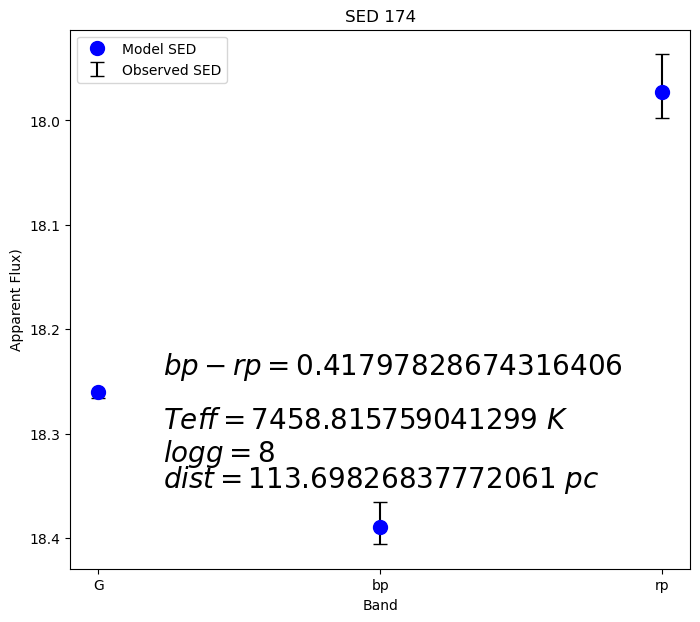

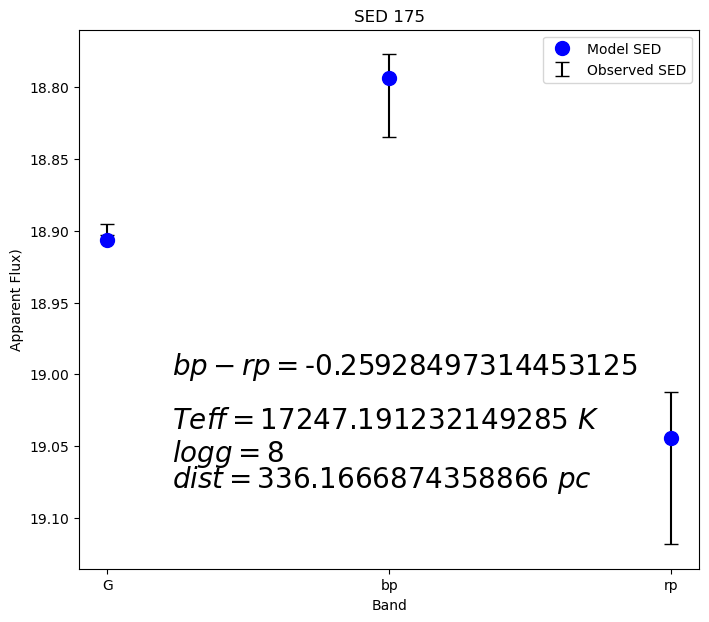

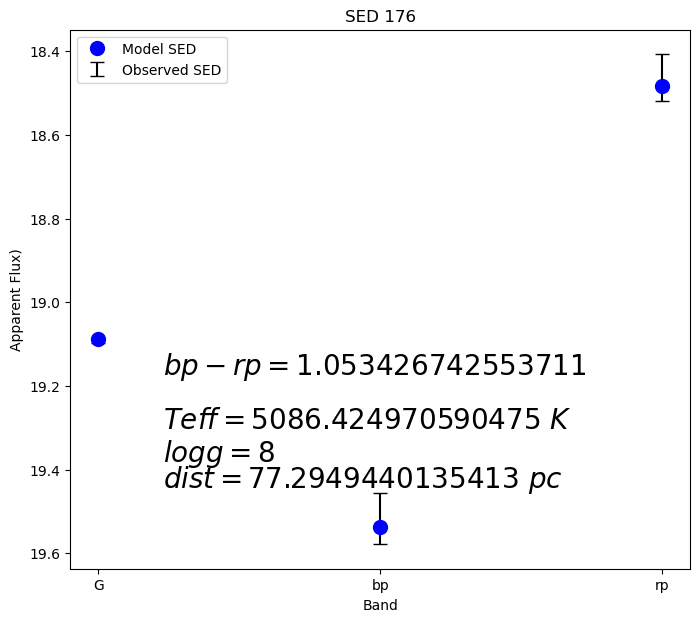

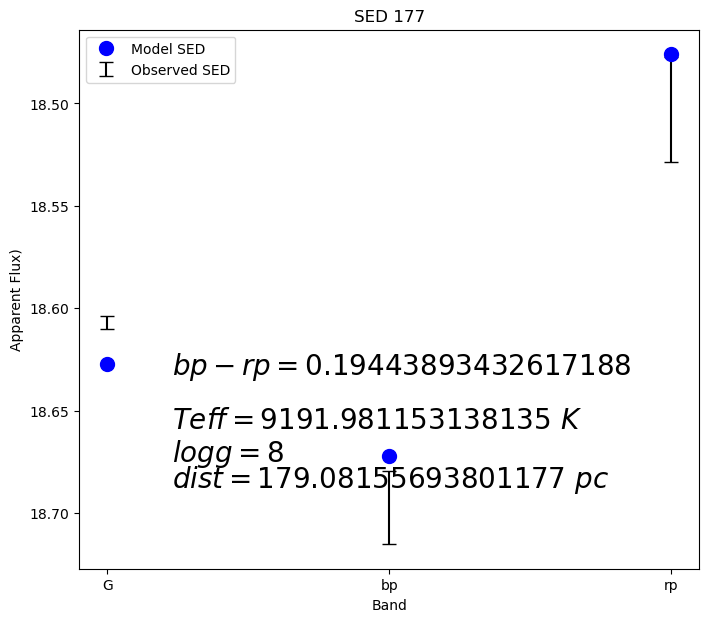

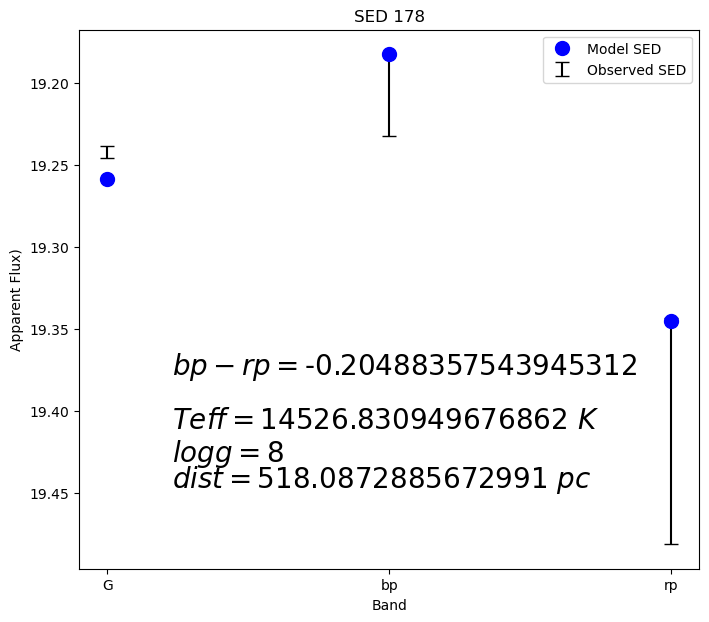

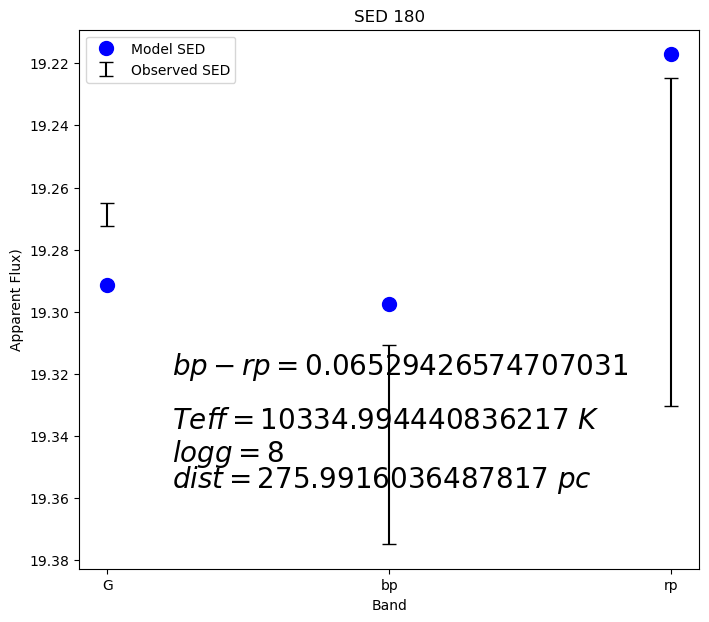

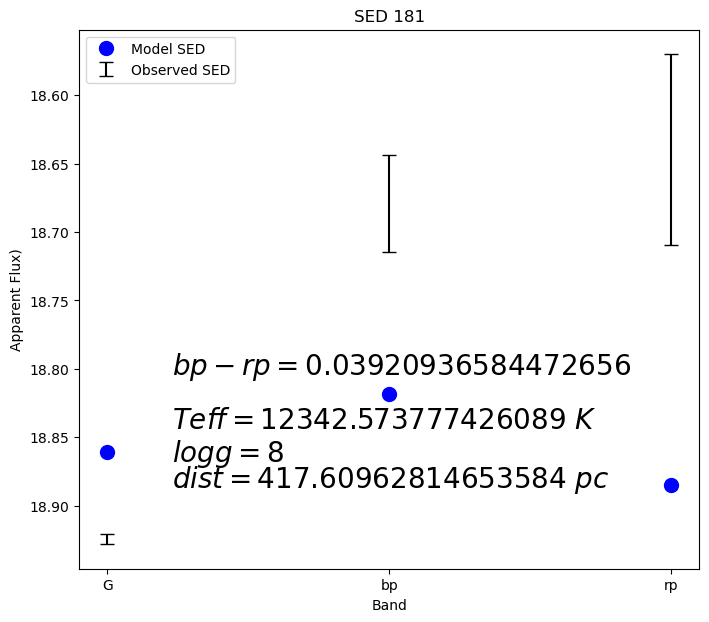

In [104]:
for i in tqdm(range(len(catalog))):
    bands = ['G', 'bp', 'rp']#, 'i', 'z']
    
    fig = plt.figure(figsize = (8,7))
    plt.errorbar(bands, np.array([catalog['wd_phot_g_mean_mag'][i], catalog['wd_phot_bp_mean_mag'][i], catalog['wd_phot_rp_mean_mag'][i]]),#, catalog['i'][i] + 0.015, catalog['z'][i] + 0.030],
                 yerr = np.array([np.sqrt((-2.5/np.log(10)*catalog['wd_phot_g_mean_flux_error'][i]/catalog['wd_phot_g_mean_flux'][i])**2 + sigmaG_0**2), 
                               np.sqrt((-2.5/np.log(10)*catalog['wd_phot_bp_mean_flux_error'][i]/catalog['wd_phot_bp_mean_flux'][i])**2 + sigmaGBP_0**2), 
                               np.sqrt((-2.5/np.log(10)*catalog['wd_phot_rp_mean_flux_error'][i]/catalog['wd_phot_rp_mean_flux'][i])**2 + sigmaGRP_0**2)]),#, catalog['i_err'][i], catalog['z_err'][i]],
                 linestyle = 'none', marker = 'None', color = 'k', capsize = 5, label = 'Observed SED')
    plt.plot(bands, get_model_flux_gaia(results[i].params), 'bo', markersize = 10, label = 'Model SED')
    plt.title('SED {}'.format(catalog['wd_catalog_id_phot'][i]))
    plt.text(0.15, 0.26, r'$Teff = ${} $K$'.format(results[i].params['teff'].value), transform = plt.gca().transAxes, fontsize=20)
    plt.text(0.15, 0.20, r'$logg = ${} '.format(results[i].params['logg'].value), transform = plt.gca().transAxes, fontsize=20)
    plt.text(0.15, 0.15, r'$dist = ${} $pc$'.format(results[i].params['distance'].value), transform = plt.gca().transAxes, fontsize=20)
    plt.text(0.15, 0.36, r'$bp-rp = ${}'.format(catalog['wd_bp_rp'][i]), transform = plt.gca().transAxes, fontsize=20)
    plt.xlabel('Band')
    plt.ylabel('Apparent Flux)')
    plt.gca().invert_yaxis()
    plt.legend() 
    plt.savefig('spectra/leastsq/phot_fit/{}.png'.format(catalog['wd_catalog_id_phot'][i]))

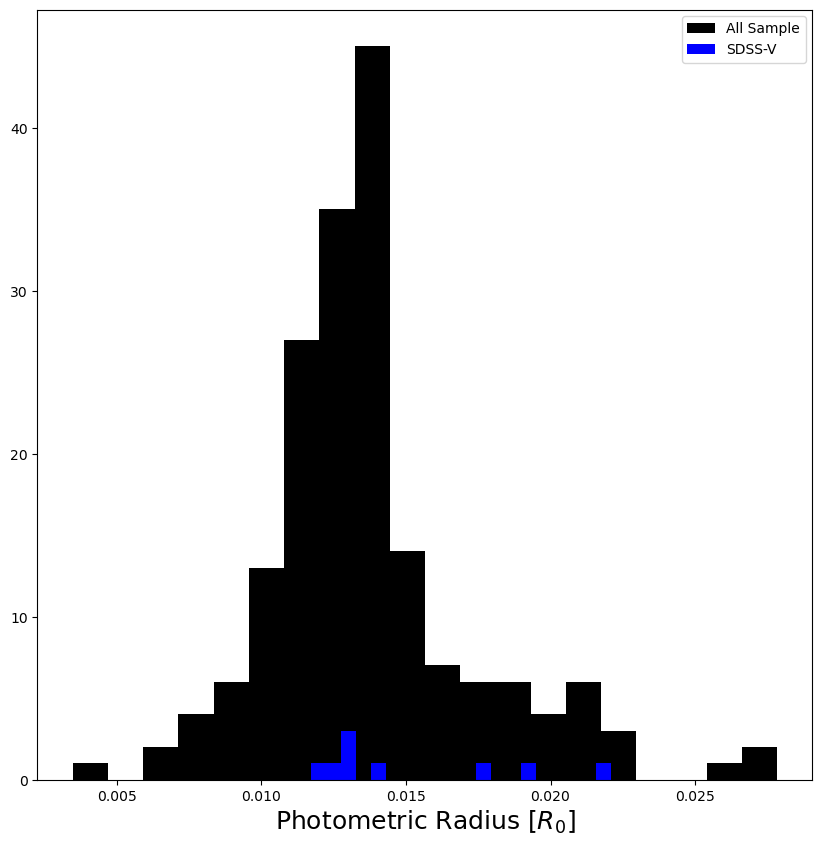

In [101]:
plt.figure(figsize=(10,10))
plt.hist(catalog['radius'], bins = 20, color='black', label = 'All Sample')
plt.hist(catalog['radius'][catalog['uses_sdss5'] == 1], bins = 20, color='blue', label = 'SDSS-V')
ymin, ymax = plt.ylim()
#plt.vlines(np.mean(catalog['phot_teff']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Photometric Radius $[R_0]$', fontsize=18)
plt.legend()

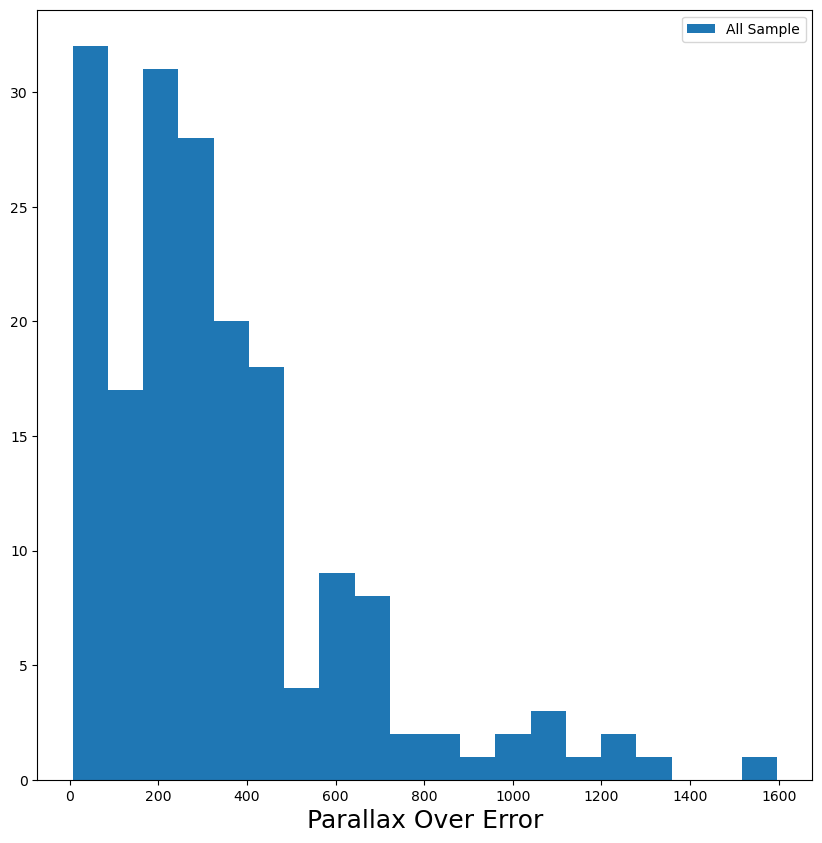

In [103]:
plt.figure(figsize=(10,10))
plt.hist(catalog['ms_parallax_over_error'], bins = 20, label = 'All Sample')
ymin, ymax = plt.ylim()
#plt.vlines(np.mean(catalog['phot_teff']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Parallax Over Error', fontsize=18)
plt.legend()

In [70]:
catalog.remove_columns(['ms_parallax', 'ms_parallax_error','wd_l', 'wd_b', 'raw_radius_result', 'wd_bp_rp', 'wd_phot_g_mean_mag', 
                        'wd_phot_bp_mean_mag', 'wd_phot_rp_mean_mag', 'wd_phot_g_mean_flux_error', 'wd_phot_bp_mean_flux_error', 'wd_phot_rp_mean_flux_error'])

catalog.write('data/02_photometry.fits', overwrite=True)

In [71]:
nug = catalog[['wd_source_id', 'phot_teff', 'e_phot_teff', 'converged', 'reliable_dist']]
nug.pprint()

nug.write('data/nugget.fits', overwrite = True)

    wd_source_id        phot_teff         e_phot_teff     converged reliable_dist
------------------- ------------------ ------------------ --------- -------------
 617887567299258752 15057.024100203776 493.94214335300313      True          True
 676167215489980800 11741.826240795453  431.7035343195316      True         False
 743097619303531904 14072.814723321184 455.70056892223346      True         False
 921518807117547904  7960.207717104286  296.5173038970041      True         False
1261421999231535616  5758.428218825541 106.65551018368718      True         False
2509935938109492736 10581.328349295567  879.2557177830087      True         False
2534148150521389440 14570.542421845277   323.806488511364      True         False
2534260777448123392  9452.504191903323  583.9802296056899      True          True
2688215048406240640 10482.379852087764   791.747887290105      True         False
3245310308566177536  6520.025034691846  676.5910929762127      True         False
                